In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import Dataset, DataLoader
import glob
import matplotlib.pyplot as plt
import os

# 3D CNN Model
class CNN3D(nn.Module):
    def __init__(self):
        super(CNN3D, self).__init__()
        
        self.conv0 = nn.Conv3d(in_channels=23, out_channels=64, kernel_size=1, stride=1, padding=0) # play around with output channels
        self.conv1 = nn.Conv3d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool3d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv3d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool3d(kernel_size=2, stride=2, padding=0)

        #self.dropout_conv = nn.Dropout3d(p=0.05)
        
        # After two pooling layers, spatial dimensions reduce from 40x40x40 -> 5x5x5
        self.fc1 = nn.Linear(128 * 3 * 3 * 3, 256)  # Try increasing over 256
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 2)  # Assuming 1 output for docking status/position

        #self.dropout_fc = nn.Dropout(p=0.15)
        
    def forward(self, x):
        # Forward pass through Conv layers
        x = self.pool(torch.relu(self.conv0(x)))  # Conv0 -> ReLU -> Pooling
        #x = self.dropout_conv(x)
        x = self.pool(torch.relu(self.conv1(x)))  # Conv1 -> ReLU -> Pooling
        x = self.pool2(torch.relu(self.conv2(x)))  # Conv2 -> ReLU -> Pooling

        # Flatten the input for fully connected layers
        x = x.view(-1, 128 * 3 * 3 * 3)
        
        # Forward pass through fully connected layers
        x = torch.relu(self.fc1(x)) #use tanh activation
        #x = self.dropout_fc(x)
        x = torch.relu(self.fc2(x))
        x = torch.nn.functional.softmax(self.fc3(x), dim=1)  # Final layer (output layer)
        #x = torch.clamp(x, min=1e-7, max=1 - 1e-7)  # Clamp outputs to avoid extreme values
        
        return x

In [2]:
class GridDataset(Dataset):
    def __init__(self, data_dict):
        self.data = list(data_dict.values())

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        grid = sample['grid_tensor']
        label = sample['label']
        return grid, label

In [3]:
# Training function
def train_model(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=3.0)

        total_grad_norm = 0
        for name, param in model.named_parameters():
            if param.grad is not None:
                total_grad_norm += param.grad.norm().item()
        optimizer.step()
        
        running_loss += loss.item()
    return (running_loss / len(dataloader)), total_grad_norm

# Validation function
def validate_model(model, dataloader, criterion, device):
    model.eval()  # Set model to evaluation mode
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():  # Disable gradient calculation
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            
            # Compute accuracy
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    
    validation_loss = running_loss / len(dataloader)
    accuracy = correct / total
    return validation_loss, accuracy

In [4]:
# Create a dictionary with file names as keys and label + tensor grid as values
positive_grids = glob.glob('../../../Data/SplitData/Cholesterol/cholesterol-grid-5A_exp1/PositiveWithoutSpies/*.npy')
validation_grids = glob.glob('../../../Data/SplitData/Cholesterol/cholesterol-grid-5A_exp1/Validation_Set/*.npy')
file_data = {} # format is filename as key, label and grid tensor are values

for file in positive_grids:
    # Load the numpy array and convert it to a PyTorch tensor
    grid = np.load(file)
    grid_tensor = torch.tensor(grid, dtype=torch.float32).permute(3, 0, 1, 2)  # Fix input format
    file_data[file] = {'label': 1, 'grid_tensor': grid_tensor}
positive_grids = file_data
print(len(positive_grids), "is length of positive")

file_data = {} # format is filename as key, label and grid tensor are values

positive_validation_count = 0
unlabeled_validation_count = 0

for file in validation_grids:
    # Load the numpy array and convert it to a PyTorch tensor
    grid = np.load(file)
    grid_tensor = torch.tensor(grid, dtype=torch.float32).permute(3, 0, 1, 2)  # Fix input format
    if any(f"-f{i}" in file for i in range(1, 6)):
        label = 0
        unlabeled_validation_count += 1
    else:
        label = 1
        positive_validation_count += 1

    file_data[file] = {'label': label, 'grid_tensor': grid_tensor}
print("In validation directory there are", positive_validation_count, "positives and", unlabeled_validation_count, "fragments")
validation_grids = file_data
print(len(validation_grids), "is length of validation grids")

1925 is length of positive
In validation directory there are 385 positives and 1385 fragments
1770 is length of validation grids


In [5]:
def plot_graphs(train_losses, validation_losses, validation_accuracies, learning_rates):
    # Plot Training Loss vs Validation Loss
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
    plt.plot(range(1, len(validation_losses) + 1), validation_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss vs Validation Loss')
    plt.legend()
    plt.grid()
    plt.show()

    # Plot Validation Accuracy
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(validation_accuracies) + 1), validation_accuracies, label='Validation Accuracy', color='green')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy over Epochs')
    plt.legend()
    plt.grid()
    plt.show()

    # Plot Learning Rate
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(learning_rates) + 1), learning_rates, label='Learning Rates', color='green')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy over Epochs')
    plt.legend()
    plt.grid()
    plt.show()

1925 is length of subset grid
Training on bin 1
Bin 1, Epoch 1/150, Train Loss: 0.6936, Validation Loss: 0.7088, Validation Accuracy: 0.2175, Grad Norm: 0.0418, LR: 0.000050
Bin 1, Epoch 11/150, Train Loss: 0.6464, Validation Loss: 0.5801, Validation Accuracy: 0.8520, Grad Norm: 0.8436, LR: 0.000050
Bin 1, Epoch 21/150, Train Loss: 0.4825, Validation Loss: 0.4429, Validation Accuracy: 0.8785, Grad Norm: 4.6688, LR: 0.000050
Bin 1, Epoch 31/150, Train Loss: 0.4649, Validation Loss: 0.4157, Validation Accuracy: 0.8983, Grad Norm: 5.3155, LR: 0.000050
Bin 1, Epoch 41/150, Train Loss: 0.4606, Validation Loss: 0.4154, Validation Accuracy: 0.9017, Grad Norm: 0.4420, LR: 0.000050
Bin 1, Epoch 51/150, Train Loss: 0.4603, Validation Loss: 0.4240, Validation Accuracy: 0.8893, Grad Norm: 3.8749, LR: 0.000025
Bin 1, Epoch 61/150, Train Loss: 0.4533, Validation Loss: 0.4159, Validation Accuracy: 0.8989, Grad Norm: 0.4709, LR: 0.000013
Bin 1, Epoch 71/150, Train Loss: 0.4562, Validation Loss: 0.4100

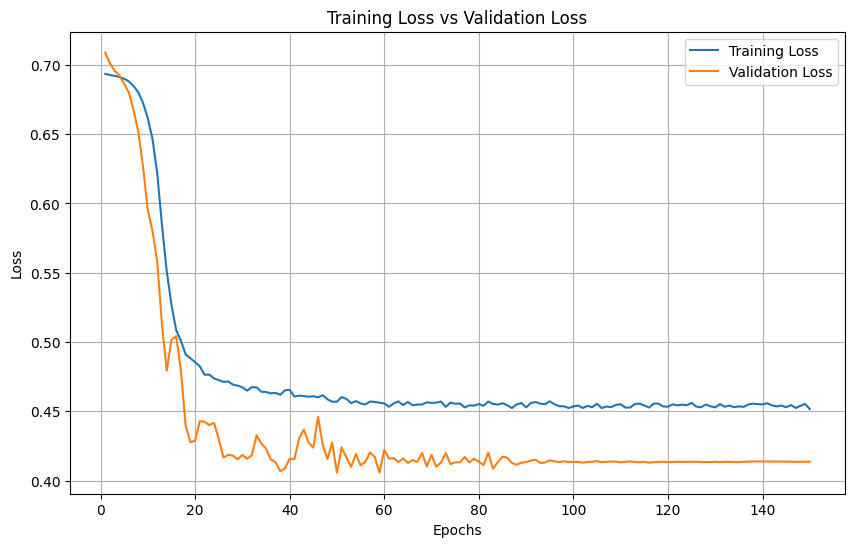

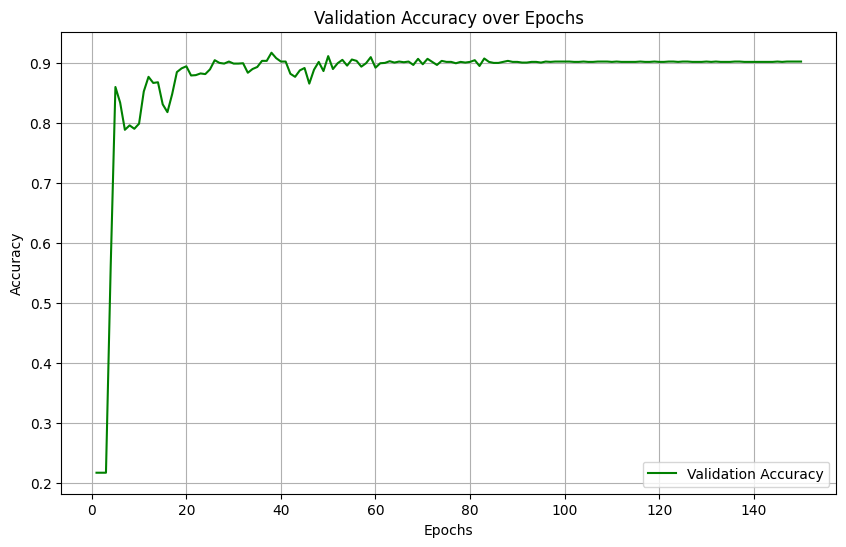

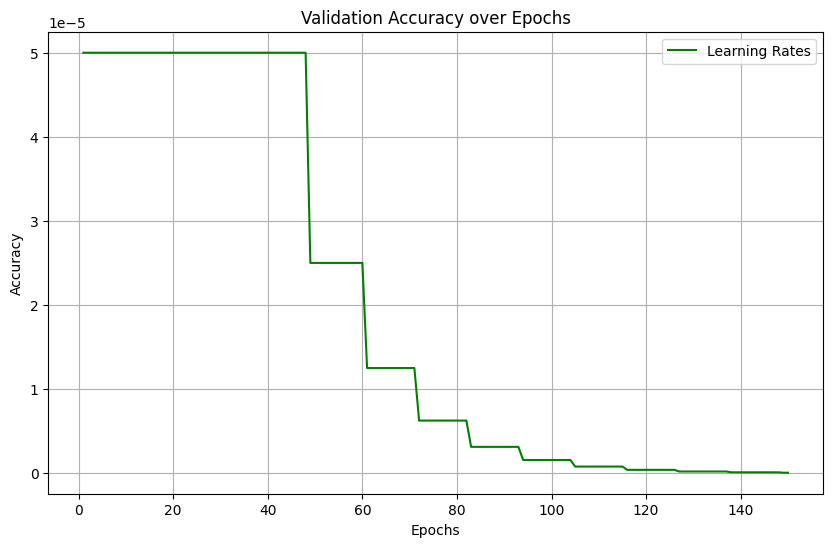

Model for bin 1 saved to 3DCholesterolModels-5A_exp1/model_bin_1.pth
1925 is length of subset grid
Training on bin 2
Bin 2, Epoch 1/150, Train Loss: 0.6931, Validation Loss: 0.6890, Validation Accuracy: 0.7825, Grad Norm: 0.0208, LR: 0.000050
Bin 2, Epoch 11/150, Train Loss: 0.6046, Validation Loss: 0.5225, Validation Accuracy: 0.8746, Grad Norm: 5.6859, LR: 0.000050
Bin 2, Epoch 21/150, Train Loss: 0.4776, Validation Loss: 0.4464, Validation Accuracy: 0.8791, Grad Norm: 3.4519, LR: 0.000050
Bin 2, Epoch 31/150, Train Loss: 0.4667, Validation Loss: 0.4551, Validation Accuracy: 0.8571, Grad Norm: 2.7645, LR: 0.000050
Bin 2, Epoch 41/150, Train Loss: 0.4618, Validation Loss: 0.4234, Validation Accuracy: 0.8944, Grad Norm: 3.0931, LR: 0.000050
Bin 2, Epoch 51/150, Train Loss: 0.4659, Validation Loss: 0.5068, Validation Accuracy: 0.8000, Grad Norm: 6.3337, LR: 0.000050
Bin 2, Epoch 61/150, Train Loss: 0.4556, Validation Loss: 0.4217, Validation Accuracy: 0.8898, Grad Norm: 3.2410, LR: 0.00

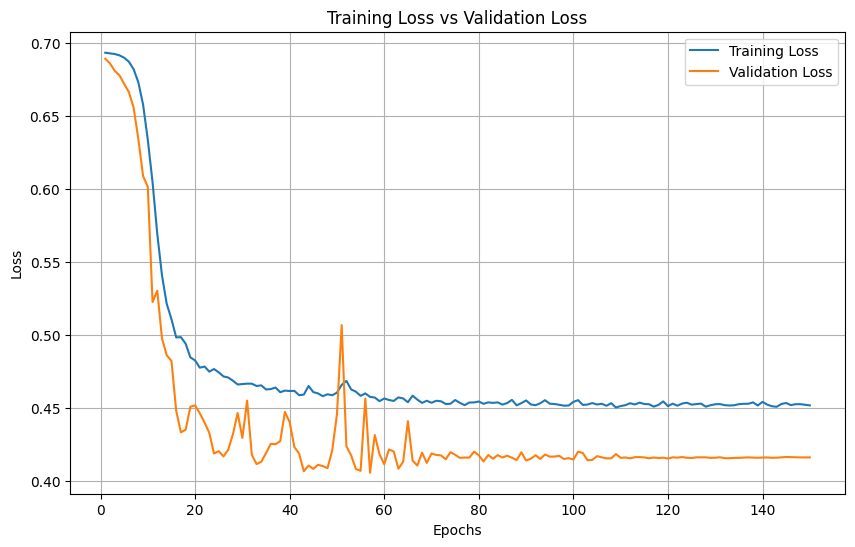

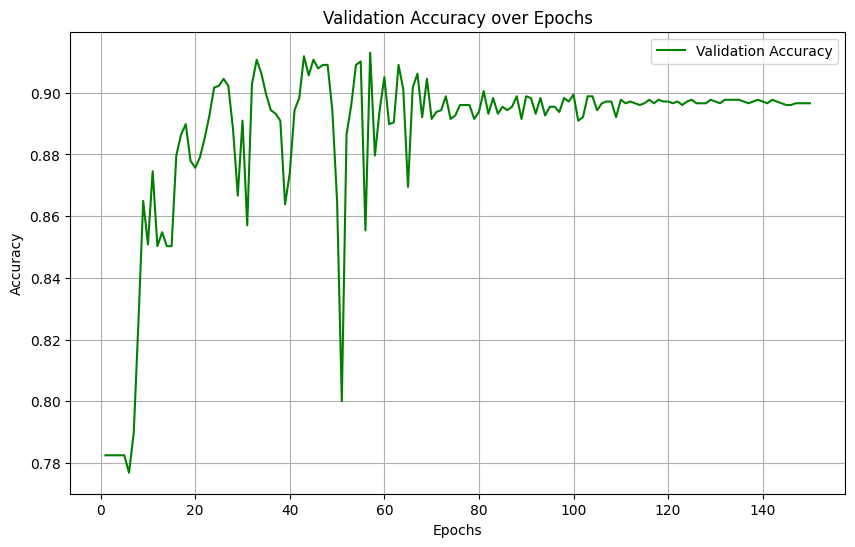

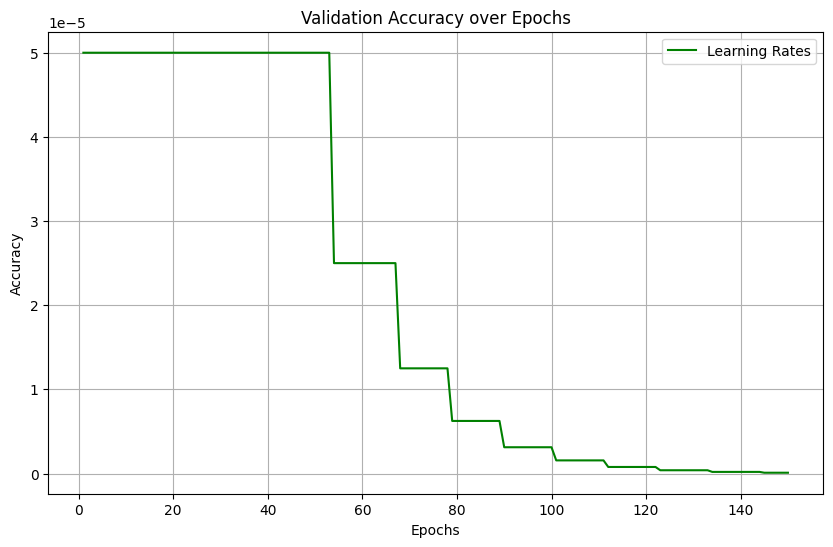

Model for bin 2 saved to 3DCholesterolModels-5A_exp1/model_bin_2.pth
1925 is length of subset grid
Training on bin 3
Bin 3, Epoch 1/150, Train Loss: 0.6931, Validation Loss: 0.6980, Validation Accuracy: 0.2175, Grad Norm: 0.0997, LR: 0.000050
Bin 3, Epoch 11/150, Train Loss: 0.6175, Validation Loss: 0.5663, Validation Accuracy: 0.8599, Grad Norm: 1.0644, LR: 0.000050
Bin 3, Epoch 21/150, Train Loss: 0.4678, Validation Loss: 0.4223, Validation Accuracy: 0.9017, Grad Norm: 0.3452, LR: 0.000050
Bin 3, Epoch 31/150, Train Loss: 0.4572, Validation Loss: 0.4267, Validation Accuracy: 0.8904, Grad Norm: 6.1531, LR: 0.000050
Bin 3, Epoch 41/150, Train Loss: 0.4519, Validation Loss: 0.4221, Validation Accuracy: 0.8938, Grad Norm: 1.8466, LR: 0.000025
Bin 3, Epoch 51/150, Train Loss: 0.4490, Validation Loss: 0.4251, Validation Accuracy: 0.8904, Grad Norm: 2.6583, LR: 0.000025
Bin 3, Epoch 61/150, Train Loss: 0.4476, Validation Loss: 0.4286, Validation Accuracy: 0.8825, Grad Norm: 4.7373, LR: 0.00

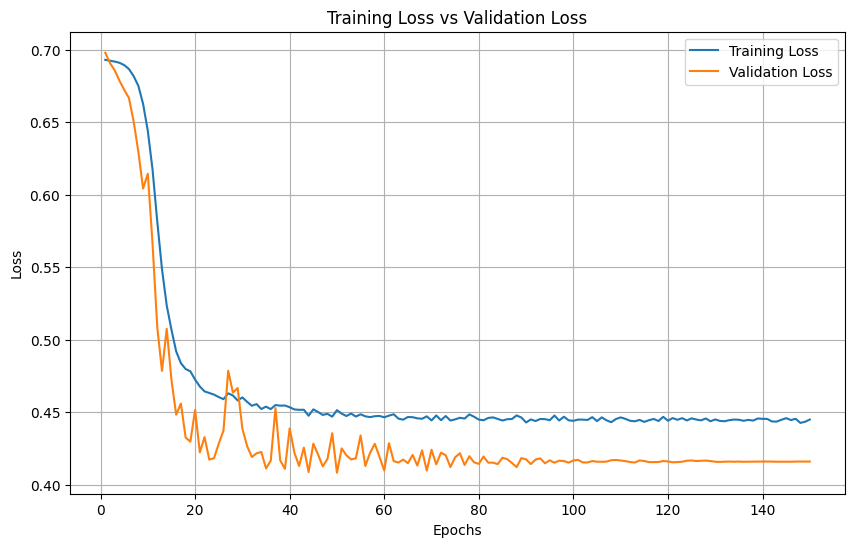

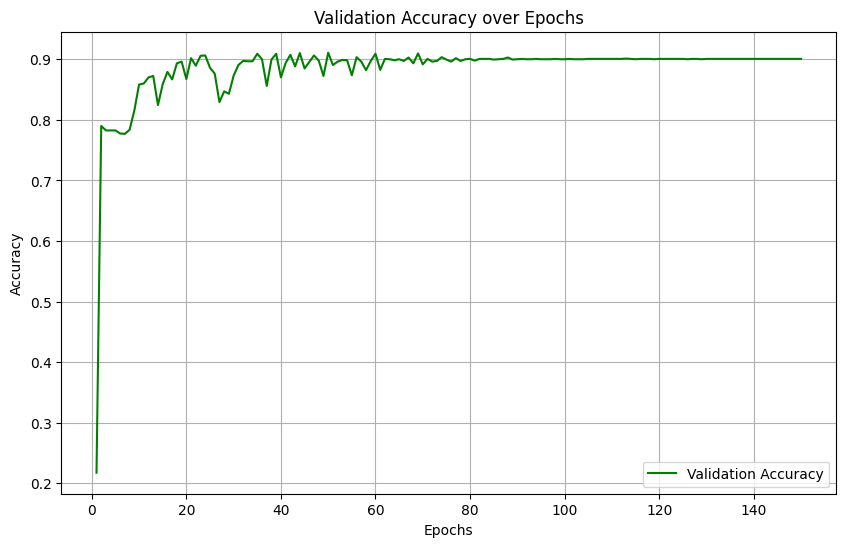

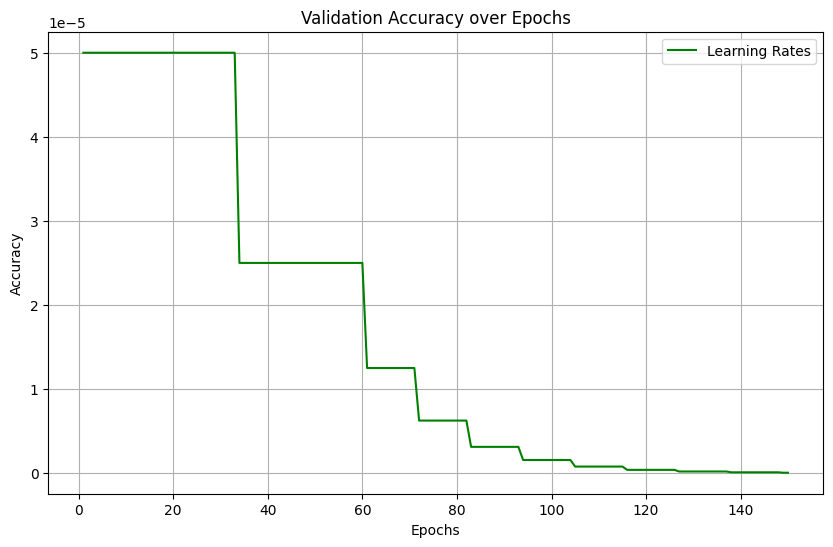

Model for bin 3 saved to 3DCholesterolModels-5A_exp1/model_bin_3.pth
1925 is length of subset grid
Training on bin 4
Bin 4, Epoch 1/150, Train Loss: 0.6931, Validation Loss: 0.6870, Validation Accuracy: 0.7825, Grad Norm: 0.0457, LR: 0.000050
Bin 4, Epoch 11/150, Train Loss: 0.6183, Validation Loss: 0.5556, Validation Accuracy: 0.8718, Grad Norm: 1.2977, LR: 0.000050
Bin 4, Epoch 21/150, Train Loss: 0.4801, Validation Loss: 0.4551, Validation Accuracy: 0.8627, Grad Norm: 3.6376, LR: 0.000050
Bin 4, Epoch 31/150, Train Loss: 0.4622, Validation Loss: 0.4189, Validation Accuracy: 0.8989, Grad Norm: 5.1696, LR: 0.000050
Bin 4, Epoch 41/150, Train Loss: 0.4559, Validation Loss: 0.4171, Validation Accuracy: 0.8994, Grad Norm: 4.1565, LR: 0.000050
Bin 4, Epoch 51/150, Train Loss: 0.4569, Validation Loss: 0.4253, Validation Accuracy: 0.8870, Grad Norm: 4.6293, LR: 0.000050
Bin 4, Epoch 61/150, Train Loss: 0.4531, Validation Loss: 0.4049, Validation Accuracy: 0.9136, Grad Norm: 0.7350, LR: 0.00

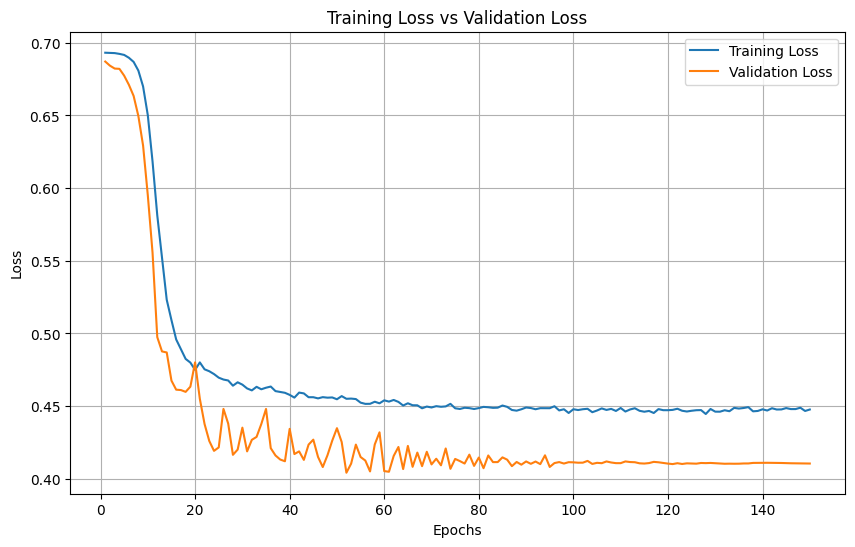

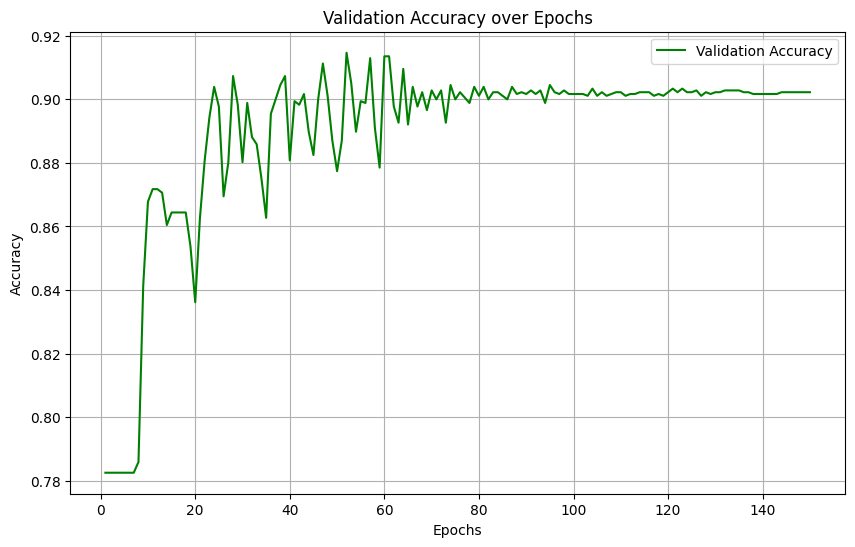

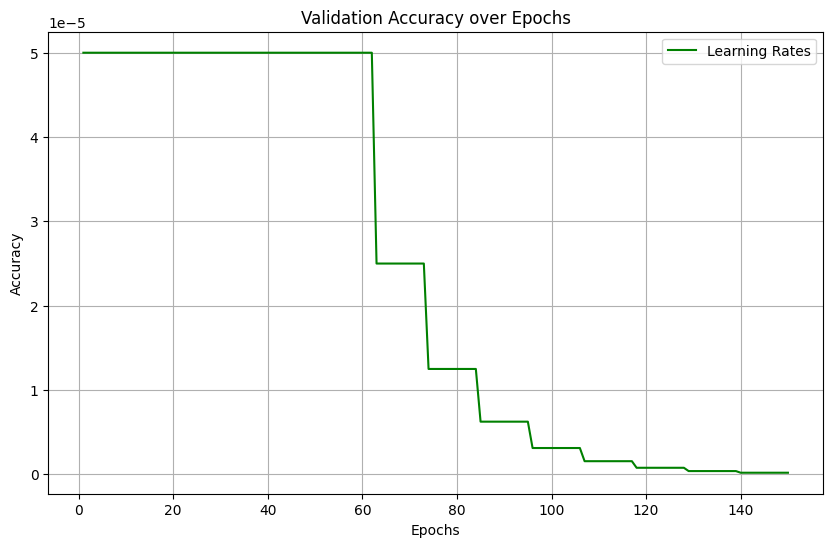

Model for bin 4 saved to 3DCholesterolModels-5A_exp1/model_bin_4.pth
1925 is length of subset grid
Training on bin 5
Bin 5, Epoch 1/150, Train Loss: 0.6931, Validation Loss: 0.6847, Validation Accuracy: 0.7825, Grad Norm: 0.0116, LR: 0.000050
Bin 5, Epoch 11/150, Train Loss: 0.6125, Validation Loss: 0.5623, Validation Accuracy: 0.8542, Grad Norm: 4.0684, LR: 0.000050
Bin 5, Epoch 21/150, Train Loss: 0.4768, Validation Loss: 0.4608, Validation Accuracy: 0.8610, Grad Norm: 1.6432, LR: 0.000050
Bin 5, Epoch 31/150, Train Loss: 0.4624, Validation Loss: 0.4195, Validation Accuracy: 0.9034, Grad Norm: 3.7645, LR: 0.000050
Bin 5, Epoch 41/150, Train Loss: 0.4543, Validation Loss: 0.4150, Validation Accuracy: 0.9062, Grad Norm: 0.6312, LR: 0.000050
Bin 5, Epoch 51/150, Train Loss: 0.4512, Validation Loss: 0.4299, Validation Accuracy: 0.8831, Grad Norm: 6.2036, LR: 0.000025
Bin 5, Epoch 61/150, Train Loss: 0.4470, Validation Loss: 0.4186, Validation Accuracy: 0.8966, Grad Norm: 3.5486, LR: 0.00

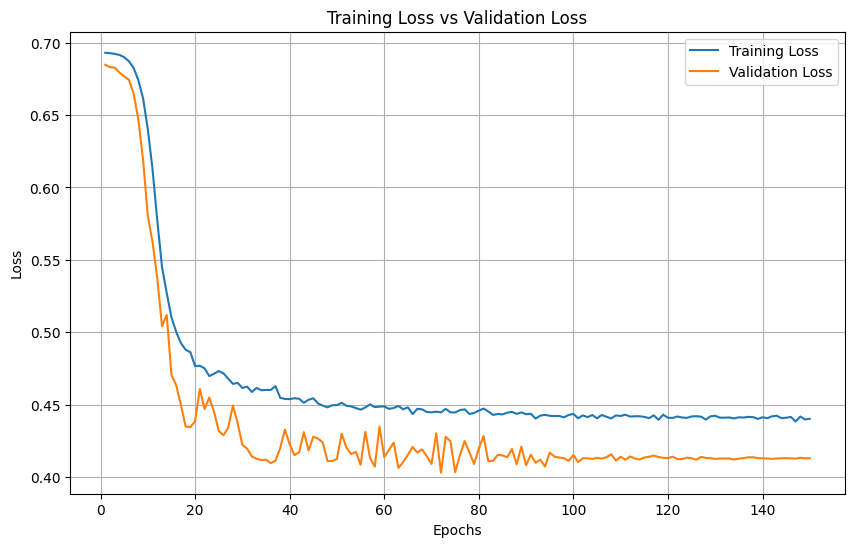

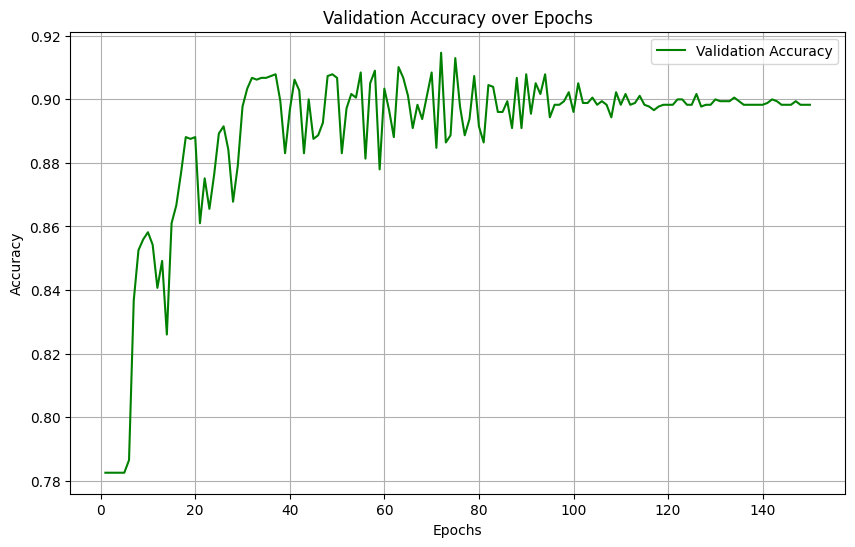

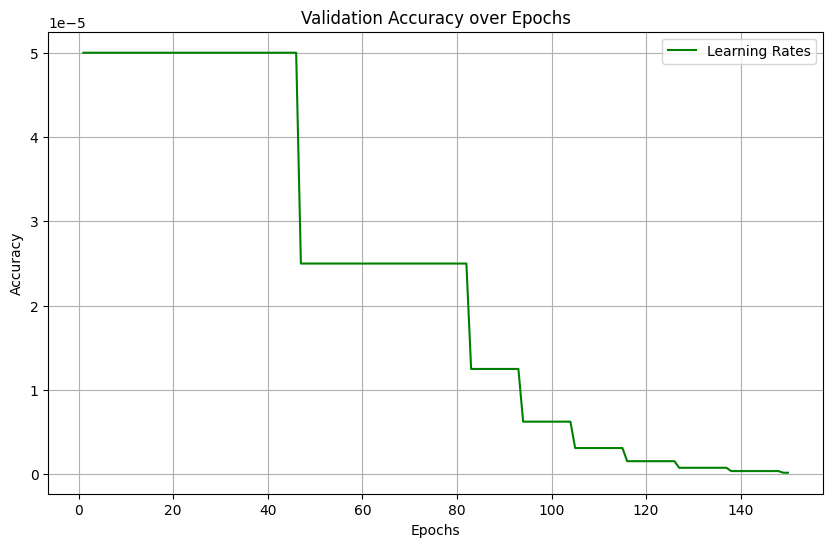

Model for bin 5 saved to 3DCholesterolModels-5A_exp1/model_bin_5.pth
1925 is length of subset grid
Training on bin 6
Bin 6, Epoch 1/150, Train Loss: 0.6932, Validation Loss: 0.7000, Validation Accuracy: 0.2175, Grad Norm: 0.0458, LR: 0.000050
Bin 6, Epoch 11/150, Train Loss: 0.6532, Validation Loss: 0.5921, Validation Accuracy: 0.8463, Grad Norm: 1.1130, LR: 0.000050
Bin 6, Epoch 21/150, Train Loss: 0.4791, Validation Loss: 0.4537, Validation Accuracy: 0.8706, Grad Norm: 6.2906, LR: 0.000050
Bin 6, Epoch 31/150, Train Loss: 0.4654, Validation Loss: 0.4150, Validation Accuracy: 0.9051, Grad Norm: 6.3117, LR: 0.000050
Bin 6, Epoch 41/150, Train Loss: 0.4563, Validation Loss: 0.4327, Validation Accuracy: 0.8842, Grad Norm: 4.5281, LR: 0.000050
Bin 6, Epoch 51/150, Train Loss: 0.4548, Validation Loss: 0.4121, Validation Accuracy: 0.9034, Grad Norm: 0.9826, LR: 0.000050
Bin 6, Epoch 61/150, Train Loss: 0.4487, Validation Loss: 0.4128, Validation Accuracy: 0.9040, Grad Norm: 4.8705, LR: 0.00

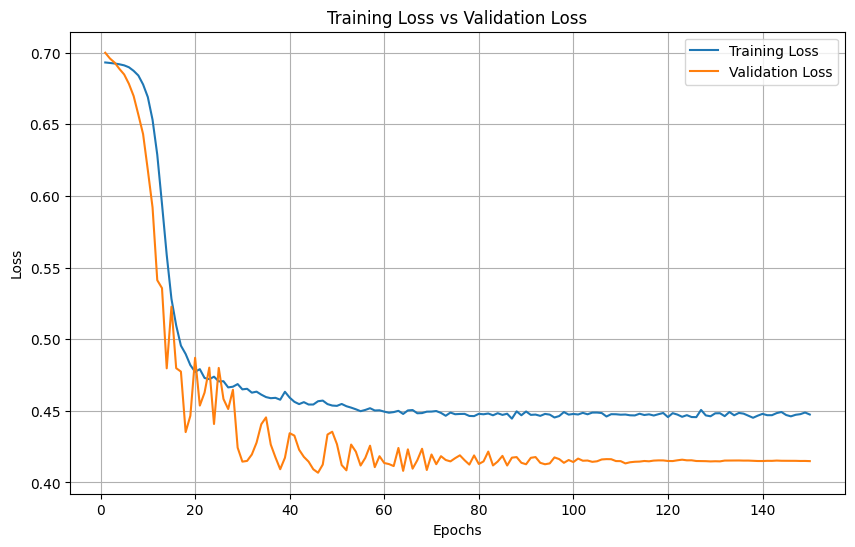

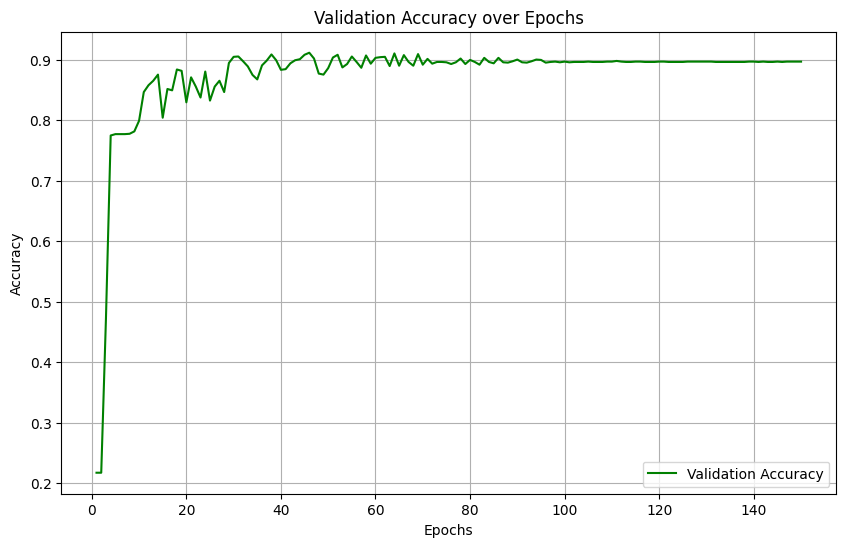

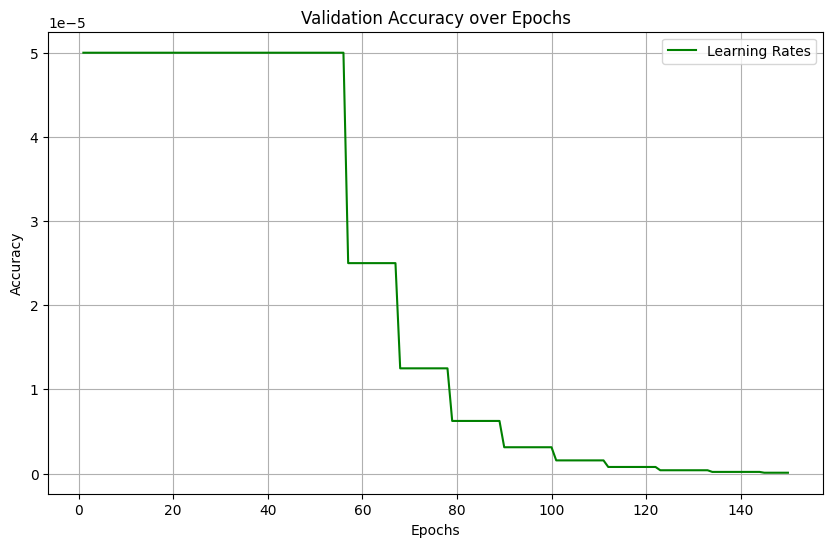

Model for bin 6 saved to 3DCholesterolModels-5A_exp1/model_bin_6.pth
1925 is length of subset grid
Training on bin 7
Bin 7, Epoch 1/150, Train Loss: 0.6929, Validation Loss: 0.6890, Validation Accuracy: 0.7825, Grad Norm: 0.0259, LR: 0.000050
Bin 7, Epoch 11/150, Train Loss: 0.5654, Validation Loss: 0.4803, Validation Accuracy: 0.8695, Grad Norm: 0.8204, LR: 0.000050
Bin 7, Epoch 21/150, Train Loss: 0.4655, Validation Loss: 0.4275, Validation Accuracy: 0.8949, Grad Norm: 0.5649, LR: 0.000050
Bin 7, Epoch 31/150, Train Loss: 0.4551, Validation Loss: 0.4266, Validation Accuracy: 0.8887, Grad Norm: 1.6400, LR: 0.000050
Bin 7, Epoch 41/150, Train Loss: 0.4516, Validation Loss: 0.4240, Validation Accuracy: 0.8887, Grad Norm: 6.4068, LR: 0.000050
Bin 7, Epoch 51/150, Train Loss: 0.4488, Validation Loss: 0.4263, Validation Accuracy: 0.8842, Grad Norm: 1.5604, LR: 0.000025
Bin 7, Epoch 61/150, Train Loss: 0.4472, Validation Loss: 0.4165, Validation Accuracy: 0.8960, Grad Norm: 4.0208, LR: 0.00

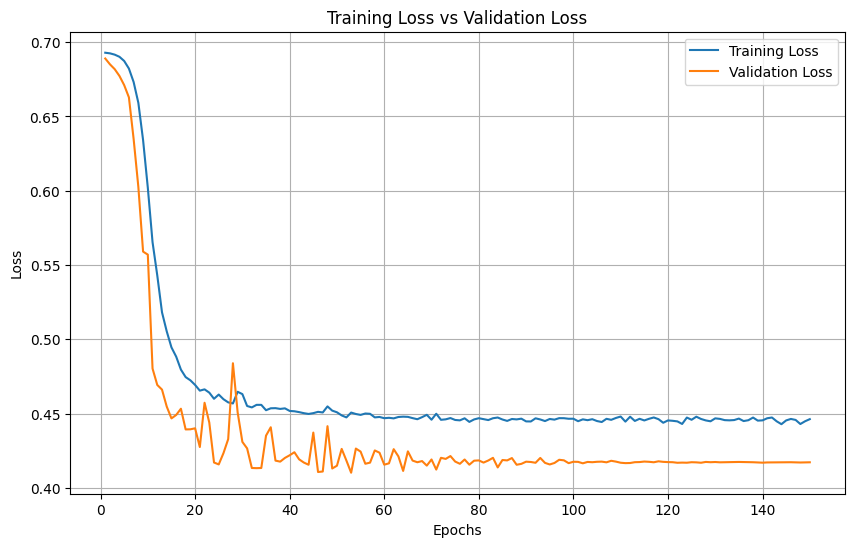

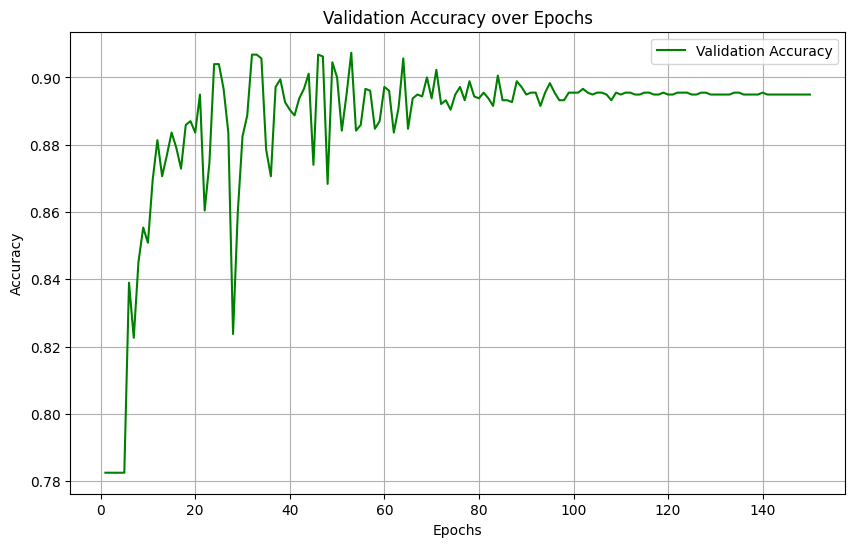

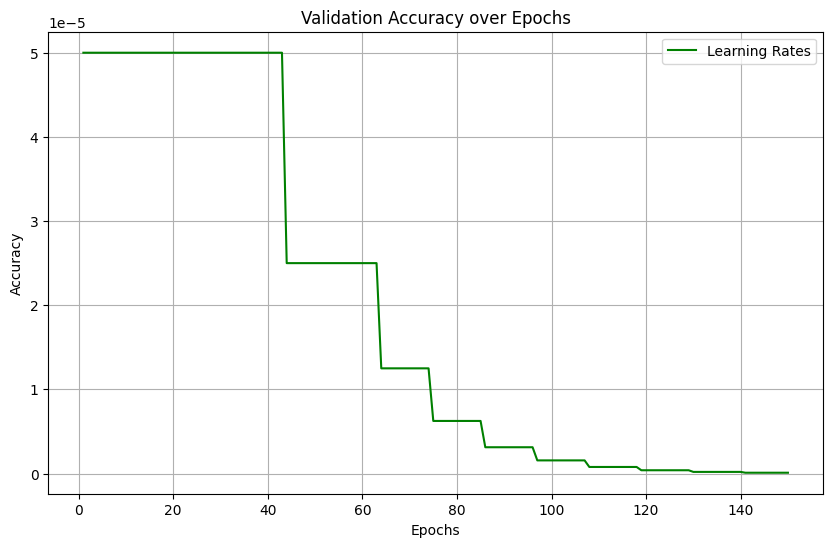

Model for bin 7 saved to 3DCholesterolModels-5A_exp1/model_bin_7.pth
1925 is length of subset grid
Training on bin 8
Bin 8, Epoch 1/150, Train Loss: 0.6930, Validation Loss: 0.6887, Validation Accuracy: 0.7825, Grad Norm: 0.0836, LR: 0.000050
Bin 8, Epoch 11/150, Train Loss: 0.5910, Validation Loss: 0.5773, Validation Accuracy: 0.7938, Grad Norm: 2.2436, LR: 0.000050
Bin 8, Epoch 21/150, Train Loss: 0.4750, Validation Loss: 0.4449, Validation Accuracy: 0.8797, Grad Norm: 3.6136, LR: 0.000050
Bin 8, Epoch 31/150, Train Loss: 0.4584, Validation Loss: 0.4312, Validation Accuracy: 0.8847, Grad Norm: 0.3697, LR: 0.000050
Bin 8, Epoch 41/150, Train Loss: 0.4527, Validation Loss: 0.4117, Validation Accuracy: 0.9073, Grad Norm: 5.5246, LR: 0.000050
Bin 8, Epoch 51/150, Train Loss: 0.4494, Validation Loss: 0.4233, Validation Accuracy: 0.8927, Grad Norm: 3.2019, LR: 0.000050
Bin 8, Epoch 61/150, Train Loss: 0.4486, Validation Loss: 0.4259, Validation Accuracy: 0.8876, Grad Norm: 4.4460, LR: 0.00

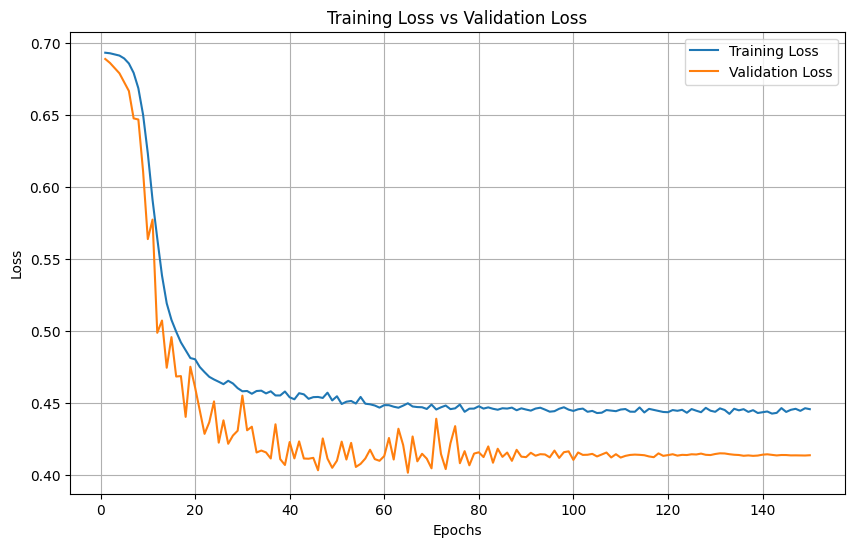

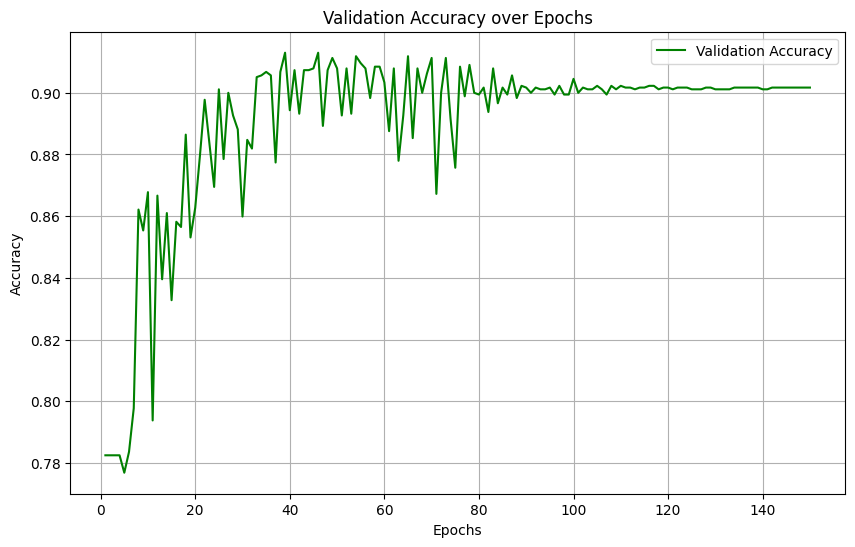

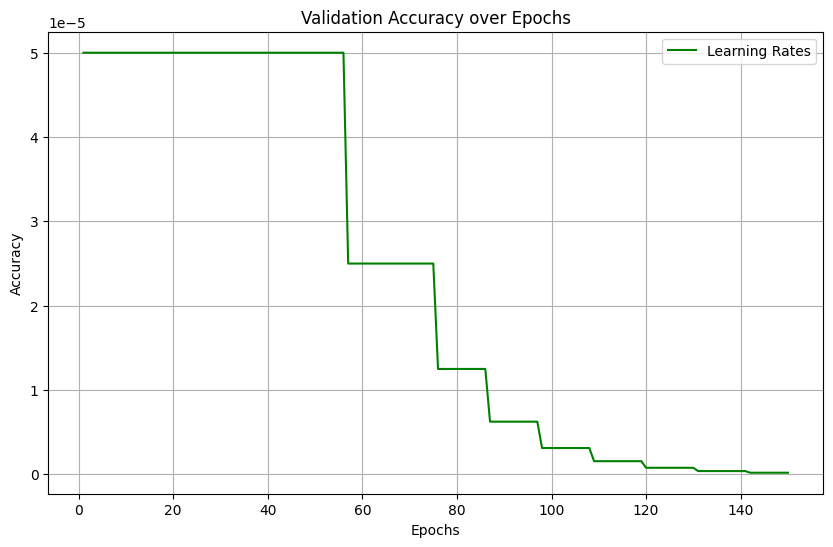

Model for bin 8 saved to 3DCholesterolModels-5A_exp1/model_bin_8.pth
1925 is length of subset grid
Training on bin 9
Bin 9, Epoch 1/150, Train Loss: 0.6932, Validation Loss: 0.7010, Validation Accuracy: 0.2175, Grad Norm: 0.0393, LR: 0.000050
Bin 9, Epoch 11/150, Train Loss: 0.6142, Validation Loss: 0.5479, Validation Accuracy: 0.8785, Grad Norm: 1.1536, LR: 0.000050
Bin 9, Epoch 21/150, Train Loss: 0.4707, Validation Loss: 0.4305, Validation Accuracy: 0.8977, Grad Norm: 2.3920, LR: 0.000050
Bin 9, Epoch 31/150, Train Loss: 0.4588, Validation Loss: 0.4627, Validation Accuracy: 0.8525, Grad Norm: 6.3276, LR: 0.000050
Bin 9, Epoch 41/150, Train Loss: 0.4498, Validation Loss: 0.4188, Validation Accuracy: 0.8983, Grad Norm: 2.7672, LR: 0.000050
Bin 9, Epoch 51/150, Train Loss: 0.4485, Validation Loss: 0.4214, Validation Accuracy: 0.8898, Grad Norm: 4.3931, LR: 0.000050
Bin 9, Epoch 61/150, Train Loss: 0.4429, Validation Loss: 0.4367, Validation Accuracy: 0.8757, Grad Norm: 0.8506, LR: 0.00

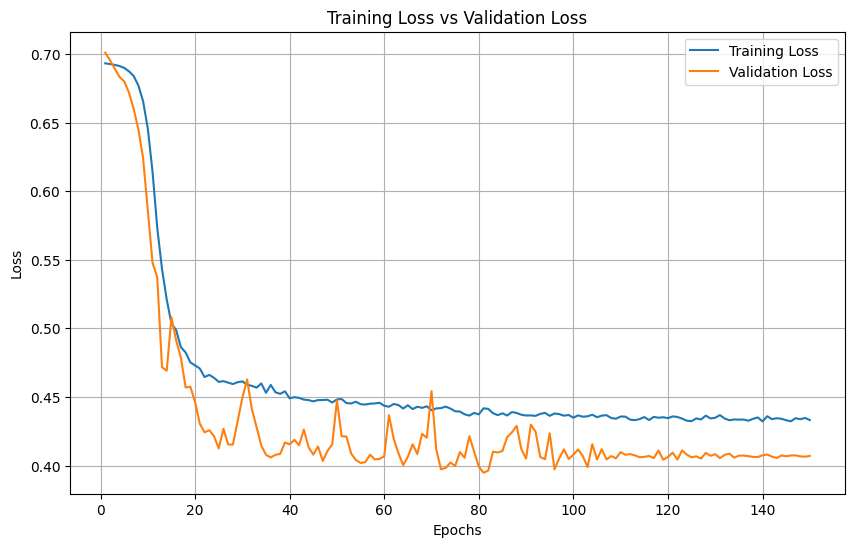

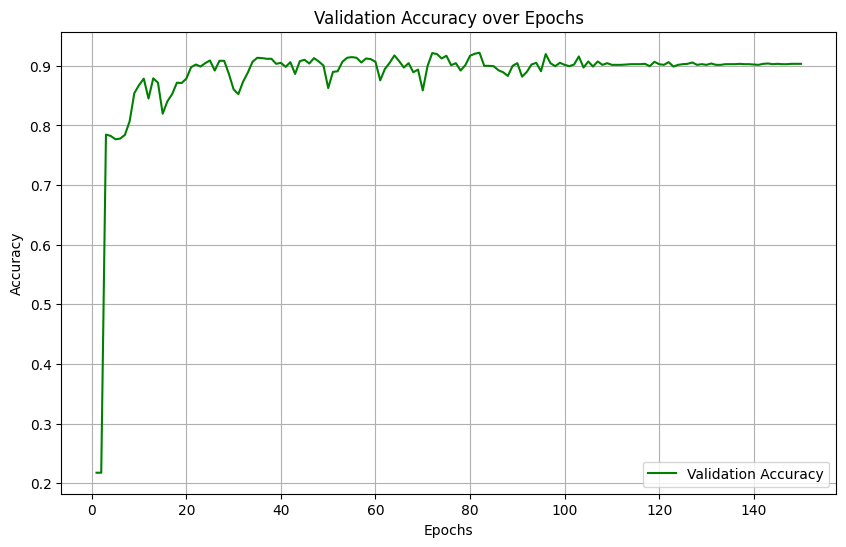

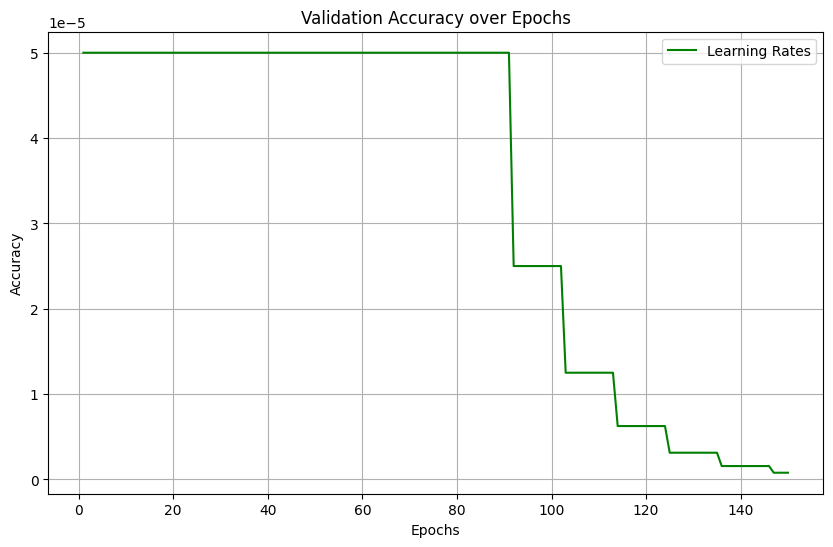

Model for bin 9 saved to 3DCholesterolModels-5A_exp1/model_bin_9.pth
1925 is length of subset grid
Training on bin 10
Bin 10, Epoch 1/150, Train Loss: 0.6930, Validation Loss: 0.6876, Validation Accuracy: 0.7825, Grad Norm: 0.0139, LR: 0.000050
Bin 10, Epoch 11/150, Train Loss: 0.5836, Validation Loss: 0.4989, Validation Accuracy: 0.8667, Grad Norm: 1.6947, LR: 0.000050
Bin 10, Epoch 21/150, Train Loss: 0.4677, Validation Loss: 0.4464, Validation Accuracy: 0.8768, Grad Norm: 3.4032, LR: 0.000050
Bin 10, Epoch 31/150, Train Loss: 0.4554, Validation Loss: 0.4308, Validation Accuracy: 0.8825, Grad Norm: 6.1222, LR: 0.000050
Bin 10, Epoch 41/150, Train Loss: 0.4494, Validation Loss: 0.4138, Validation Accuracy: 0.9045, Grad Norm: 0.8307, LR: 0.000050
Bin 10, Epoch 51/150, Train Loss: 0.4476, Validation Loss: 0.4230, Validation Accuracy: 0.8870, Grad Norm: 0.9291, LR: 0.000025
Bin 10, Epoch 61/150, Train Loss: 0.4450, Validation Loss: 0.4203, Validation Accuracy: 0.8910, Grad Norm: 3.1490, 

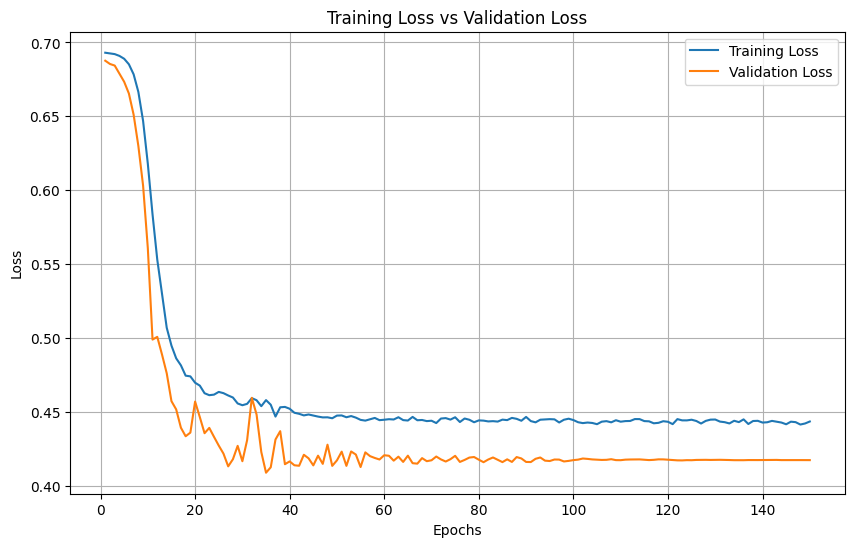

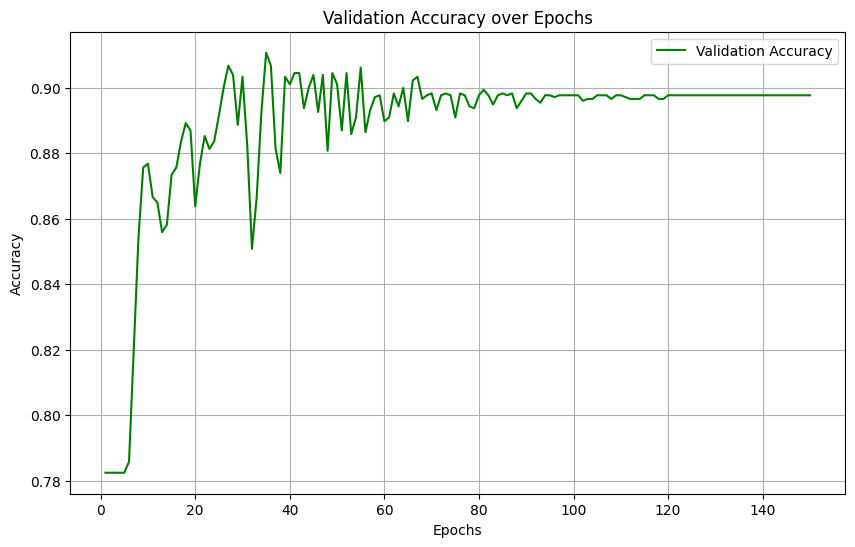

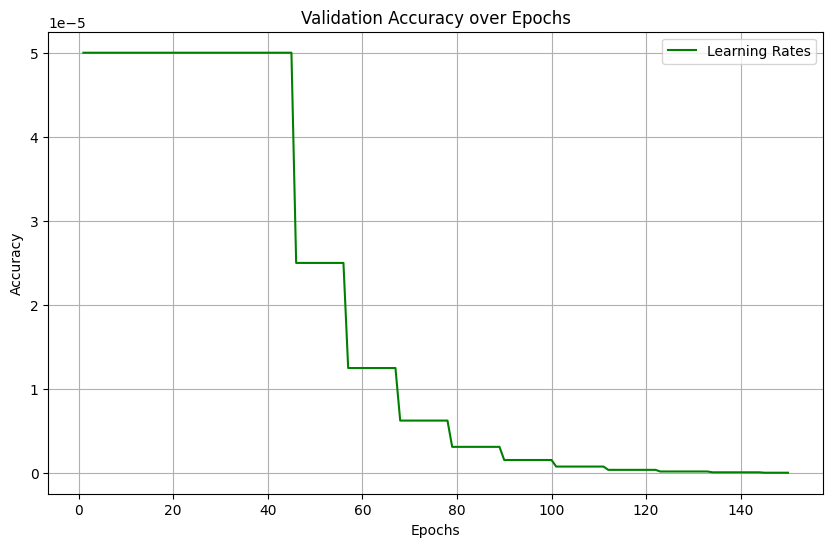

Model for bin 10 saved to 3DCholesterolModels-5A_exp1/model_bin_10.pth
1925 is length of subset grid
Training on bin 11
Bin 11, Epoch 1/150, Train Loss: 0.6930, Validation Loss: 0.6921, Validation Accuracy: 0.7751, Grad Norm: 0.0643, LR: 0.000050
Bin 11, Epoch 11/150, Train Loss: 0.5798, Validation Loss: 0.5353, Validation Accuracy: 0.8446, Grad Norm: 3.0180, LR: 0.000050
Bin 11, Epoch 21/150, Train Loss: 0.4717, Validation Loss: 0.4734, Validation Accuracy: 0.8452, Grad Norm: 0.9874, LR: 0.000050
Bin 11, Epoch 31/150, Train Loss: 0.4669, Validation Loss: 0.4450, Validation Accuracy: 0.8740, Grad Norm: 6.3154, LR: 0.000050
Bin 11, Epoch 41/150, Train Loss: 0.4543, Validation Loss: 0.4317, Validation Accuracy: 0.8853, Grad Norm: 0.3589, LR: 0.000025
Bin 11, Epoch 51/150, Train Loss: 0.4517, Validation Loss: 0.4190, Validation Accuracy: 0.9011, Grad Norm: 1.2446, LR: 0.000025
Bin 11, Epoch 61/150, Train Loss: 0.4494, Validation Loss: 0.4158, Validation Accuracy: 0.9028, Grad Norm: 5.1249

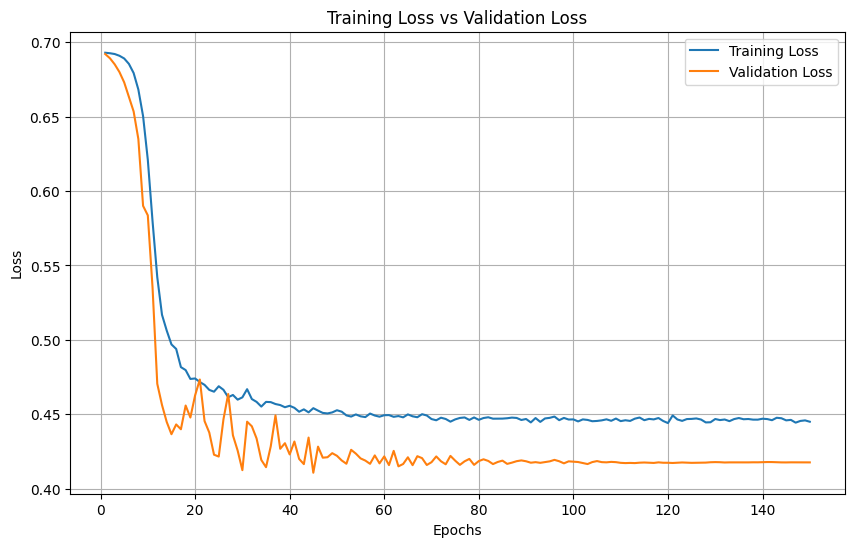

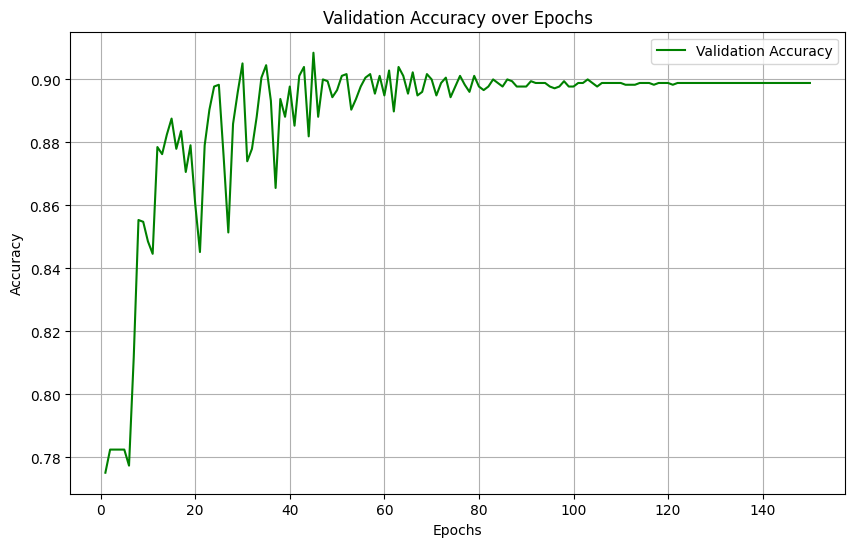

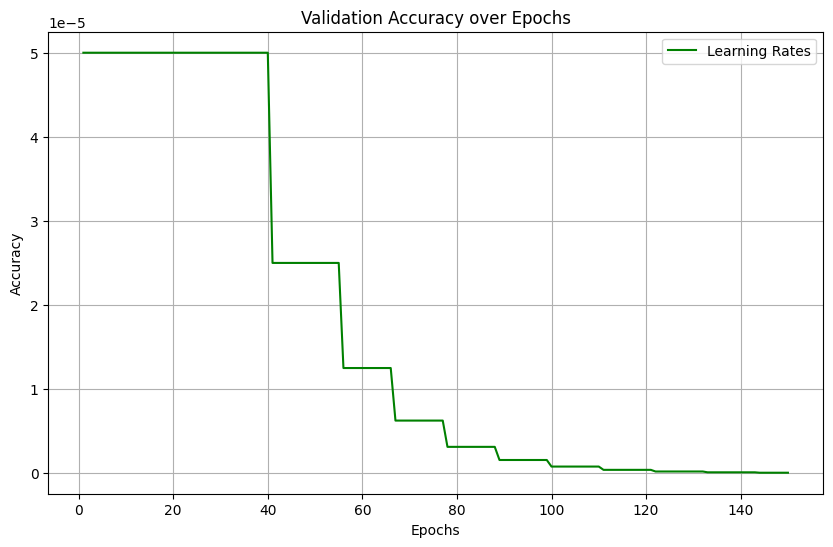

Model for bin 11 saved to 3DCholesterolModels-5A_exp1/model_bin_11.pth
1925 is length of subset grid
Training on bin 12
Bin 12, Epoch 1/150, Train Loss: 0.6936, Validation Loss: 0.7104, Validation Accuracy: 0.2175, Grad Norm: 0.0376, LR: 0.000050
Bin 12, Epoch 11/150, Train Loss: 0.6527, Validation Loss: 0.5849, Validation Accuracy: 0.8356, Grad Norm: 0.6064, LR: 0.000050
Bin 12, Epoch 21/150, Train Loss: 0.4750, Validation Loss: 0.4248, Validation Accuracy: 0.8983, Grad Norm: 6.2769, LR: 0.000050
Bin 12, Epoch 31/150, Train Loss: 0.4576, Validation Loss: 0.4527, Validation Accuracy: 0.8582, Grad Norm: 3.1963, LR: 0.000050
Bin 12, Epoch 41/150, Train Loss: 0.4521, Validation Loss: 0.4338, Validation Accuracy: 0.8819, Grad Norm: 2.8406, LR: 0.000050
Bin 12, Epoch 51/150, Train Loss: 0.4465, Validation Loss: 0.4028, Validation Accuracy: 0.9136, Grad Norm: 1.9423, LR: 0.000050
Bin 12, Epoch 61/150, Train Loss: 0.4465, Validation Loss: 0.3990, Validation Accuracy: 0.9164, Grad Norm: 1.3343

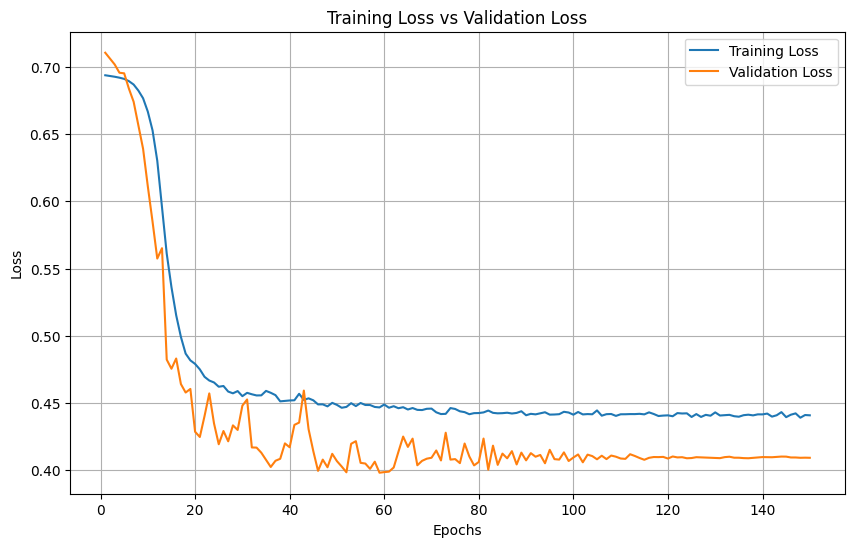

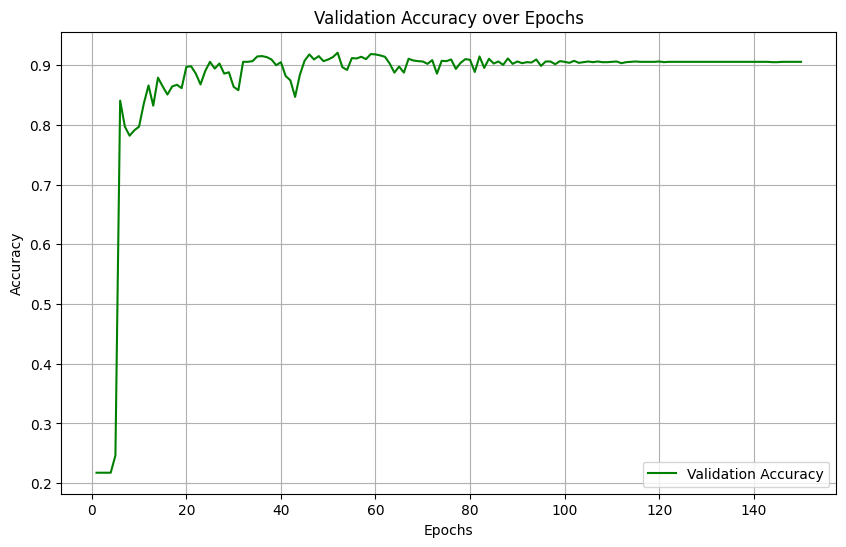

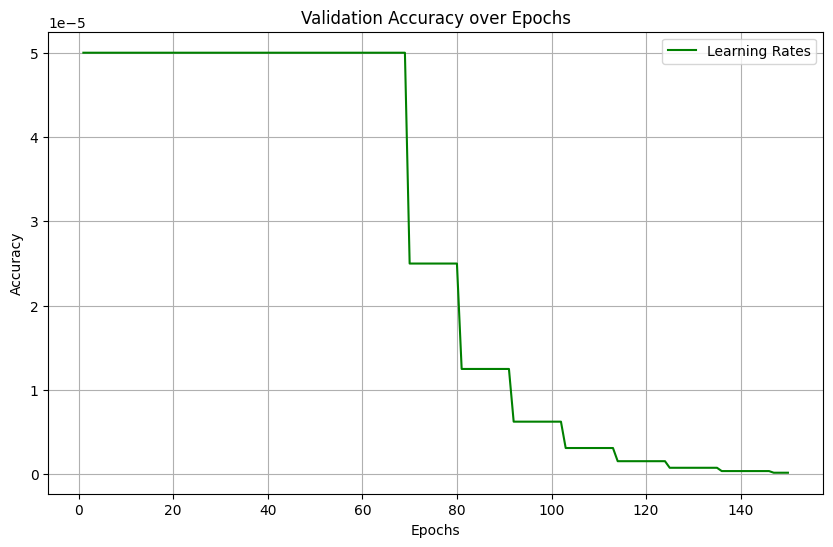

Model for bin 12 saved to 3DCholesterolModels-5A_exp1/model_bin_12.pth
1925 is length of subset grid
Training on bin 13
Bin 13, Epoch 1/150, Train Loss: 0.6930, Validation Loss: 0.6970, Validation Accuracy: 0.2175, Grad Norm: 0.0902, LR: 0.000050
Bin 13, Epoch 11/150, Train Loss: 0.6282, Validation Loss: 0.5473, Validation Accuracy: 0.8655, Grad Norm: 1.0041, LR: 0.000050
Bin 13, Epoch 21/150, Train Loss: 0.4633, Validation Loss: 0.4313, Validation Accuracy: 0.8881, Grad Norm: 6.4827, LR: 0.000050
Bin 13, Epoch 31/150, Train Loss: 0.4543, Validation Loss: 0.4147, Validation Accuracy: 0.9034, Grad Norm: 2.5591, LR: 0.000050
Bin 13, Epoch 41/150, Train Loss: 0.4453, Validation Loss: 0.4155, Validation Accuracy: 0.9023, Grad Norm: 2.1564, LR: 0.000025
Bin 13, Epoch 51/150, Train Loss: 0.4453, Validation Loss: 0.4194, Validation Accuracy: 0.8949, Grad Norm: 6.3731, LR: 0.000025
Bin 13, Epoch 61/150, Train Loss: 0.4437, Validation Loss: 0.4179, Validation Accuracy: 0.8960, Grad Norm: 1.3607

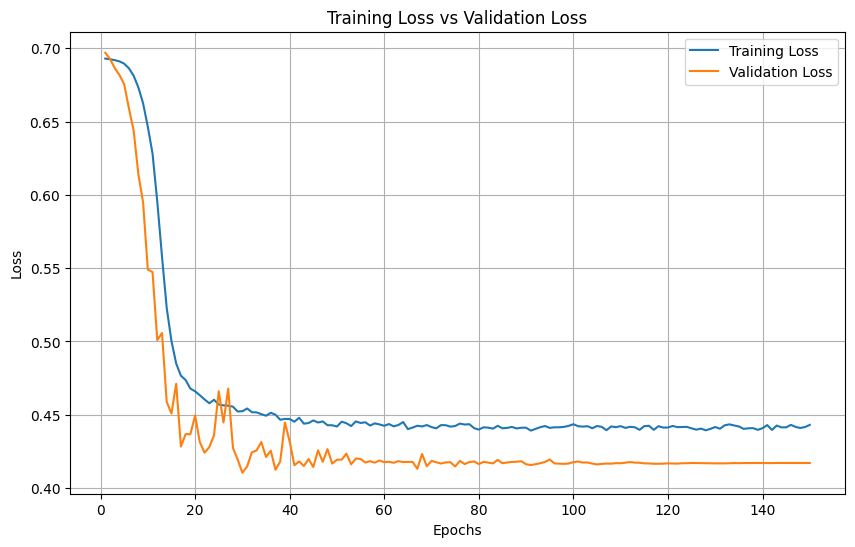

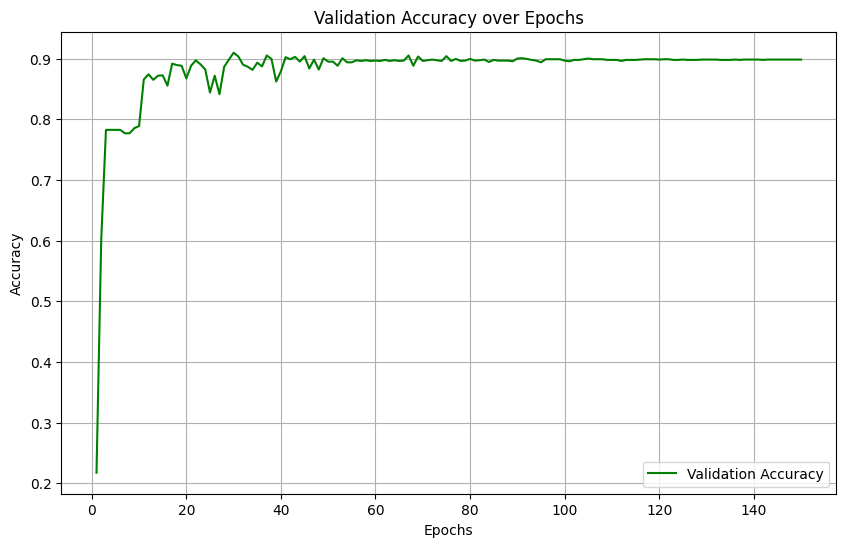

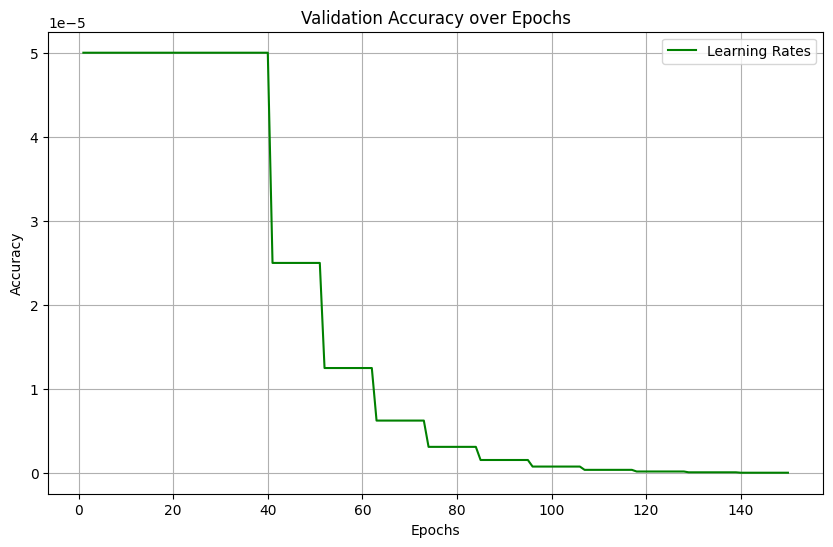

Model for bin 13 saved to 3DCholesterolModels-5A_exp1/model_bin_13.pth
1925 is length of subset grid
Training on bin 14
Bin 14, Epoch 1/150, Train Loss: 0.6932, Validation Loss: 0.6991, Validation Accuracy: 0.2175, Grad Norm: 0.0608, LR: 0.000050
Bin 14, Epoch 11/150, Train Loss: 0.6322, Validation Loss: 0.5915, Validation Accuracy: 0.8689, Grad Norm: 2.0250, LR: 0.000050
Bin 14, Epoch 21/150, Train Loss: 0.4718, Validation Loss: 0.4455, Validation Accuracy: 0.8746, Grad Norm: 0.7166, LR: 0.000050
Bin 14, Epoch 31/150, Train Loss: 0.4574, Validation Loss: 0.4330, Validation Accuracy: 0.8763, Grad Norm: 0.2818, LR: 0.000050
Bin 14, Epoch 41/150, Train Loss: 0.4542, Validation Loss: 0.4187, Validation Accuracy: 0.8955, Grad Norm: 5.8343, LR: 0.000050
Bin 14, Epoch 51/150, Train Loss: 0.4510, Validation Loss: 0.4056, Validation Accuracy: 0.9102, Grad Norm: 3.3272, LR: 0.000050
Bin 14, Epoch 61/150, Train Loss: 0.4520, Validation Loss: 0.4007, Validation Accuracy: 0.9147, Grad Norm: 2.5640

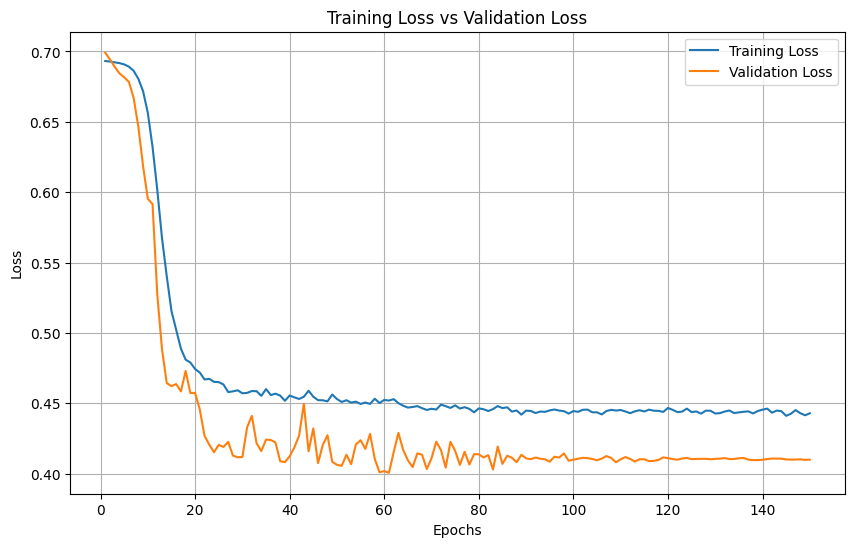

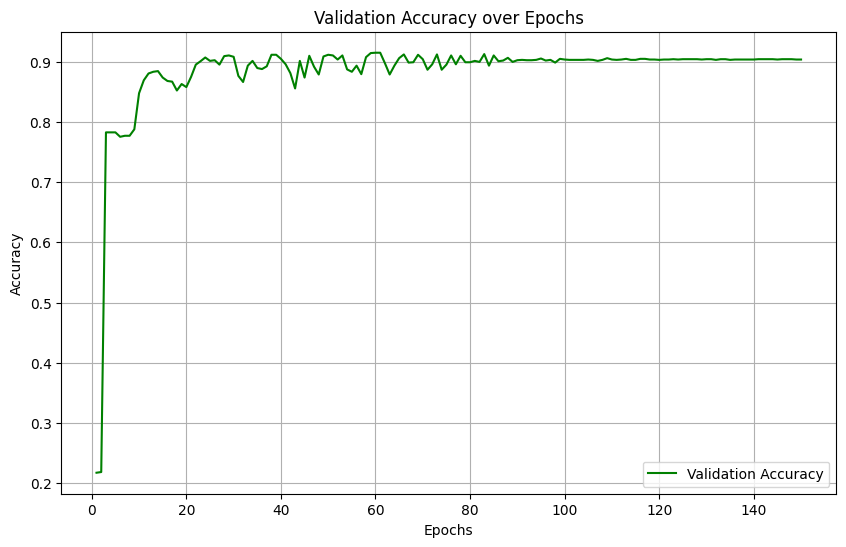

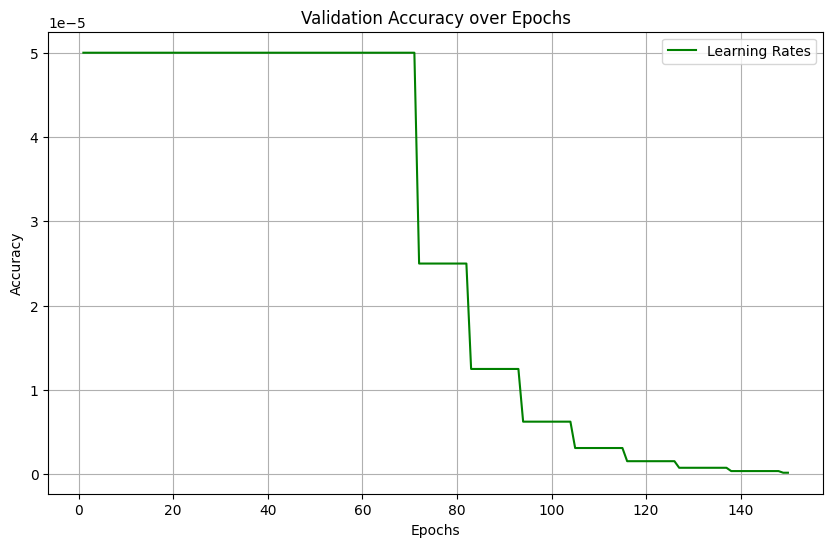

Model for bin 14 saved to 3DCholesterolModels-5A_exp1/model_bin_14.pth
1925 is length of subset grid
Training on bin 15
Bin 15, Epoch 1/150, Train Loss: 0.6932, Validation Loss: 0.7065, Validation Accuracy: 0.2175, Grad Norm: 0.0633, LR: 0.000050
Bin 15, Epoch 11/150, Train Loss: 0.5964, Validation Loss: 0.5312, Validation Accuracy: 0.8655, Grad Norm: 1.1782, LR: 0.000050
Bin 15, Epoch 21/150, Train Loss: 0.4666, Validation Loss: 0.4512, Validation Accuracy: 0.8627, Grad Norm: 0.3453, LR: 0.000050
Bin 15, Epoch 31/150, Train Loss: 0.4552, Validation Loss: 0.4289, Validation Accuracy: 0.8864, Grad Norm: 0.6482, LR: 0.000050
Bin 15, Epoch 41/150, Train Loss: 0.4527, Validation Loss: 0.4235, Validation Accuracy: 0.8910, Grad Norm: 4.0469, LR: 0.000025
Bin 15, Epoch 51/150, Train Loss: 0.4519, Validation Loss: 0.4164, Validation Accuracy: 0.8983, Grad Norm: 4.1517, LR: 0.000025
Bin 15, Epoch 61/150, Train Loss: 0.4514, Validation Loss: 0.4360, Validation Accuracy: 0.8718, Grad Norm: 6.3892

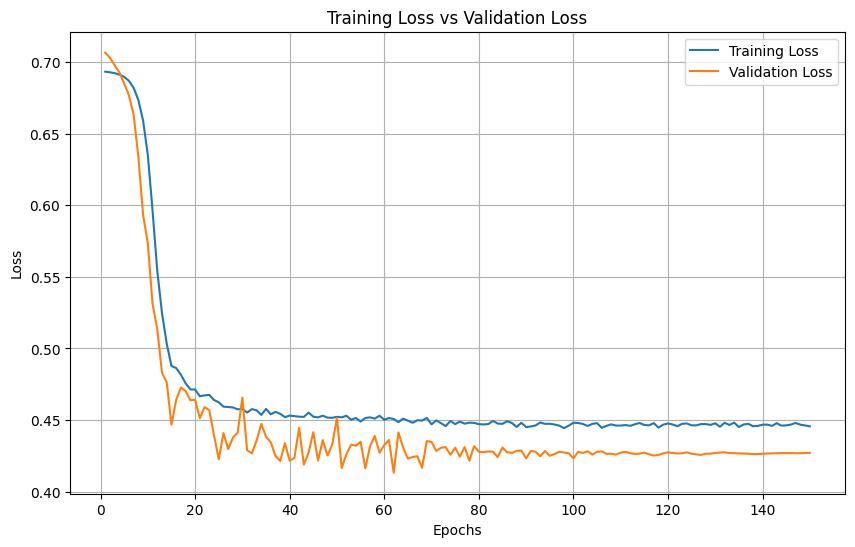

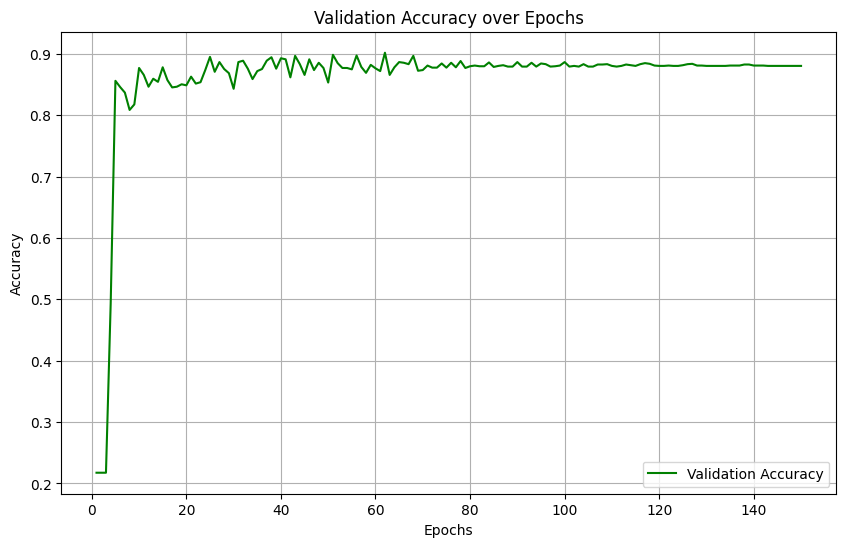

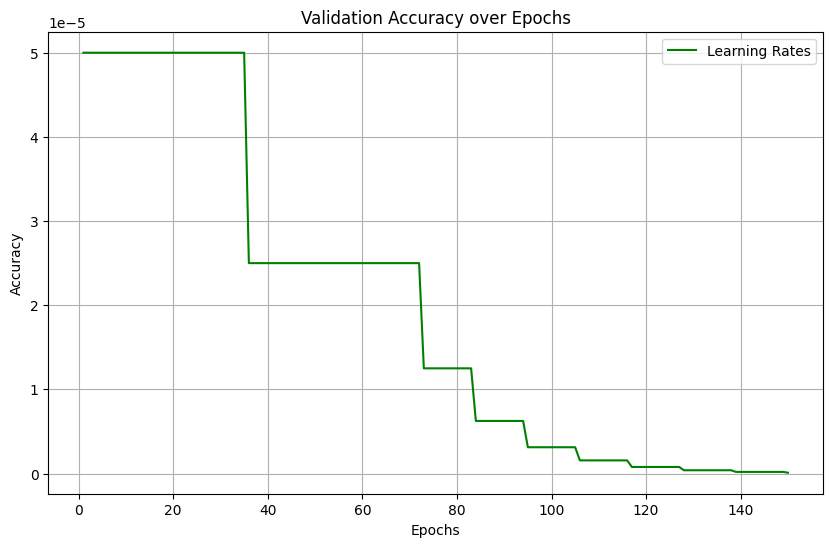

Model for bin 15 saved to 3DCholesterolModels-5A_exp1/model_bin_15.pth
1925 is length of subset grid
Training on bin 16
Bin 16, Epoch 1/150, Train Loss: 0.6931, Validation Loss: 0.6943, Validation Accuracy: 0.2175, Grad Norm: 0.0228, LR: 0.000050
Bin 16, Epoch 11/150, Train Loss: 0.6126, Validation Loss: 0.5286, Validation Accuracy: 0.8695, Grad Norm: 1.7069, LR: 0.000050
Bin 16, Epoch 21/150, Train Loss: 0.4832, Validation Loss: 0.4644, Validation Accuracy: 0.8537, Grad Norm: 0.4235, LR: 0.000050
Bin 16, Epoch 31/150, Train Loss: 0.4734, Validation Loss: 0.4466, Validation Accuracy: 0.8684, Grad Norm: 0.4925, LR: 0.000050
Bin 16, Epoch 41/150, Train Loss: 0.4686, Validation Loss: 0.4064, Validation Accuracy: 0.9102, Grad Norm: 5.6037, LR: 0.000050
Bin 16, Epoch 51/150, Train Loss: 0.4700, Validation Loss: 0.4382, Validation Accuracy: 0.8712, Grad Norm: 5.8430, LR: 0.000050
Bin 16, Epoch 61/150, Train Loss: 0.4602, Validation Loss: 0.4064, Validation Accuracy: 0.9096, Grad Norm: 2.1381

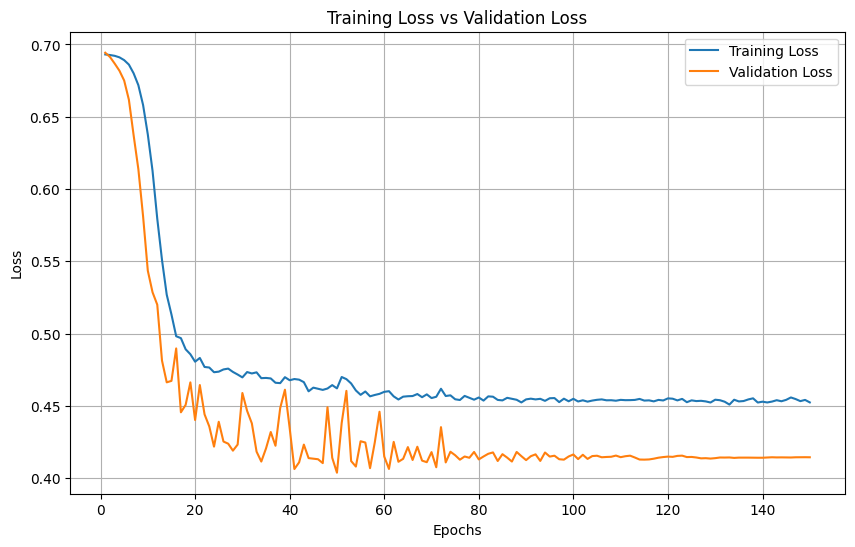

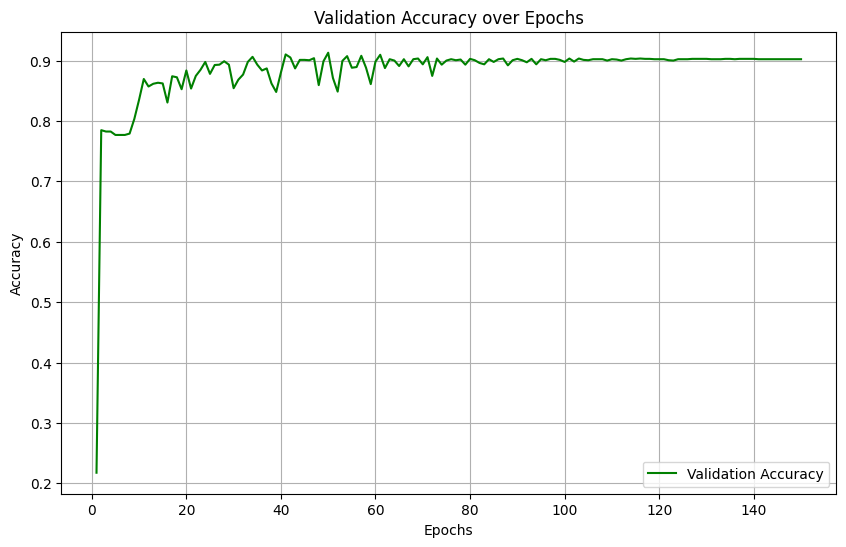

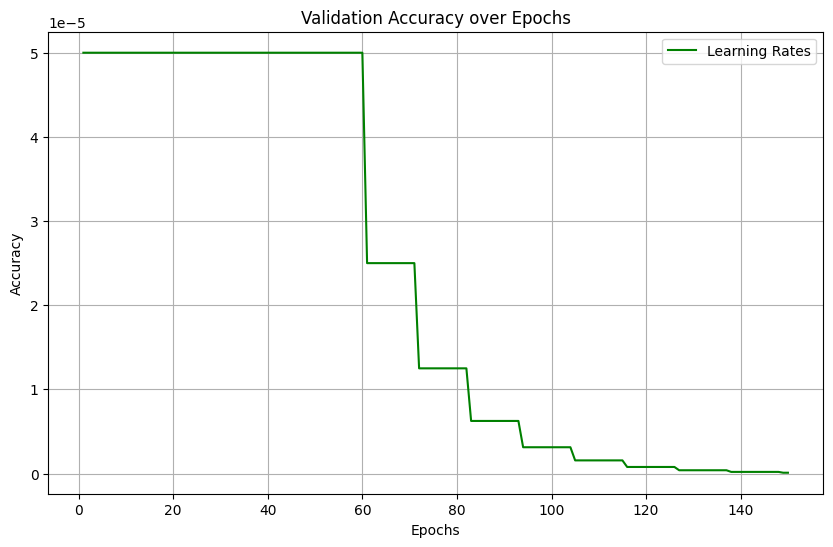

Model for bin 16 saved to 3DCholesterolModels-5A_exp1/model_bin_16.pth
1925 is length of subset grid
Training on bin 17
Bin 17, Epoch 1/150, Train Loss: 0.6932, Validation Loss: 0.6993, Validation Accuracy: 0.2175, Grad Norm: 0.0614, LR: 0.000050
Bin 17, Epoch 11/150, Train Loss: 0.5955, Validation Loss: 0.5352, Validation Accuracy: 0.8684, Grad Norm: 1.2794, LR: 0.000050
Bin 17, Epoch 21/150, Train Loss: 0.4715, Validation Loss: 0.4312, Validation Accuracy: 0.8887, Grad Norm: 2.7294, LR: 0.000050
Bin 17, Epoch 31/150, Train Loss: 0.4603, Validation Loss: 0.4500, Validation Accuracy: 0.8621, Grad Norm: 1.3442, LR: 0.000050
Bin 17, Epoch 41/150, Train Loss: 0.4569, Validation Loss: 0.4157, Validation Accuracy: 0.9017, Grad Norm: 3.0491, LR: 0.000050
Bin 17, Epoch 51/150, Train Loss: 0.4528, Validation Loss: 0.4131, Validation Accuracy: 0.9006, Grad Norm: 0.8654, LR: 0.000050
Bin 17, Epoch 61/150, Train Loss: 0.4494, Validation Loss: 0.4284, Validation Accuracy: 0.8847, Grad Norm: 3.2308

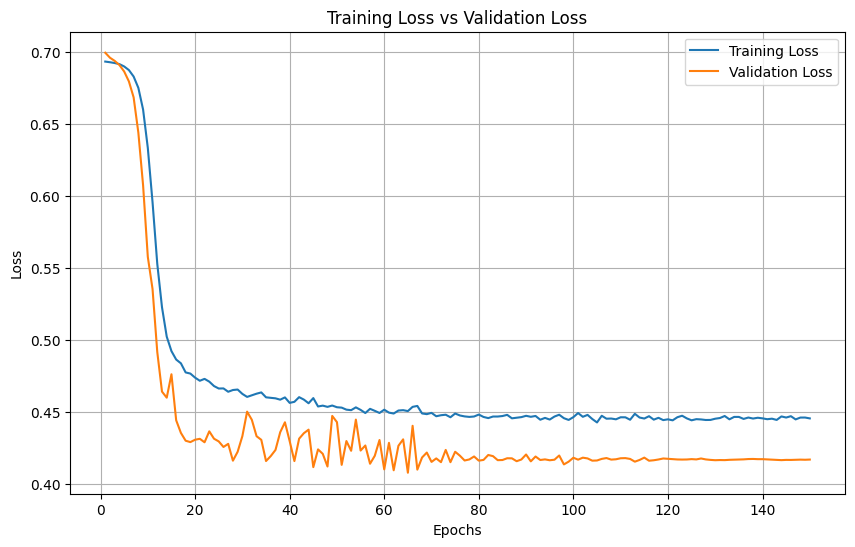

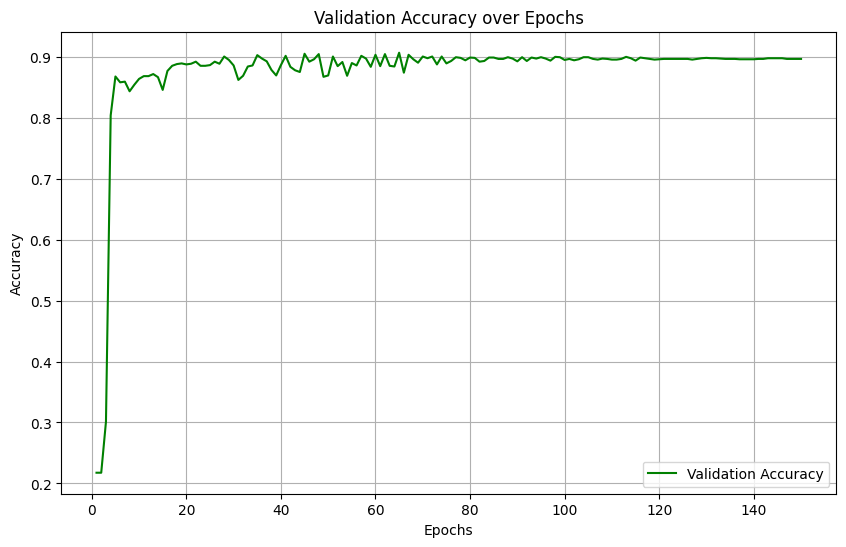

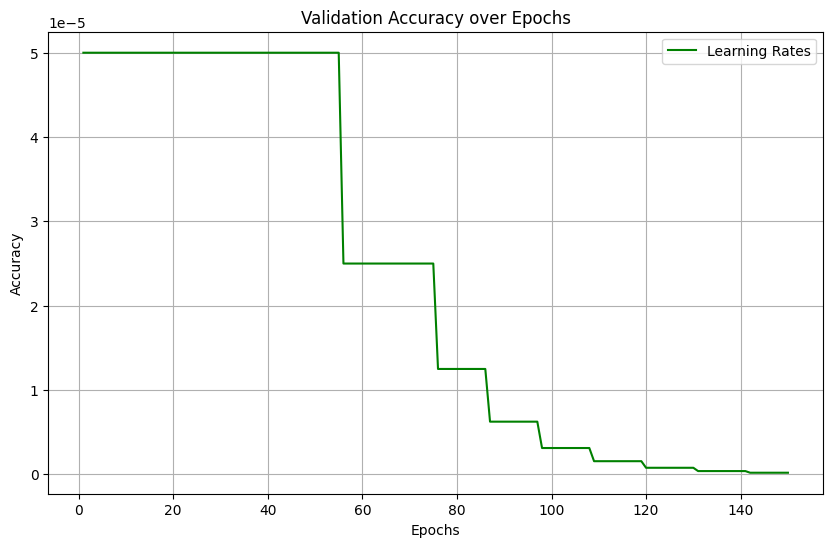

Model for bin 17 saved to 3DCholesterolModels-5A_exp1/model_bin_17.pth
1925 is length of subset grid
Training on bin 18
Bin 18, Epoch 1/150, Train Loss: 0.6932, Validation Loss: 0.7017, Validation Accuracy: 0.2175, Grad Norm: 0.1094, LR: 0.000050
Bin 18, Epoch 11/150, Train Loss: 0.5747, Validation Loss: 0.4860, Validation Accuracy: 0.8627, Grad Norm: 0.8853, LR: 0.000050
Bin 18, Epoch 21/150, Train Loss: 0.4782, Validation Loss: 0.4423, Validation Accuracy: 0.8791, Grad Norm: 4.0809, LR: 0.000050
Bin 18, Epoch 31/150, Train Loss: 0.4660, Validation Loss: 0.4338, Validation Accuracy: 0.8746, Grad Norm: 6.4563, LR: 0.000050
Bin 18, Epoch 41/150, Train Loss: 0.4573, Validation Loss: 0.4175, Validation Accuracy: 0.8972, Grad Norm: 3.8886, LR: 0.000025
Bin 18, Epoch 51/150, Train Loss: 0.4537, Validation Loss: 0.4294, Validation Accuracy: 0.8780, Grad Norm: 0.6839, LR: 0.000013
Bin 18, Epoch 61/150, Train Loss: 0.4538, Validation Loss: 0.4185, Validation Accuracy: 0.8938, Grad Norm: 1.4088

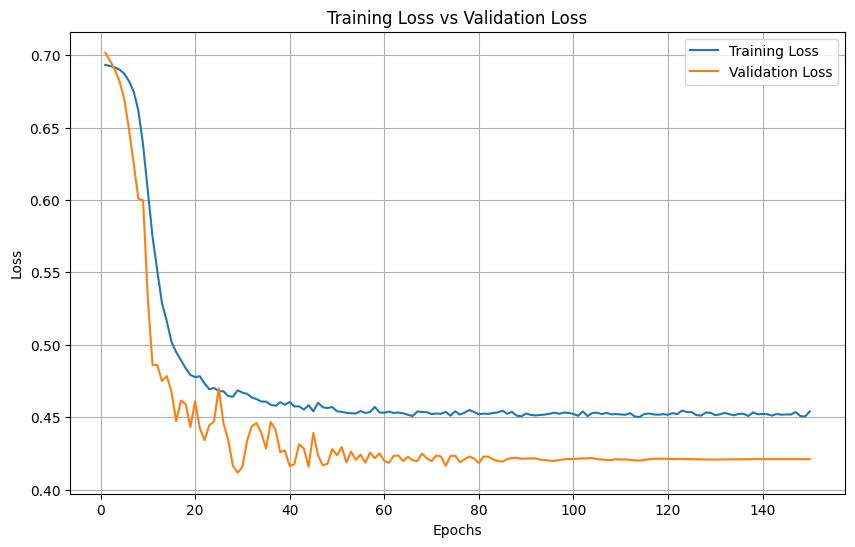

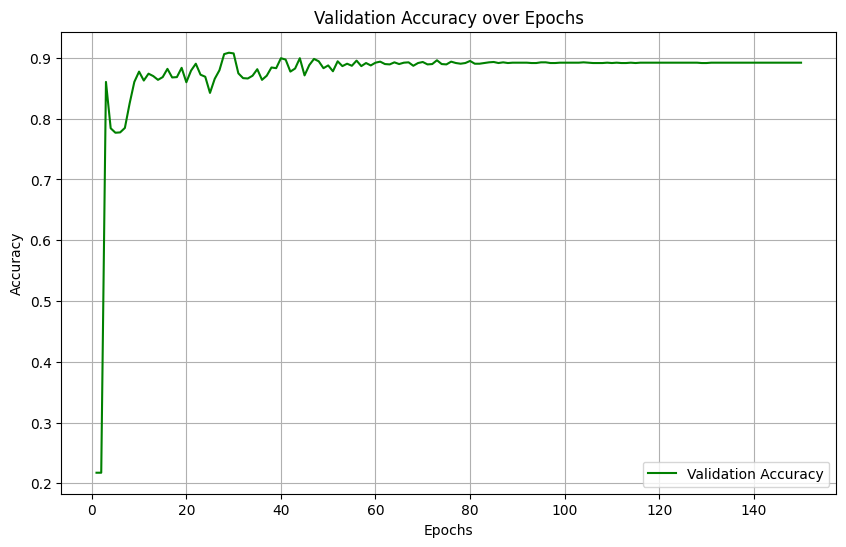

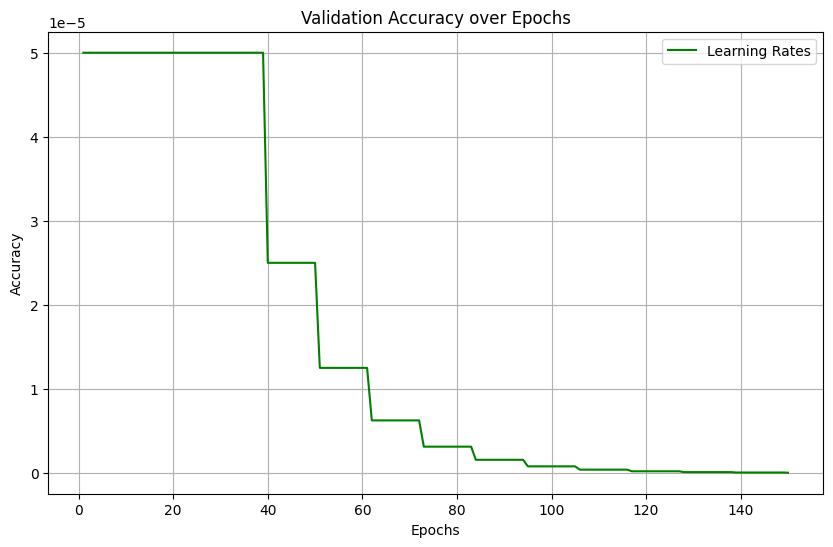

Model for bin 18 saved to 3DCholesterolModels-5A_exp1/model_bin_18.pth
1925 is length of subset grid
Training on bin 19
Bin 19, Epoch 1/150, Train Loss: 0.6932, Validation Loss: 0.7029, Validation Accuracy: 0.2175, Grad Norm: 0.0507, LR: 0.000050
Bin 19, Epoch 11/150, Train Loss: 0.6358, Validation Loss: 0.5363, Validation Accuracy: 0.8158, Grad Norm: 1.4590, LR: 0.000050
Bin 19, Epoch 21/150, Train Loss: 0.4657, Validation Loss: 0.4231, Validation Accuracy: 0.8977, Grad Norm: 2.5562, LR: 0.000050
Bin 19, Epoch 31/150, Train Loss: 0.4605, Validation Loss: 0.4371, Validation Accuracy: 0.8819, Grad Norm: 6.1698, LR: 0.000050
Bin 19, Epoch 41/150, Train Loss: 0.4536, Validation Loss: 0.4191, Validation Accuracy: 0.8966, Grad Norm: 1.7035, LR: 0.000025
Bin 19, Epoch 51/150, Train Loss: 0.4517, Validation Loss: 0.4195, Validation Accuracy: 0.8955, Grad Norm: 1.4876, LR: 0.000025
Bin 19, Epoch 61/150, Train Loss: 0.4501, Validation Loss: 0.4140, Validation Accuracy: 0.9023, Grad Norm: 1.0501

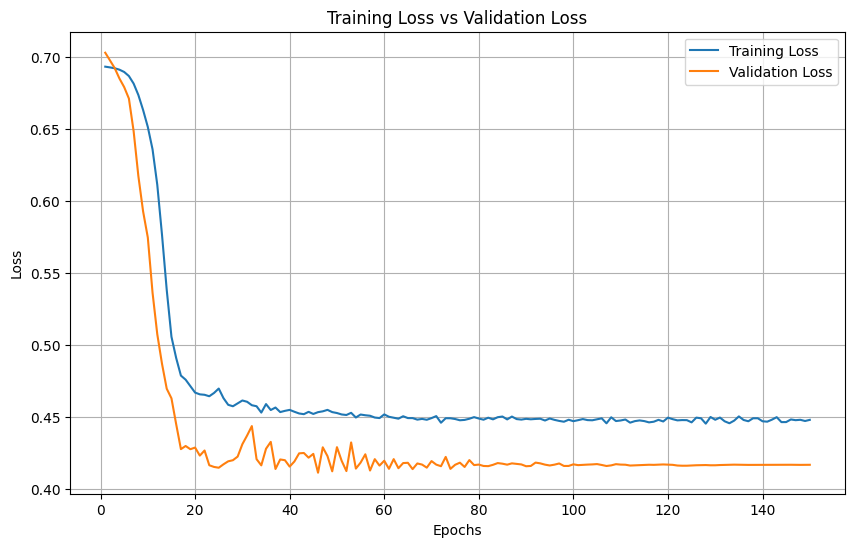

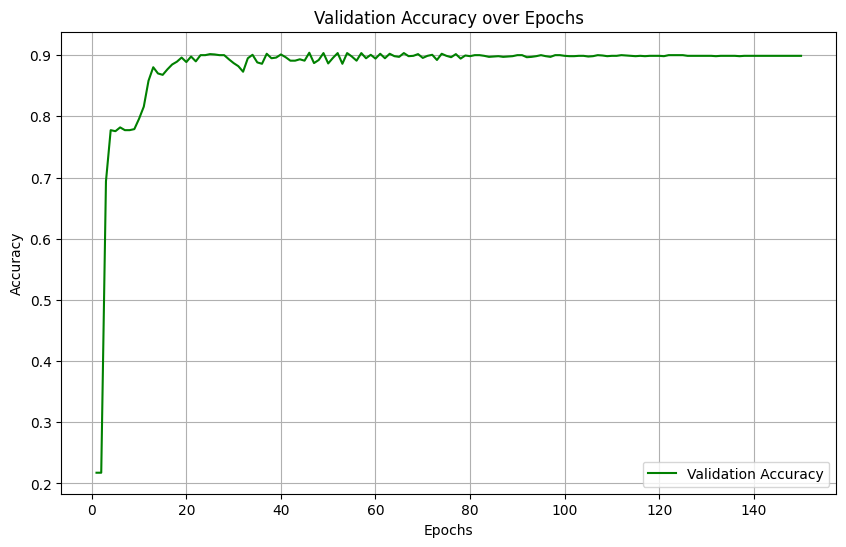

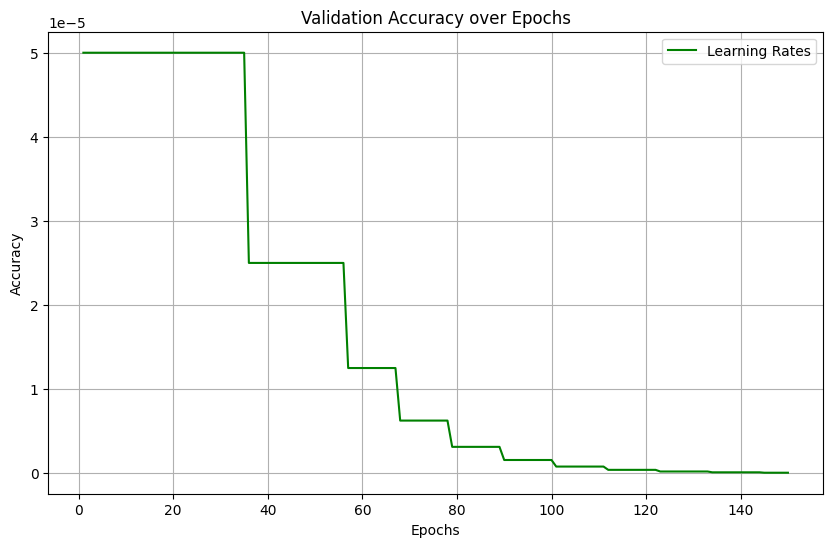

Model for bin 19 saved to 3DCholesterolModels-5A_exp1/model_bin_19.pth
1925 is length of subset grid
Training on bin 20
Bin 20, Epoch 1/150, Train Loss: 0.6932, Validation Loss: 0.6985, Validation Accuracy: 0.2175, Grad Norm: 0.0871, LR: 0.000050
Bin 20, Epoch 11/150, Train Loss: 0.6397, Validation Loss: 0.5455, Validation Accuracy: 0.8266, Grad Norm: 1.4368, LR: 0.000050
Bin 20, Epoch 21/150, Train Loss: 0.4781, Validation Loss: 0.4583, Validation Accuracy: 0.8531, Grad Norm: 2.7580, LR: 0.000050
Bin 20, Epoch 31/150, Train Loss: 0.4616, Validation Loss: 0.4214, Validation Accuracy: 0.8960, Grad Norm: 2.9118, LR: 0.000050
Bin 20, Epoch 41/150, Train Loss: 0.4576, Validation Loss: 0.4256, Validation Accuracy: 0.8887, Grad Norm: 6.4231, LR: 0.000050
Bin 20, Epoch 51/150, Train Loss: 0.4528, Validation Loss: 0.4377, Validation Accuracy: 0.8734, Grad Norm: 1.0059, LR: 0.000050
Bin 20, Epoch 61/150, Train Loss: 0.4480, Validation Loss: 0.4274, Validation Accuracy: 0.8870, Grad Norm: 1.8771

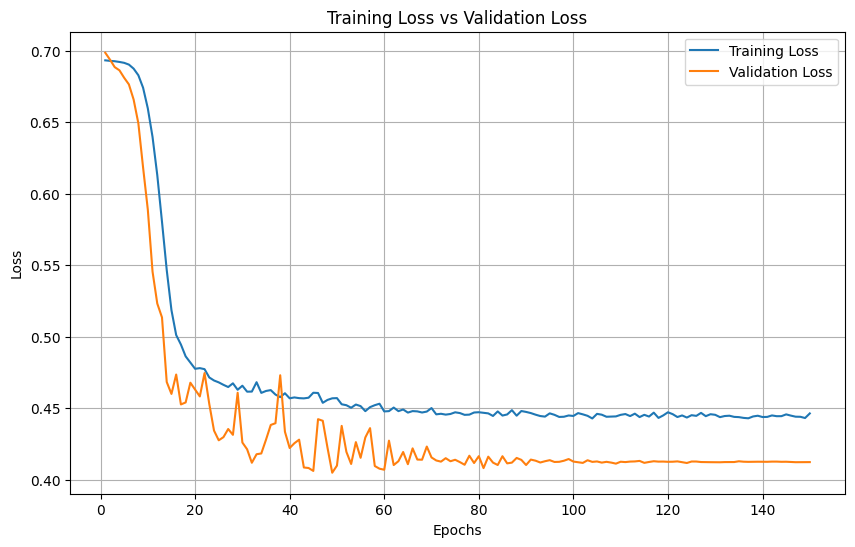

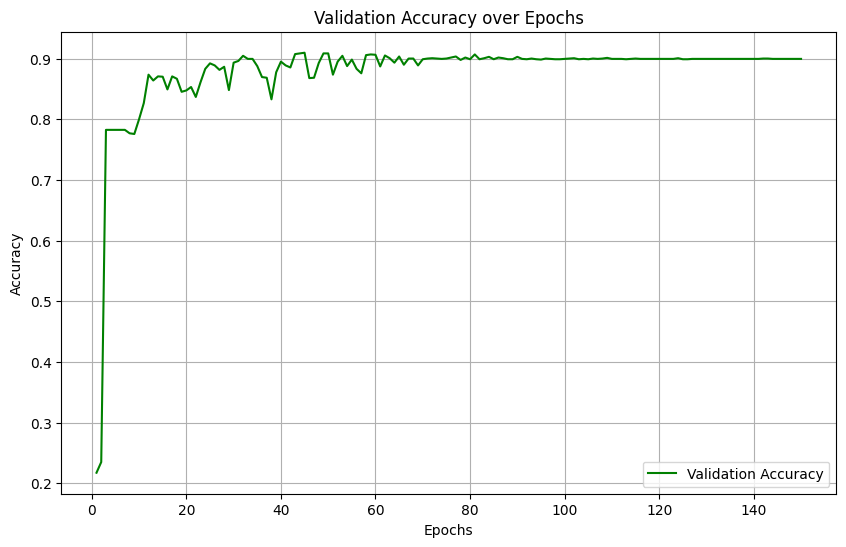

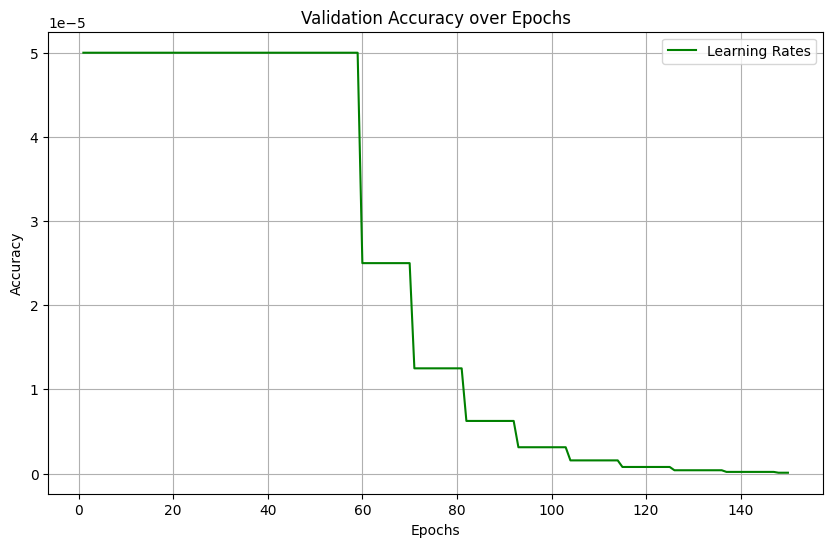

Model for bin 20 saved to 3DCholesterolModels-5A_exp1/model_bin_20.pth
1925 is length of subset grid
Training on bin 21
Bin 21, Epoch 1/150, Train Loss: 0.6930, Validation Loss: 0.6974, Validation Accuracy: 0.2175, Grad Norm: 0.0222, LR: 0.000050
Bin 21, Epoch 11/150, Train Loss: 0.5961, Validation Loss: 0.5076, Validation Accuracy: 0.8774, Grad Norm: 0.7504, LR: 0.000050
Bin 21, Epoch 21/150, Train Loss: 0.4716, Validation Loss: 0.4344, Validation Accuracy: 0.8910, Grad Norm: 3.2680, LR: 0.000050
Bin 21, Epoch 31/150, Train Loss: 0.4597, Validation Loss: 0.4197, Validation Accuracy: 0.9011, Grad Norm: 0.4306, LR: 0.000050
Bin 21, Epoch 41/150, Train Loss: 0.4652, Validation Loss: 0.4259, Validation Accuracy: 0.8904, Grad Norm: 6.4801, LR: 0.000050
Bin 21, Epoch 51/150, Train Loss: 0.4523, Validation Loss: 0.4124, Validation Accuracy: 0.9034, Grad Norm: 2.0351, LR: 0.000025
Bin 21, Epoch 61/150, Train Loss: 0.4493, Validation Loss: 0.4236, Validation Accuracy: 0.8898, Grad Norm: 1.1405

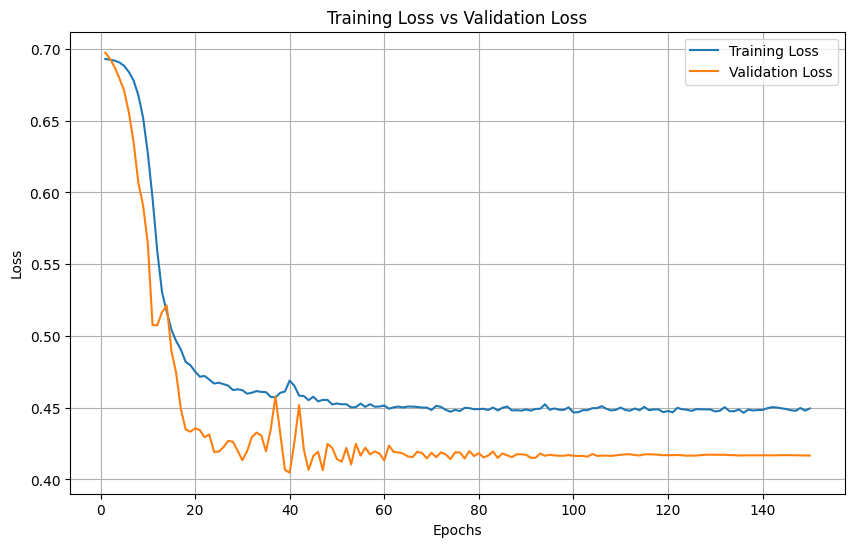

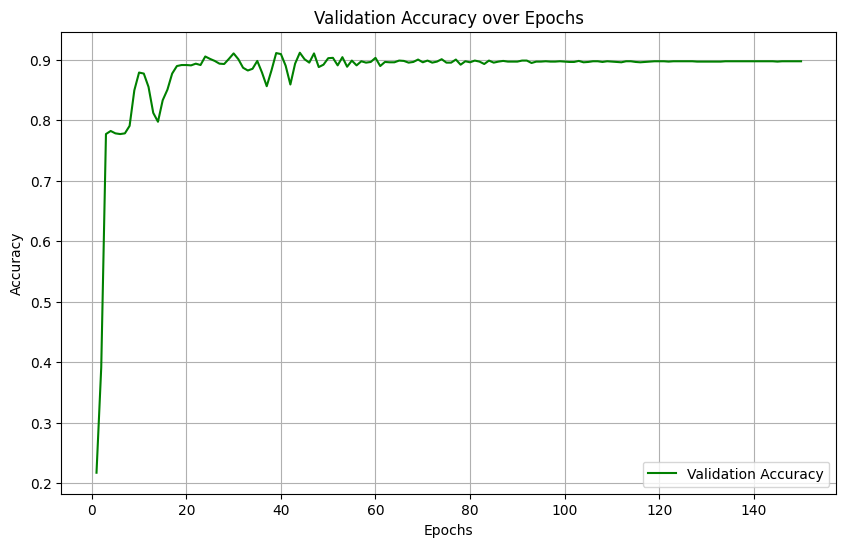

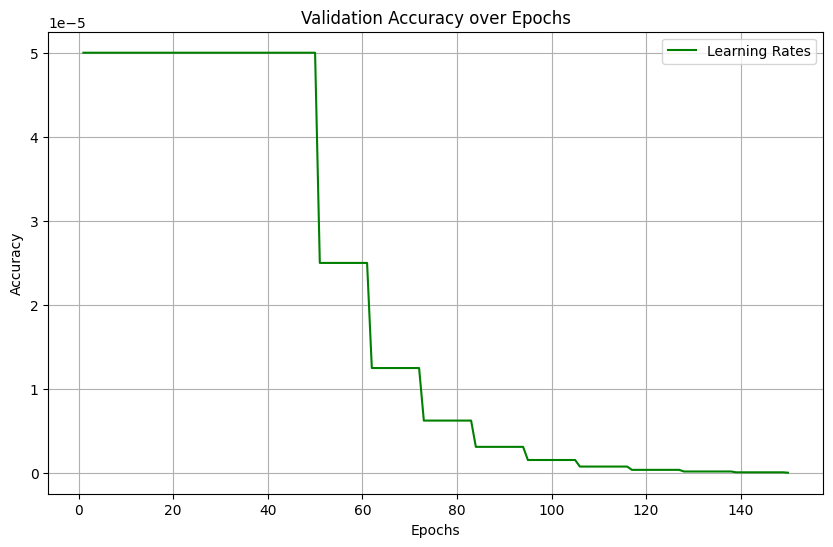

Model for bin 21 saved to 3DCholesterolModels-5A_exp1/model_bin_21.pth
1925 is length of subset grid
Training on bin 22
Bin 22, Epoch 1/150, Train Loss: 0.6930, Validation Loss: 0.6861, Validation Accuracy: 0.7825, Grad Norm: 0.0519, LR: 0.000050
Bin 22, Epoch 11/150, Train Loss: 0.5349, Validation Loss: 0.4906, Validation Accuracy: 0.8542, Grad Norm: 3.5164, LR: 0.000050
Bin 22, Epoch 21/150, Train Loss: 0.4633, Validation Loss: 0.4423, Validation Accuracy: 0.8797, Grad Norm: 1.8617, LR: 0.000050
Bin 22, Epoch 31/150, Train Loss: 0.4599, Validation Loss: 0.4245, Validation Accuracy: 0.8904, Grad Norm: 6.5521, LR: 0.000050
Bin 22, Epoch 41/150, Train Loss: 0.4509, Validation Loss: 0.4186, Validation Accuracy: 0.8966, Grad Norm: 0.7848, LR: 0.000050
Bin 22, Epoch 51/150, Train Loss: 0.4501, Validation Loss: 0.4163, Validation Accuracy: 0.8994, Grad Norm: 3.2097, LR: 0.000025
Bin 22, Epoch 61/150, Train Loss: 0.4486, Validation Loss: 0.4165, Validation Accuracy: 0.8989, Grad Norm: 1.6680

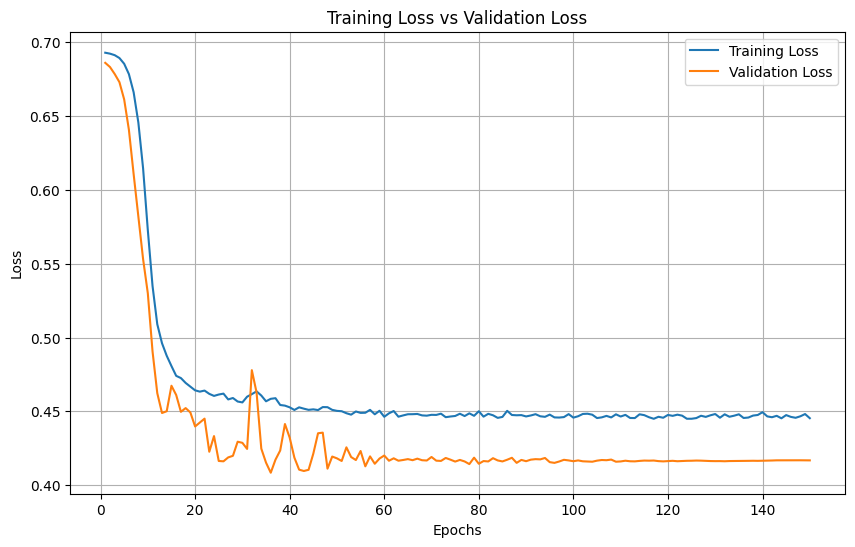

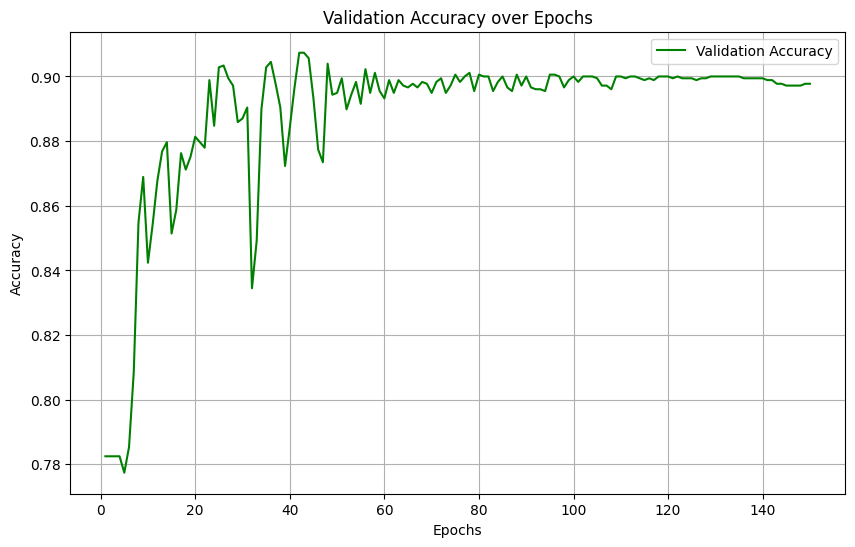

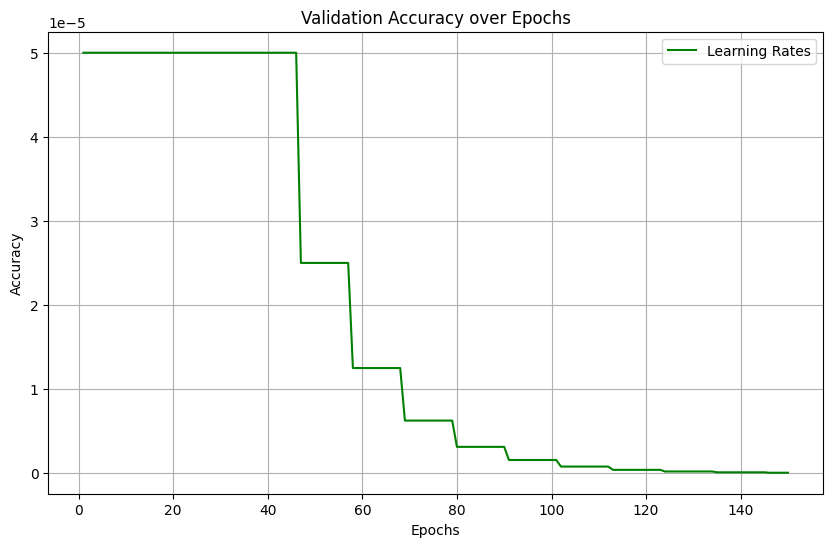

Model for bin 22 saved to 3DCholesterolModels-5A_exp1/model_bin_22.pth
1925 is length of subset grid
Training on bin 23
Bin 23, Epoch 1/150, Train Loss: 0.6931, Validation Loss: 0.6817, Validation Accuracy: 0.7825, Grad Norm: 0.0216, LR: 0.000050
Bin 23, Epoch 11/150, Train Loss: 0.5767, Validation Loss: 0.5181, Validation Accuracy: 0.8588, Grad Norm: 3.2216, LR: 0.000050
Bin 23, Epoch 21/150, Train Loss: 0.4833, Validation Loss: 0.4843, Validation Accuracy: 0.8316, Grad Norm: 4.5171, LR: 0.000050
Bin 23, Epoch 31/150, Train Loss: 0.4692, Validation Loss: 0.4265, Validation Accuracy: 0.8927, Grad Norm: 5.0301, LR: 0.000050
Bin 23, Epoch 41/150, Train Loss: 0.4635, Validation Loss: 0.4229, Validation Accuracy: 0.8932, Grad Norm: 4.4403, LR: 0.000050
Bin 23, Epoch 51/150, Train Loss: 0.4604, Validation Loss: 0.4445, Validation Accuracy: 0.8667, Grad Norm: 4.9292, LR: 0.000050
Bin 23, Epoch 61/150, Train Loss: 0.4582, Validation Loss: 0.4372, Validation Accuracy: 0.8734, Grad Norm: 4.4671

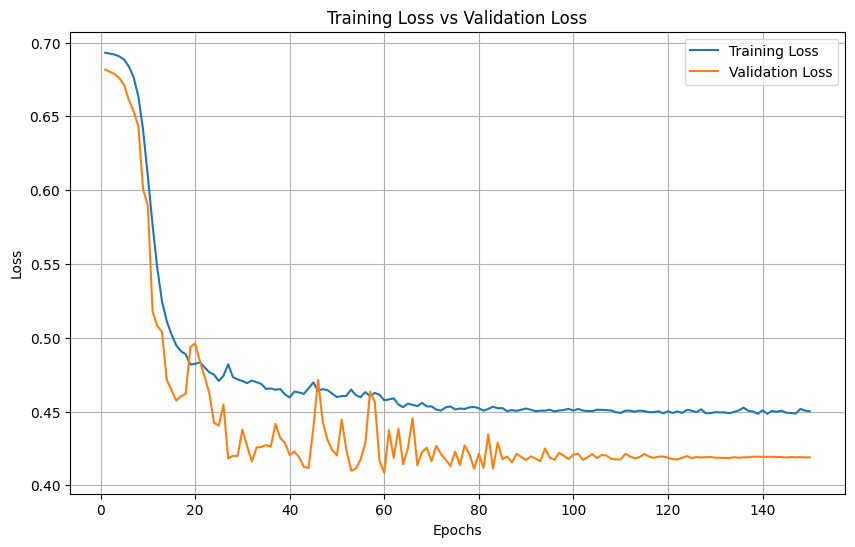

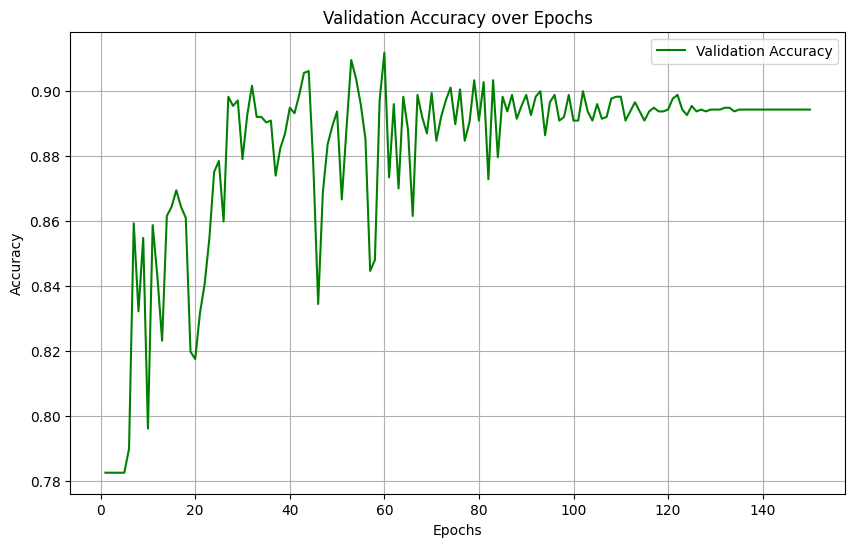

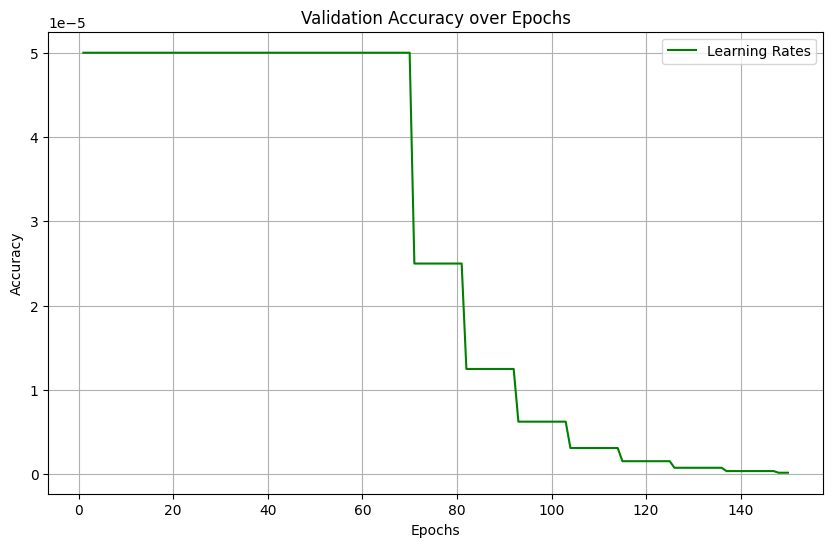

Model for bin 23 saved to 3DCholesterolModels-5A_exp1/model_bin_23.pth
1925 is length of subset grid
Training on bin 24
Bin 24, Epoch 1/150, Train Loss: 0.6930, Validation Loss: 0.6870, Validation Accuracy: 0.7825, Grad Norm: 0.0163, LR: 0.000050
Bin 24, Epoch 11/150, Train Loss: 0.6061, Validation Loss: 0.5465, Validation Accuracy: 0.8712, Grad Norm: 1.4898, LR: 0.000050
Bin 24, Epoch 21/150, Train Loss: 0.4682, Validation Loss: 0.4236, Validation Accuracy: 0.9006, Grad Norm: 0.4585, LR: 0.000050
Bin 24, Epoch 31/150, Train Loss: 0.4558, Validation Loss: 0.4290, Validation Accuracy: 0.8887, Grad Norm: 0.3914, LR: 0.000050
Bin 24, Epoch 41/150, Train Loss: 0.4546, Validation Loss: 0.4285, Validation Accuracy: 0.8853, Grad Norm: 2.0888, LR: 0.000050
Bin 24, Epoch 51/150, Train Loss: 0.4484, Validation Loss: 0.4281, Validation Accuracy: 0.8842, Grad Norm: 3.0571, LR: 0.000050
Bin 24, Epoch 61/150, Train Loss: 0.4497, Validation Loss: 0.4301, Validation Accuracy: 0.8836, Grad Norm: 6.0321

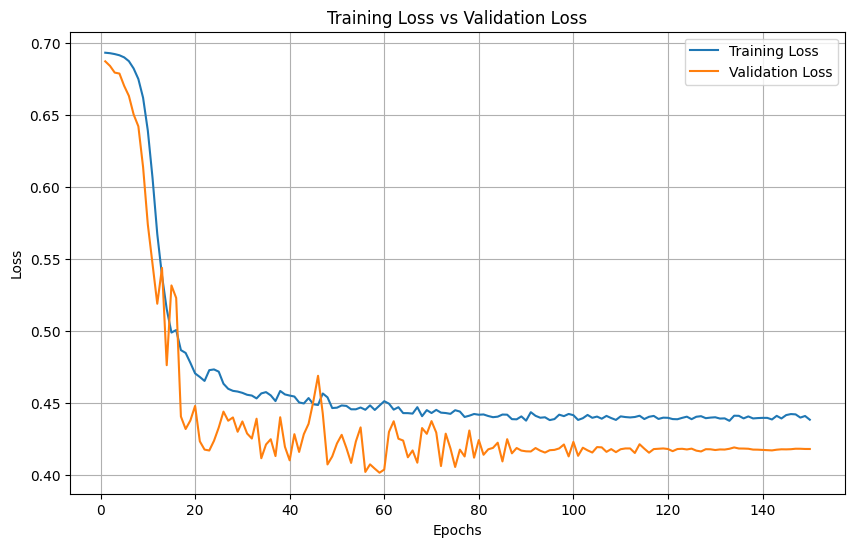

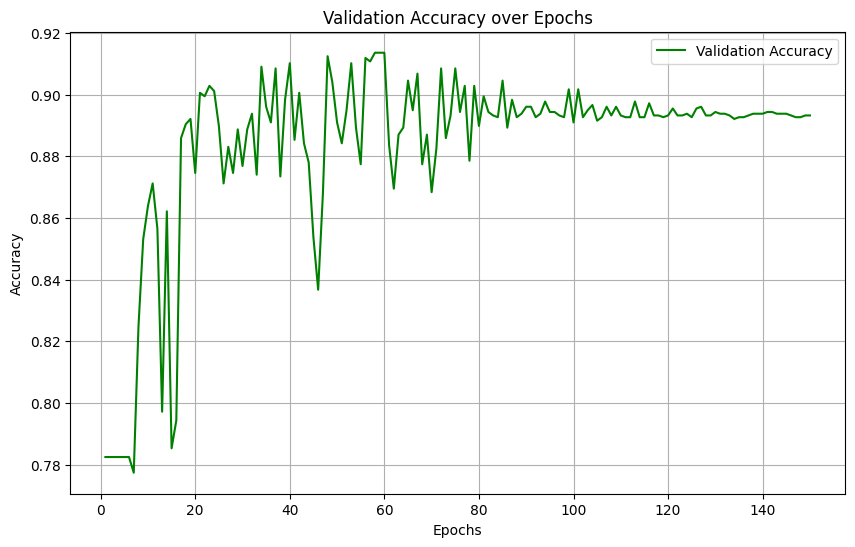

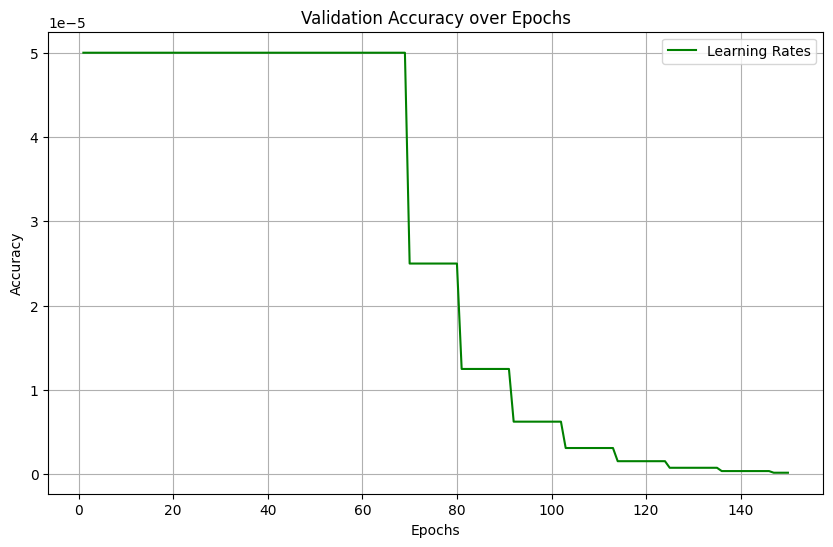

Model for bin 24 saved to 3DCholesterolModels-5A_exp1/model_bin_24.pth
1925 is length of subset grid
Training on bin 25
Bin 25, Epoch 1/150, Train Loss: 0.6928, Validation Loss: 0.6933, Validation Accuracy: 0.3588, Grad Norm: 0.0505, LR: 0.000050
Bin 25, Epoch 11/150, Train Loss: 0.5642, Validation Loss: 0.5566, Validation Accuracy: 0.7972, Grad Norm: 4.1230, LR: 0.000050
Bin 25, Epoch 21/150, Train Loss: 0.4741, Validation Loss: 0.4336, Validation Accuracy: 0.8960, Grad Norm: 0.8642, LR: 0.000050
Bin 25, Epoch 31/150, Train Loss: 0.4667, Validation Loss: 0.4494, Validation Accuracy: 0.8650, Grad Norm: 4.4778, LR: 0.000050
Bin 25, Epoch 41/150, Train Loss: 0.4565, Validation Loss: 0.4111, Validation Accuracy: 0.9096, Grad Norm: 2.1163, LR: 0.000025
Bin 25, Epoch 51/150, Train Loss: 0.4558, Validation Loss: 0.4143, Validation Accuracy: 0.9051, Grad Norm: 5.7469, LR: 0.000025
Bin 25, Epoch 61/150, Train Loss: 0.4549, Validation Loss: 0.4183, Validation Accuracy: 0.8994, Grad Norm: 0.6678

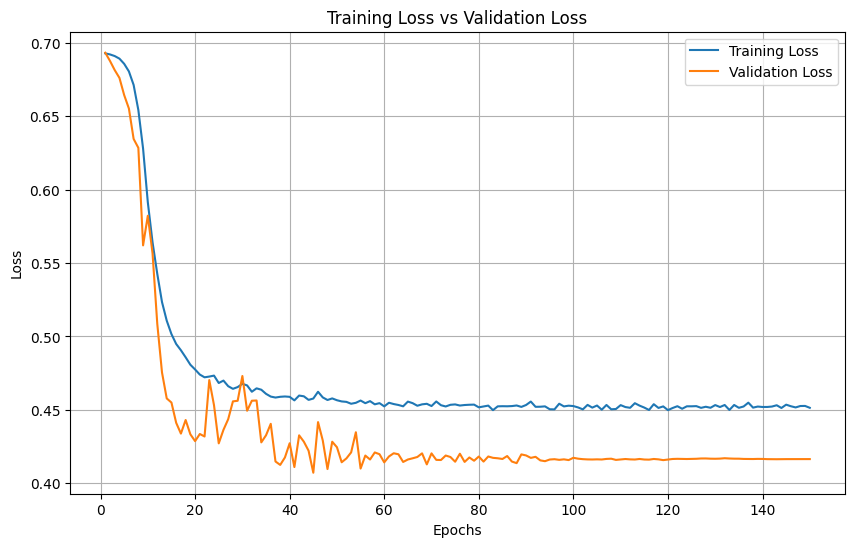

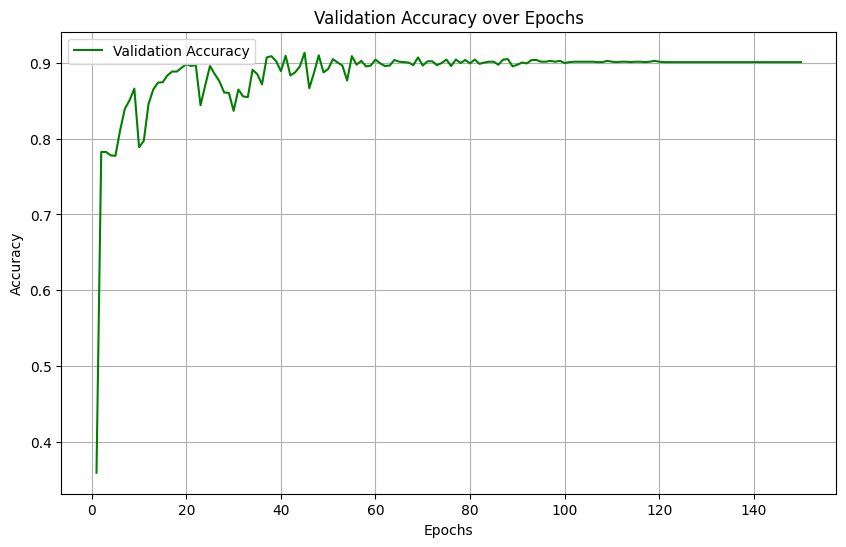

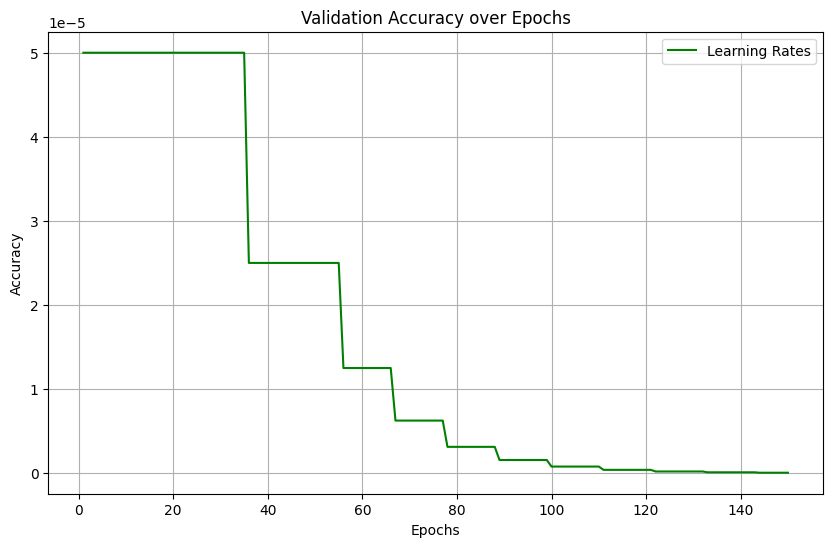

Model for bin 25 saved to 3DCholesterolModels-5A_exp1/model_bin_25.pth
1925 is length of subset grid
Training on bin 26
Bin 26, Epoch 1/150, Train Loss: 0.6934, Validation Loss: 0.6823, Validation Accuracy: 0.7825, Grad Norm: 0.0560, LR: 0.000050
Bin 26, Epoch 11/150, Train Loss: 0.6327, Validation Loss: 0.6359, Validation Accuracy: 0.7384, Grad Norm: 1.0827, LR: 0.000050
Bin 26, Epoch 21/150, Train Loss: 0.4768, Validation Loss: 0.4305, Validation Accuracy: 0.8966, Grad Norm: 0.9749, LR: 0.000050
Bin 26, Epoch 31/150, Train Loss: 0.4602, Validation Loss: 0.4200, Validation Accuracy: 0.9000, Grad Norm: 0.4212, LR: 0.000050
Bin 26, Epoch 41/150, Train Loss: 0.4559, Validation Loss: 0.4350, Validation Accuracy: 0.8751, Grad Norm: 3.2722, LR: 0.000050
Bin 26, Epoch 51/150, Train Loss: 0.4478, Validation Loss: 0.4185, Validation Accuracy: 0.8960, Grad Norm: 4.6234, LR: 0.000050
Bin 26, Epoch 61/150, Train Loss: 0.4469, Validation Loss: 0.4191, Validation Accuracy: 0.8932, Grad Norm: 5.0371

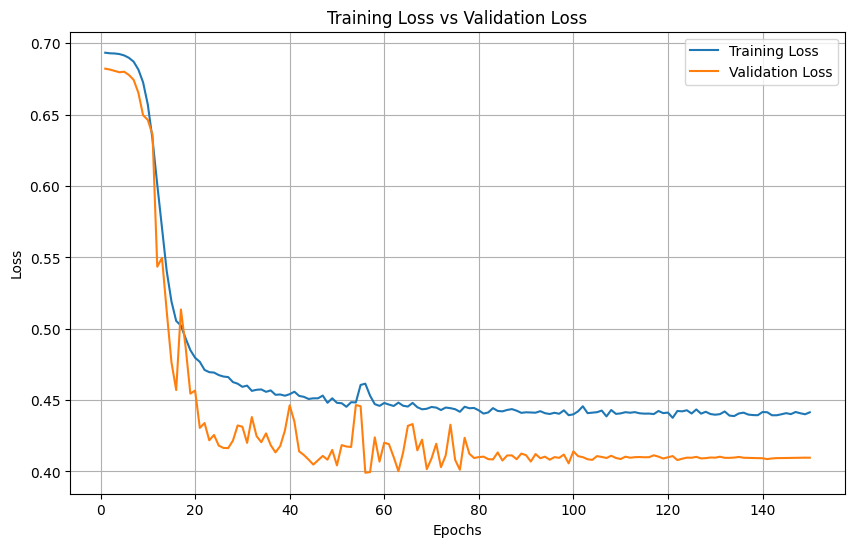

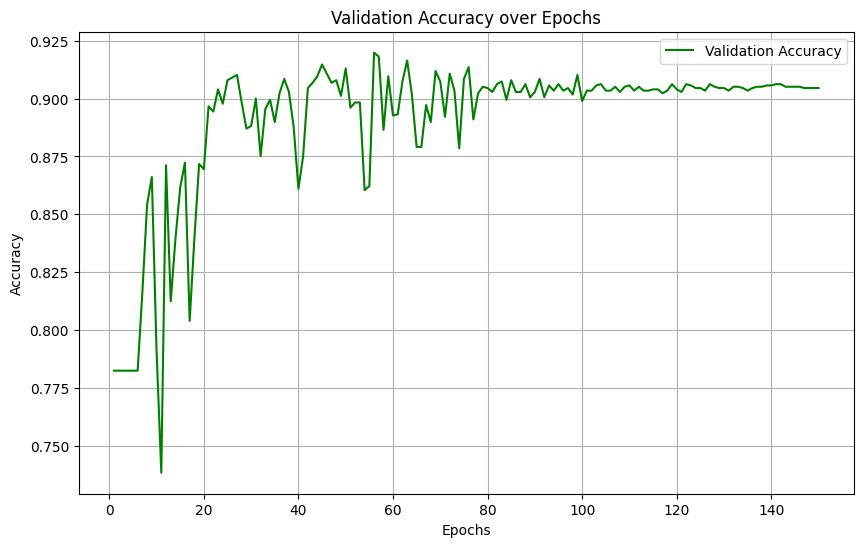

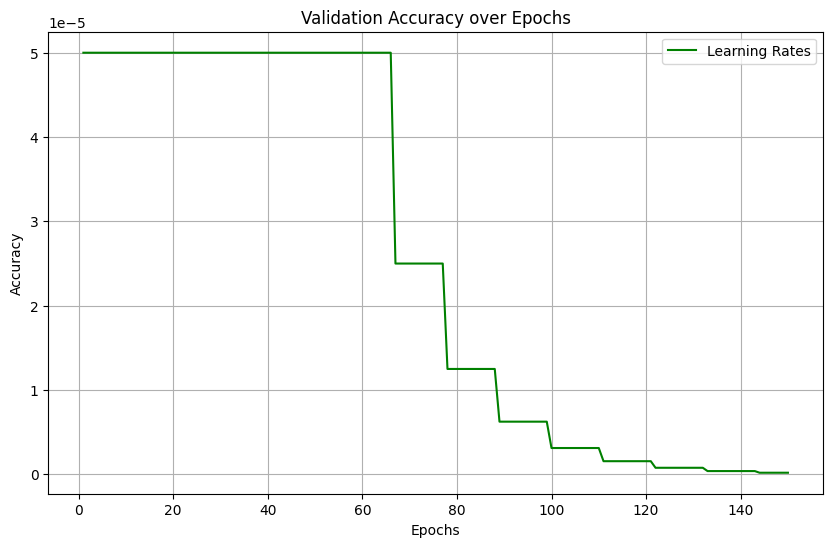

Model for bin 26 saved to 3DCholesterolModels-5A_exp1/model_bin_26.pth
1925 is length of subset grid
Training on bin 27
Bin 27, Epoch 1/150, Train Loss: 0.6932, Validation Loss: 0.7009, Validation Accuracy: 0.2175, Grad Norm: 0.0572, LR: 0.000050
Bin 27, Epoch 11/150, Train Loss: 0.6166, Validation Loss: 0.5139, Validation Accuracy: 0.8446, Grad Norm: 0.7547, LR: 0.000050
Bin 27, Epoch 21/150, Train Loss: 0.4732, Validation Loss: 0.4491, Validation Accuracy: 0.8740, Grad Norm: 6.3814, LR: 0.000050
Bin 27, Epoch 31/150, Train Loss: 0.4644, Validation Loss: 0.4523, Validation Accuracy: 0.8599, Grad Norm: 0.4418, LR: 0.000050
Bin 27, Epoch 41/150, Train Loss: 0.4540, Validation Loss: 0.4171, Validation Accuracy: 0.8989, Grad Norm: 4.2168, LR: 0.000050
Bin 27, Epoch 51/150, Train Loss: 0.4533, Validation Loss: 0.4319, Validation Accuracy: 0.8802, Grad Norm: 1.3450, LR: 0.000050
Bin 27, Epoch 61/150, Train Loss: 0.4488, Validation Loss: 0.4096, Validation Accuracy: 0.9062, Grad Norm: 4.8491

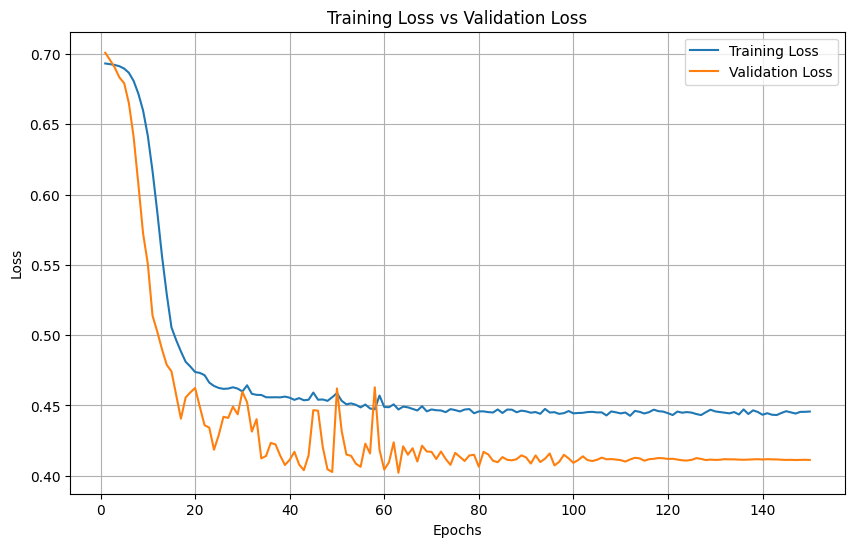

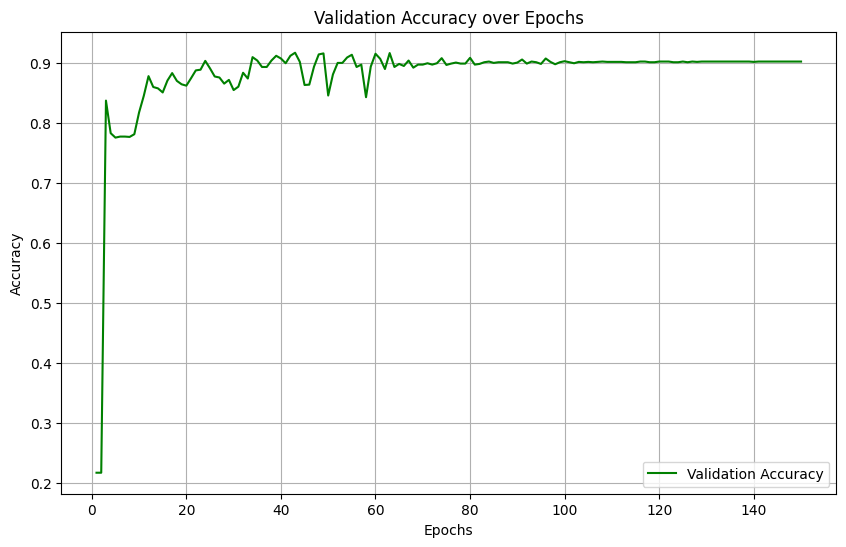

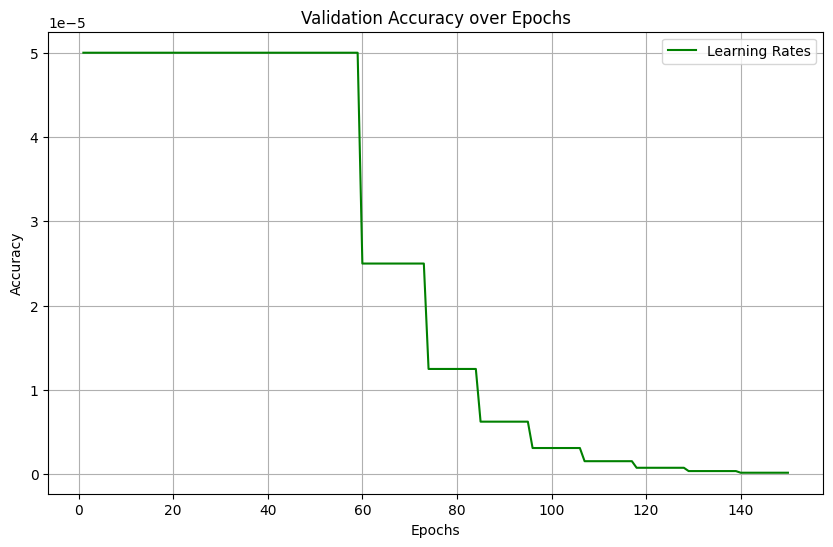

Model for bin 27 saved to 3DCholesterolModels-5A_exp1/model_bin_27.pth
1925 is length of subset grid
Training on bin 28
Bin 28, Epoch 1/150, Train Loss: 0.6931, Validation Loss: 0.6887, Validation Accuracy: 0.7825, Grad Norm: 0.0149, LR: 0.000050
Bin 28, Epoch 11/150, Train Loss: 0.6115, Validation Loss: 0.5588, Validation Accuracy: 0.8627, Grad Norm: 0.9764, LR: 0.000050
Bin 28, Epoch 21/150, Train Loss: 0.4865, Validation Loss: 0.4633, Validation Accuracy: 0.8610, Grad Norm: 2.0662, LR: 0.000050
Bin 28, Epoch 31/150, Train Loss: 0.4653, Validation Loss: 0.4250, Validation Accuracy: 0.8955, Grad Norm: 0.3191, LR: 0.000050
Bin 28, Epoch 41/150, Train Loss: 0.4590, Validation Loss: 0.4144, Validation Accuracy: 0.9045, Grad Norm: 0.3489, LR: 0.000025
Bin 28, Epoch 51/150, Train Loss: 0.4529, Validation Loss: 0.4275, Validation Accuracy: 0.8876, Grad Norm: 0.9337, LR: 0.000025
Bin 28, Epoch 61/150, Train Loss: 0.4518, Validation Loss: 0.4182, Validation Accuracy: 0.8972, Grad Norm: 1.5660

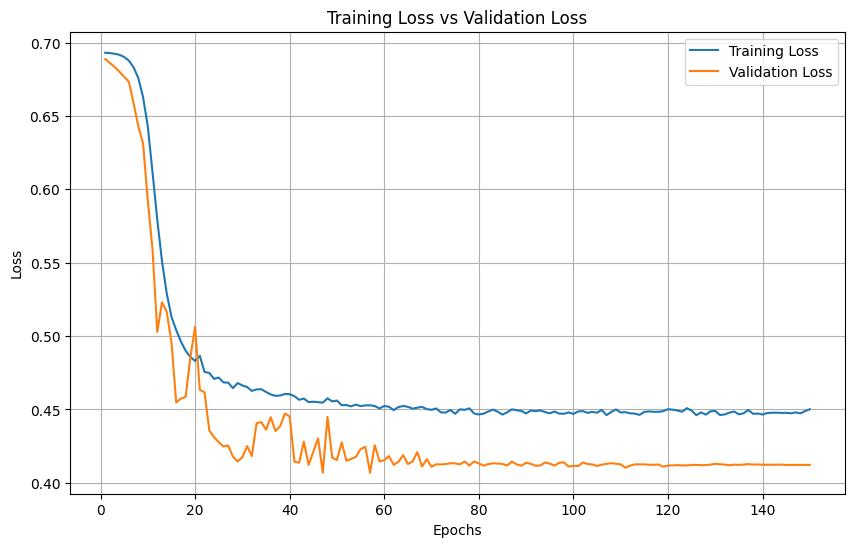

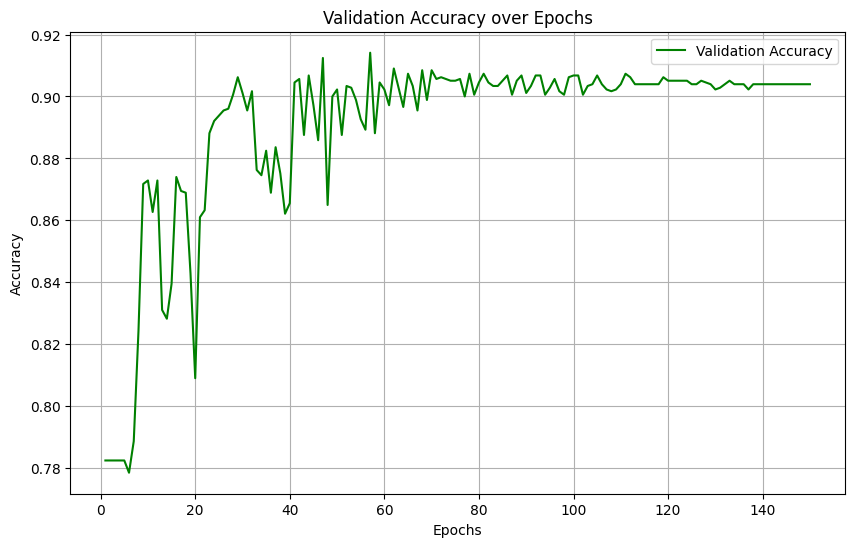

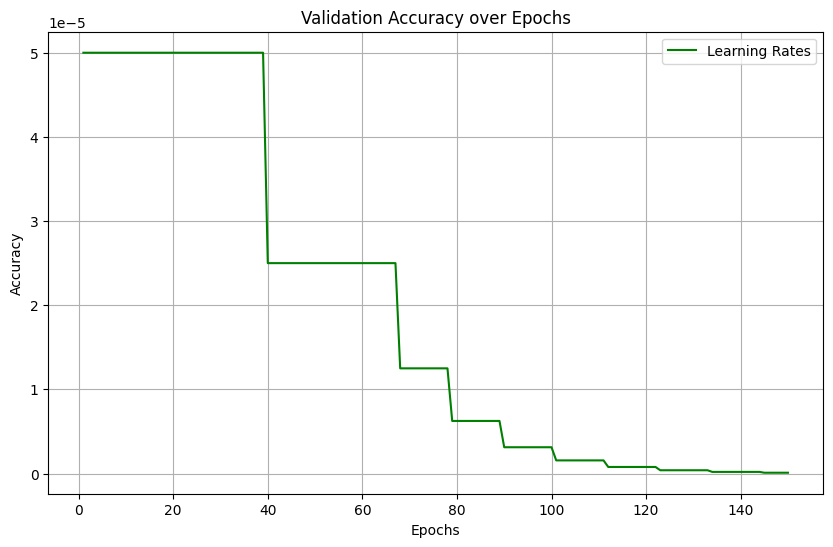

Model for bin 28 saved to 3DCholesterolModels-5A_exp1/model_bin_28.pth
1925 is length of subset grid
Training on bin 29
Bin 29, Epoch 1/150, Train Loss: 0.6931, Validation Loss: 0.6970, Validation Accuracy: 0.2175, Grad Norm: 0.0561, LR: 0.000050
Bin 29, Epoch 11/150, Train Loss: 0.5741, Validation Loss: 0.5197, Validation Accuracy: 0.8621, Grad Norm: 4.4886, LR: 0.000050
Bin 29, Epoch 21/150, Train Loss: 0.4697, Validation Loss: 0.4158, Validation Accuracy: 0.9051, Grad Norm: 5.7843, LR: 0.000050
Bin 29, Epoch 31/150, Train Loss: 0.4563, Validation Loss: 0.4269, Validation Accuracy: 0.8870, Grad Norm: 1.8184, LR: 0.000050
Bin 29, Epoch 41/150, Train Loss: 0.4553, Validation Loss: 0.4277, Validation Accuracy: 0.8831, Grad Norm: 3.1991, LR: 0.000025
Bin 29, Epoch 51/150, Train Loss: 0.4515, Validation Loss: 0.4208, Validation Accuracy: 0.8921, Grad Norm: 1.2739, LR: 0.000013
Bin 29, Epoch 61/150, Train Loss: 0.4500, Validation Loss: 0.4187, Validation Accuracy: 0.8955, Grad Norm: 1.3363

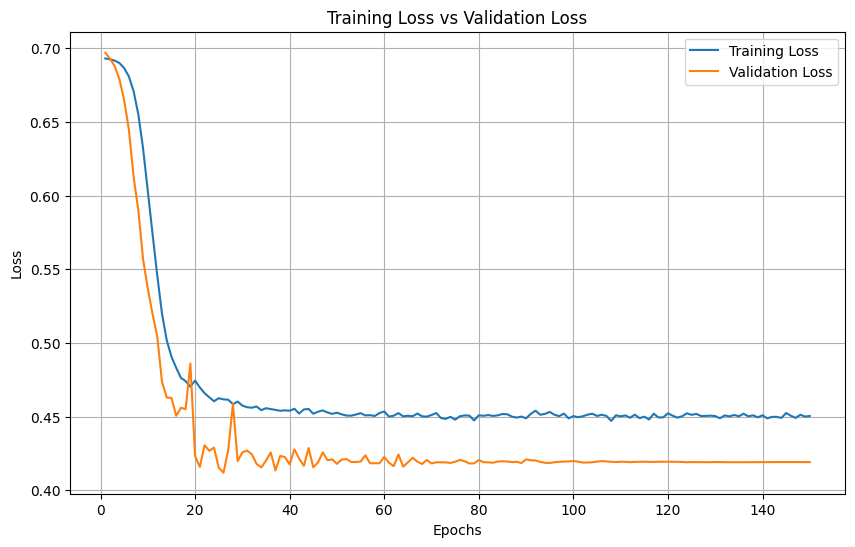

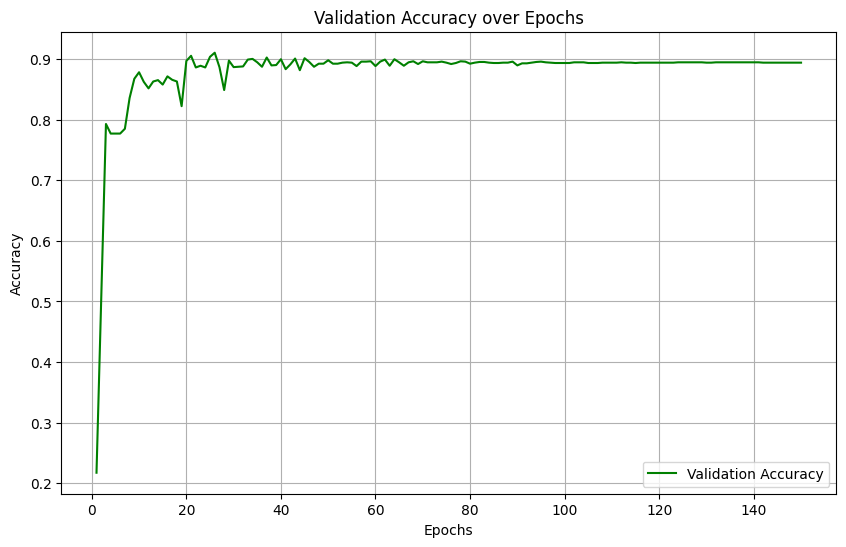

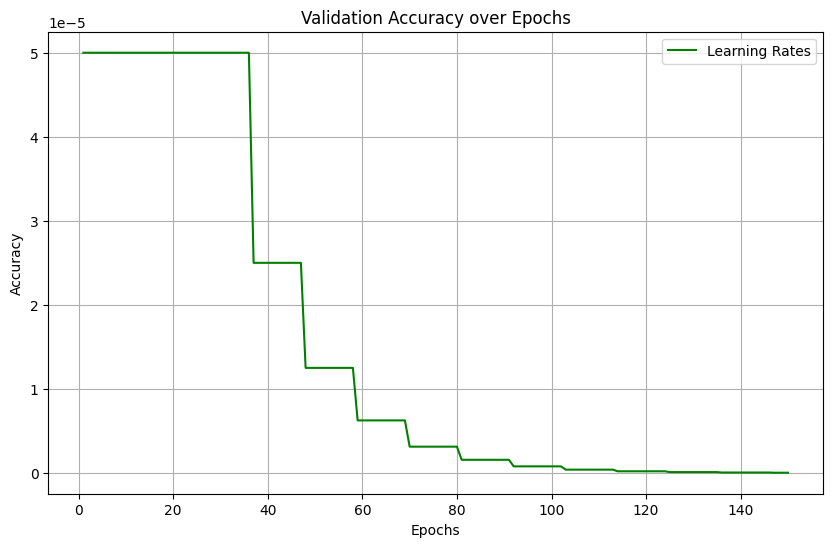

Model for bin 29 saved to 3DCholesterolModels-5A_exp1/model_bin_29.pth
1925 is length of subset grid
Training on bin 30
Bin 30, Epoch 1/150, Train Loss: 0.6931, Validation Loss: 0.6837, Validation Accuracy: 0.7825, Grad Norm: 0.0844, LR: 0.000050
Bin 30, Epoch 11/150, Train Loss: 0.5507, Validation Loss: 0.5034, Validation Accuracy: 0.8554, Grad Norm: 3.9176, LR: 0.000050
Bin 30, Epoch 21/150, Train Loss: 0.4632, Validation Loss: 0.4231, Validation Accuracy: 0.8977, Grad Norm: 2.9828, LR: 0.000050
Bin 30, Epoch 31/150, Train Loss: 0.4525, Validation Loss: 0.4257, Validation Accuracy: 0.8904, Grad Norm: 0.2262, LR: 0.000050
Bin 30, Epoch 41/150, Train Loss: 0.4490, Validation Loss: 0.4159, Validation Accuracy: 0.8994, Grad Norm: 1.8444, LR: 0.000050
Bin 30, Epoch 51/150, Train Loss: 0.4448, Validation Loss: 0.4210, Validation Accuracy: 0.8927, Grad Norm: 4.5986, LR: 0.000025
Bin 30, Epoch 61/150, Train Loss: 0.4458, Validation Loss: 0.4135, Validation Accuracy: 0.9023, Grad Norm: 1.3172

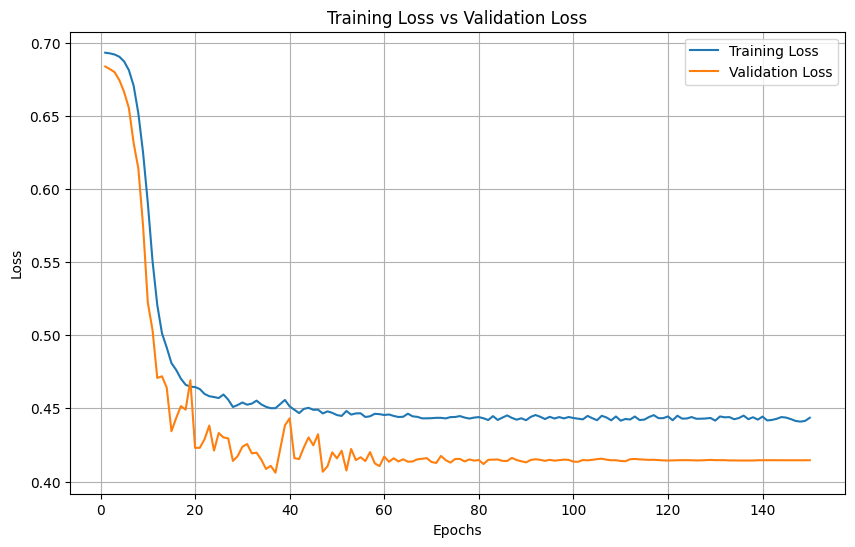

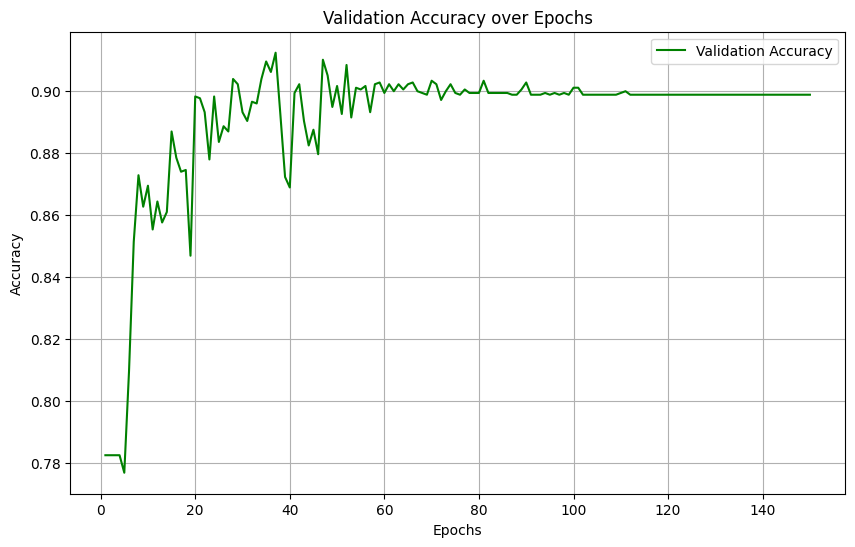

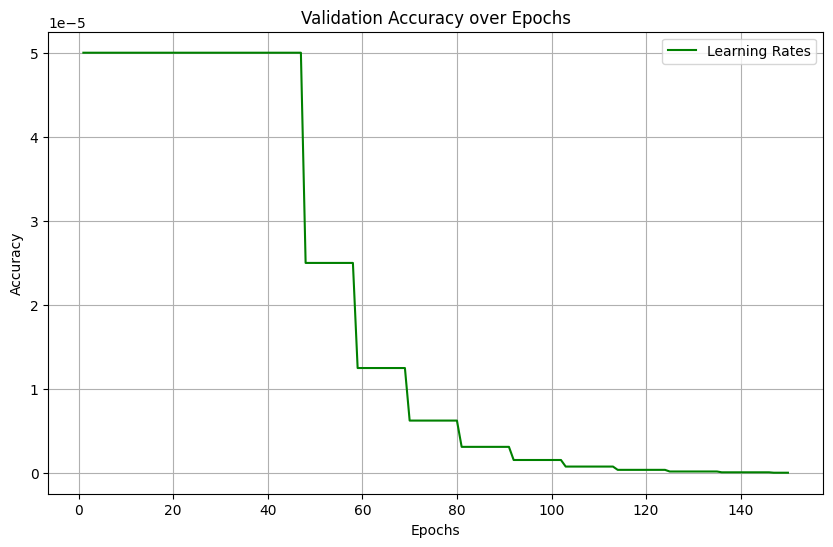

Model for bin 30 saved to 3DCholesterolModels-5A_exp1/model_bin_30.pth
1925 is length of subset grid
Training on bin 31
Bin 31, Epoch 1/150, Train Loss: 0.6935, Validation Loss: 0.6800, Validation Accuracy: 0.7825, Grad Norm: 0.0307, LR: 0.000050
Bin 31, Epoch 11/150, Train Loss: 0.6752, Validation Loss: 0.6313, Validation Accuracy: 0.7780, Grad Norm: 1.4230, LR: 0.000050
Bin 31, Epoch 21/150, Train Loss: 0.4982, Validation Loss: 0.4559, Validation Accuracy: 0.8706, Grad Norm: 6.0222, LR: 0.000050
Bin 31, Epoch 31/150, Train Loss: 0.4707, Validation Loss: 0.4329, Validation Accuracy: 0.8876, Grad Norm: 5.1973, LR: 0.000050
Bin 31, Epoch 41/150, Train Loss: 0.4645, Validation Loss: 0.4237, Validation Accuracy: 0.8921, Grad Norm: 0.9345, LR: 0.000050
Bin 31, Epoch 51/150, Train Loss: 0.4621, Validation Loss: 0.4091, Validation Accuracy: 0.9102, Grad Norm: 6.0675, LR: 0.000050
Bin 31, Epoch 61/150, Train Loss: 0.4598, Validation Loss: 0.4154, Validation Accuracy: 0.9028, Grad Norm: 6.0644

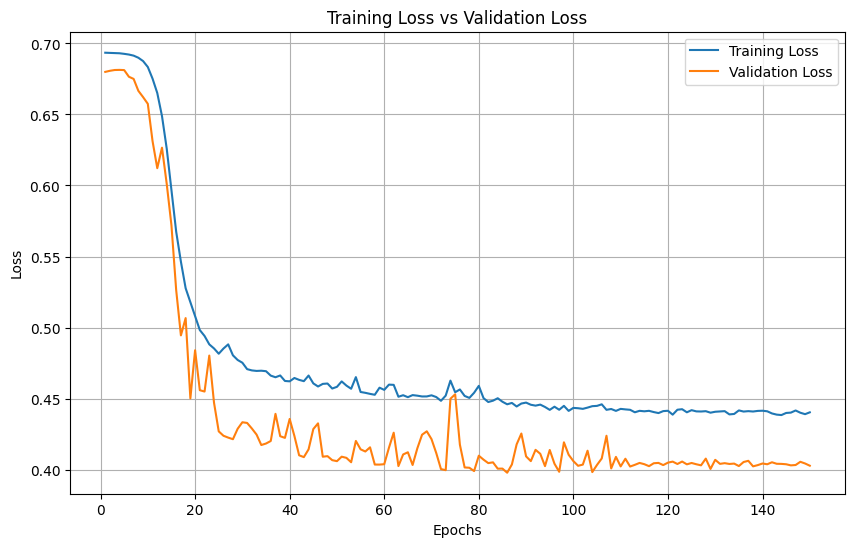

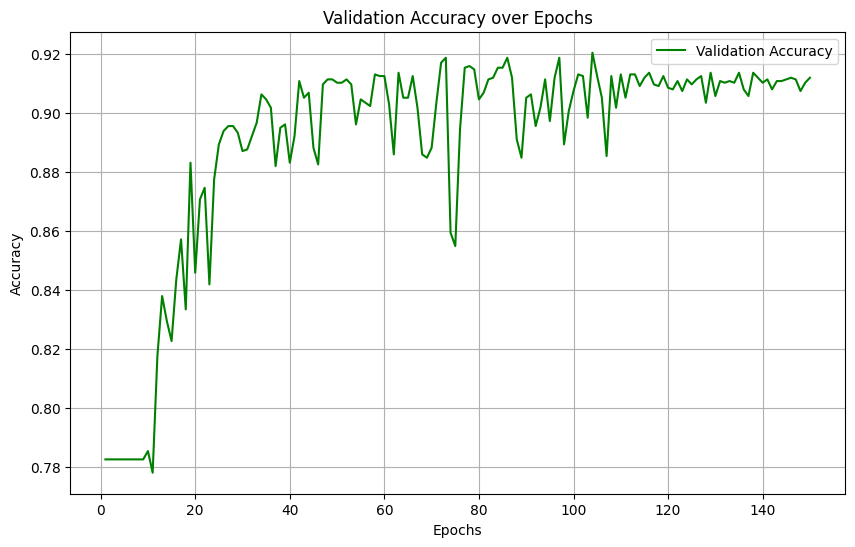

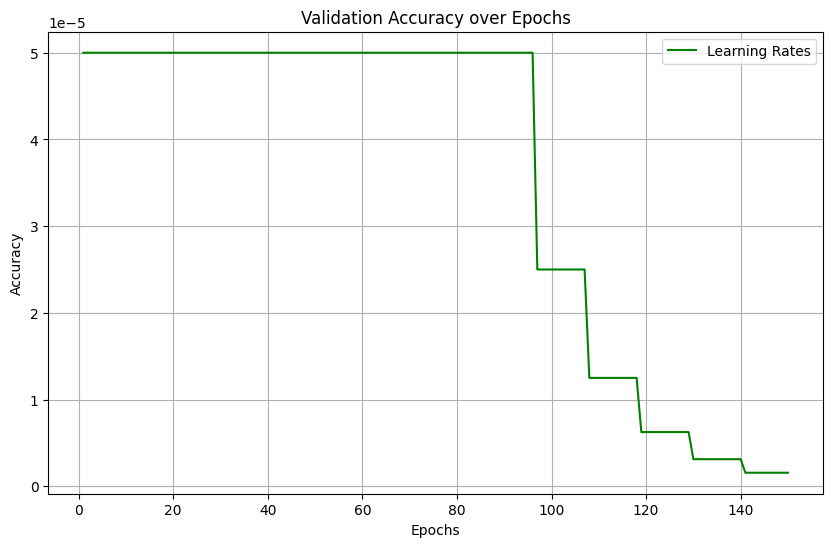

Model for bin 31 saved to 3DCholesterolModels-5A_exp1/model_bin_31.pth
1925 is length of subset grid
Training on bin 32
Bin 32, Epoch 1/150, Train Loss: 0.6930, Validation Loss: 0.6849, Validation Accuracy: 0.7825, Grad Norm: 0.0370, LR: 0.000050
Bin 32, Epoch 11/150, Train Loss: 0.5944, Validation Loss: 0.5448, Validation Accuracy: 0.8525, Grad Norm: 5.6658, LR: 0.000050
Bin 32, Epoch 21/150, Train Loss: 0.4741, Validation Loss: 0.4270, Validation Accuracy: 0.8966, Grad Norm: 0.3339, LR: 0.000050
Bin 32, Epoch 31/150, Train Loss: 0.4605, Validation Loss: 0.4169, Validation Accuracy: 0.9000, Grad Norm: 0.5633, LR: 0.000050
Bin 32, Epoch 41/150, Train Loss: 0.4578, Validation Loss: 0.4206, Validation Accuracy: 0.8944, Grad Norm: 2.9437, LR: 0.000025
Bin 32, Epoch 51/150, Train Loss: 0.4508, Validation Loss: 0.4116, Validation Accuracy: 0.9045, Grad Norm: 4.9213, LR: 0.000025
Bin 32, Epoch 61/150, Train Loss: 0.4504, Validation Loss: 0.4107, Validation Accuracy: 0.9068, Grad Norm: 0.3227

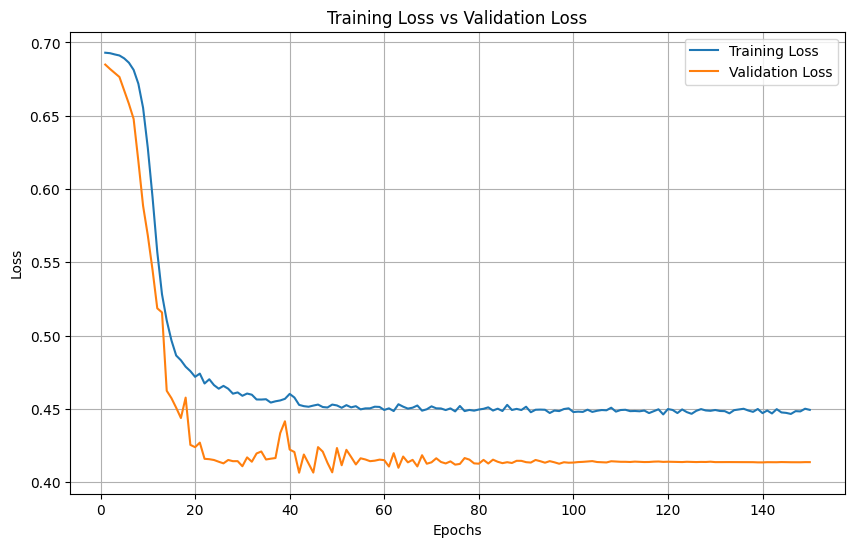

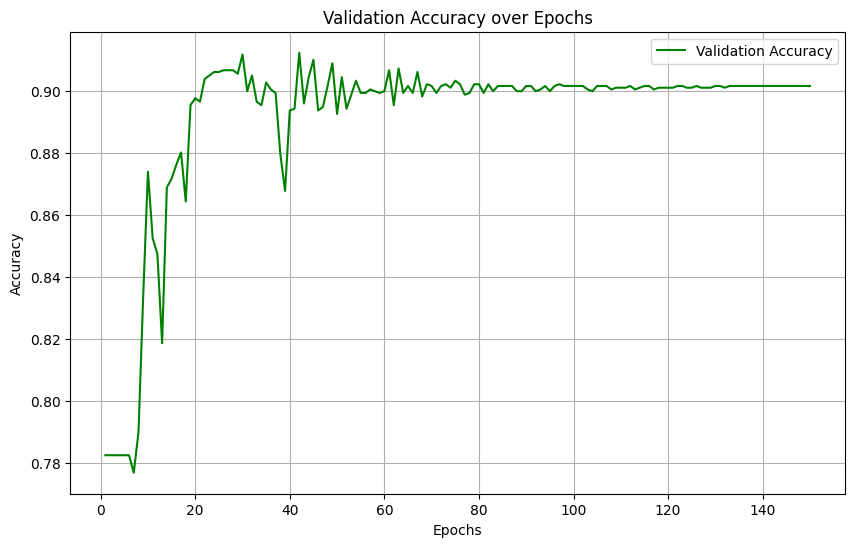

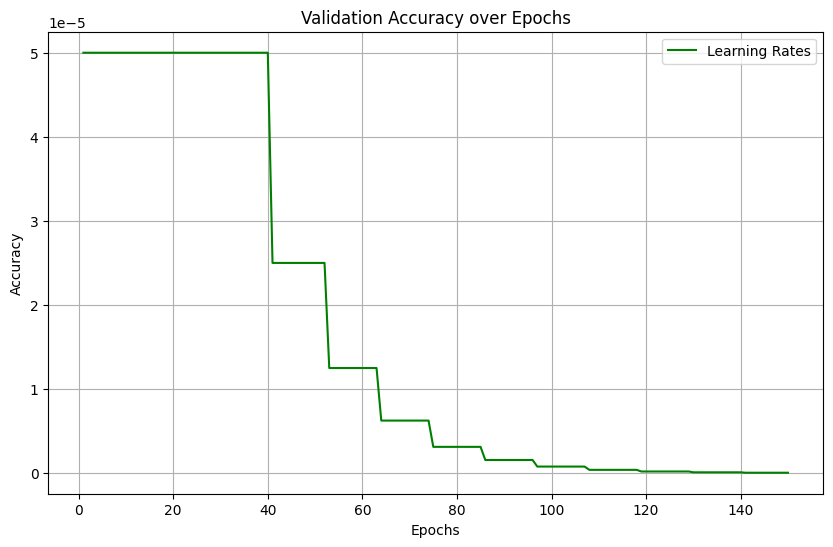

Model for bin 32 saved to 3DCholesterolModels-5A_exp1/model_bin_32.pth
1925 is length of subset grid
Training on bin 33
Bin 33, Epoch 1/150, Train Loss: 0.6930, Validation Loss: 0.6898, Validation Accuracy: 0.7825, Grad Norm: 0.0597, LR: 0.000050
Bin 33, Epoch 11/150, Train Loss: 0.6153, Validation Loss: 0.5496, Validation Accuracy: 0.8678, Grad Norm: 1.0368, LR: 0.000050
Bin 33, Epoch 21/150, Train Loss: 0.4829, Validation Loss: 0.4411, Validation Accuracy: 0.8836, Grad Norm: 1.9918, LR: 0.000050
Bin 33, Epoch 31/150, Train Loss: 0.4663, Validation Loss: 0.4363, Validation Accuracy: 0.8802, Grad Norm: 0.3513, LR: 0.000050
Bin 33, Epoch 41/150, Train Loss: 0.4603, Validation Loss: 0.4297, Validation Accuracy: 0.8831, Grad Norm: 5.2351, LR: 0.000050
Bin 33, Epoch 51/150, Train Loss: 0.4560, Validation Loss: 0.4239, Validation Accuracy: 0.8876, Grad Norm: 6.0958, LR: 0.000025
Bin 33, Epoch 61/150, Train Loss: 0.4542, Validation Loss: 0.4255, Validation Accuracy: 0.8859, Grad Norm: 1.1921

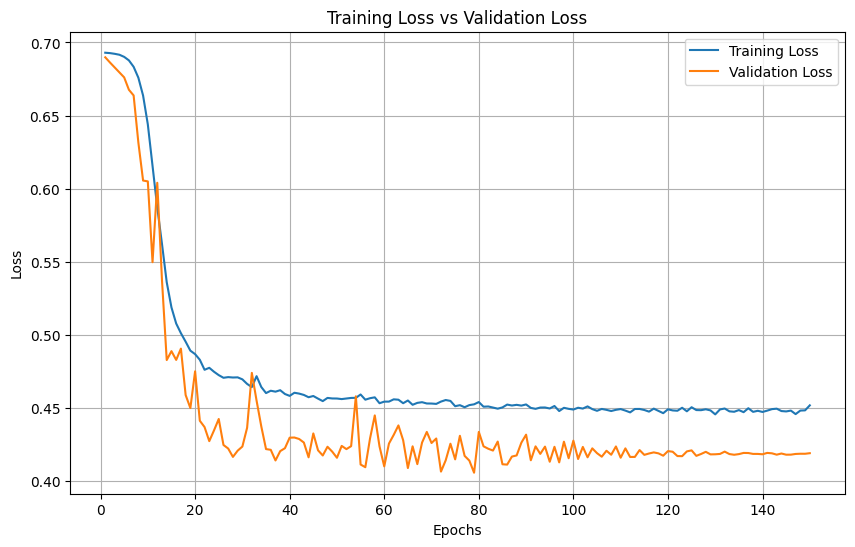

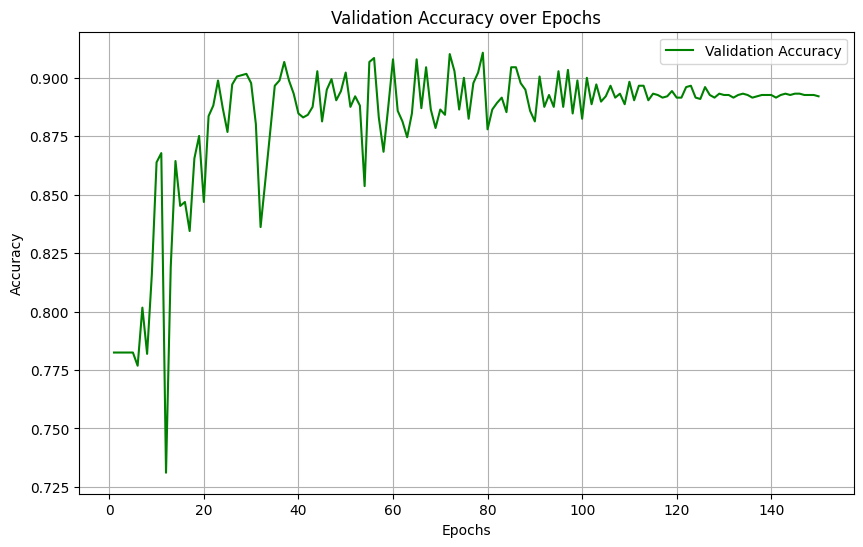

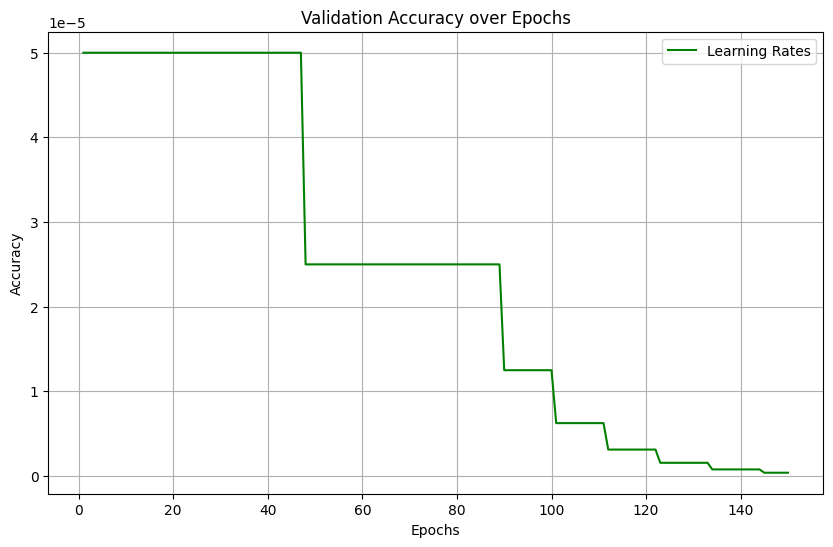

Model for bin 33 saved to 3DCholesterolModels-5A_exp1/model_bin_33.pth
1925 is length of subset grid
Training on bin 34
Bin 34, Epoch 1/150, Train Loss: 0.6931, Validation Loss: 0.6971, Validation Accuracy: 0.2175, Grad Norm: 0.0132, LR: 0.000050
Bin 34, Epoch 11/150, Train Loss: 0.6263, Validation Loss: 0.5608, Validation Accuracy: 0.8678, Grad Norm: 1.4586, LR: 0.000050
Bin 34, Epoch 21/150, Train Loss: 0.4841, Validation Loss: 0.4615, Validation Accuracy: 0.8689, Grad Norm: 2.9748, LR: 0.000050
Bin 34, Epoch 31/150, Train Loss: 0.4648, Validation Loss: 0.4140, Validation Accuracy: 0.9068, Grad Norm: 3.4751, LR: 0.000050
Bin 34, Epoch 41/150, Train Loss: 0.4595, Validation Loss: 0.4243, Validation Accuracy: 0.8932, Grad Norm: 2.2524, LR: 0.000050
Bin 34, Epoch 51/150, Train Loss: 0.4514, Validation Loss: 0.4141, Validation Accuracy: 0.9028, Grad Norm: 1.1224, LR: 0.000025
Bin 34, Epoch 61/150, Train Loss: 0.4526, Validation Loss: 0.4142, Validation Accuracy: 0.9011, Grad Norm: 0.3559

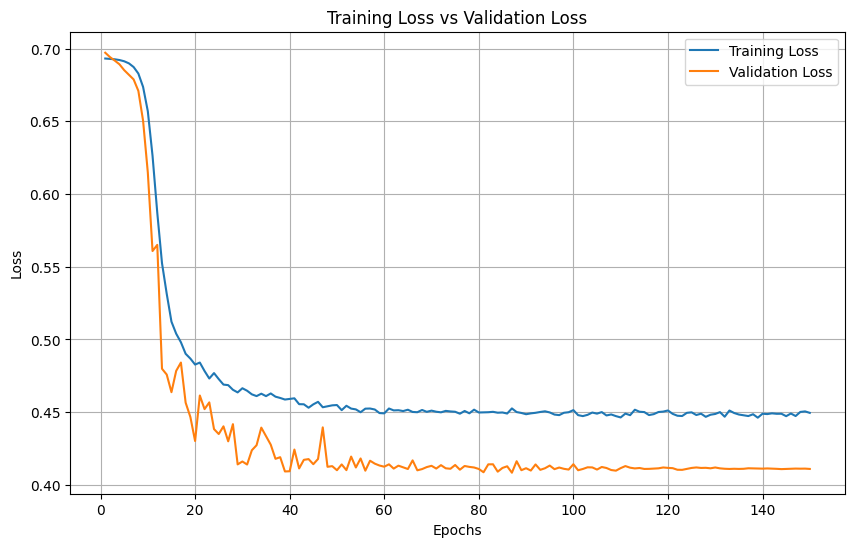

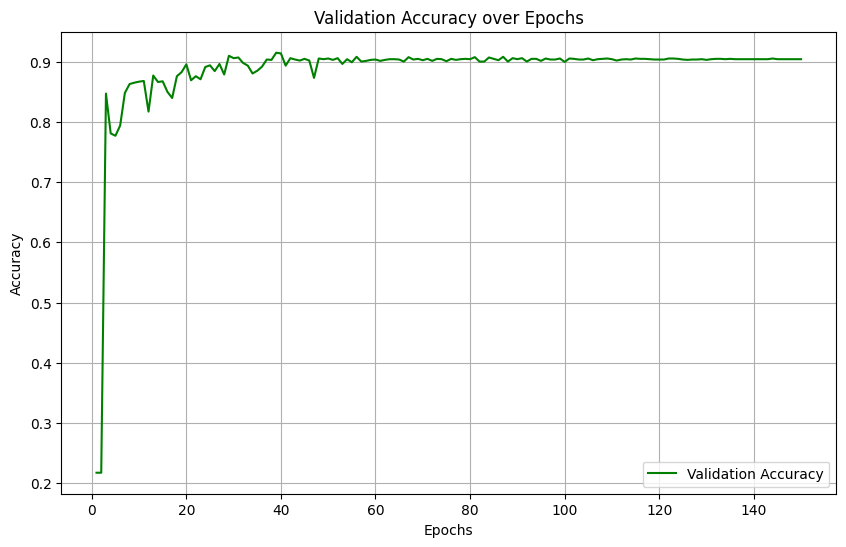

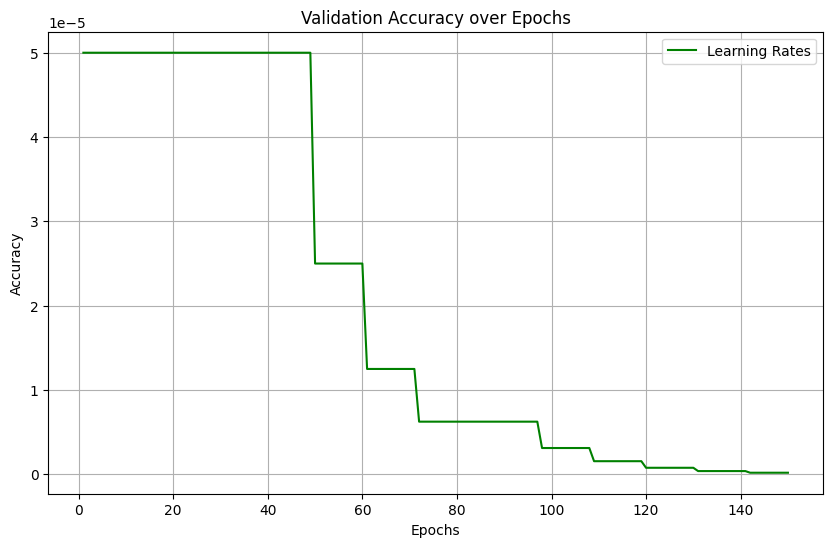

Model for bin 34 saved to 3DCholesterolModels-5A_exp1/model_bin_34.pth
1925 is length of subset grid
Training on bin 35
Bin 35, Epoch 1/150, Train Loss: 0.6932, Validation Loss: 0.7014, Validation Accuracy: 0.2175, Grad Norm: 0.0380, LR: 0.000050
Bin 35, Epoch 11/150, Train Loss: 0.6304, Validation Loss: 0.5354, Validation Accuracy: 0.8514, Grad Norm: 0.9750, LR: 0.000050
Bin 35, Epoch 21/150, Train Loss: 0.4740, Validation Loss: 0.4755, Validation Accuracy: 0.8452, Grad Norm: 4.8529, LR: 0.000050
Bin 35, Epoch 31/150, Train Loss: 0.4605, Validation Loss: 0.4151, Validation Accuracy: 0.9051, Grad Norm: 4.5840, LR: 0.000050
Bin 35, Epoch 41/150, Train Loss: 0.4543, Validation Loss: 0.4116, Validation Accuracy: 0.9090, Grad Norm: 3.8215, LR: 0.000050
Bin 35, Epoch 51/150, Train Loss: 0.4538, Validation Loss: 0.4117, Validation Accuracy: 0.9045, Grad Norm: 0.5972, LR: 0.000025
Bin 35, Epoch 61/150, Train Loss: 0.4510, Validation Loss: 0.4119, Validation Accuracy: 0.9040, Grad Norm: 0.3591

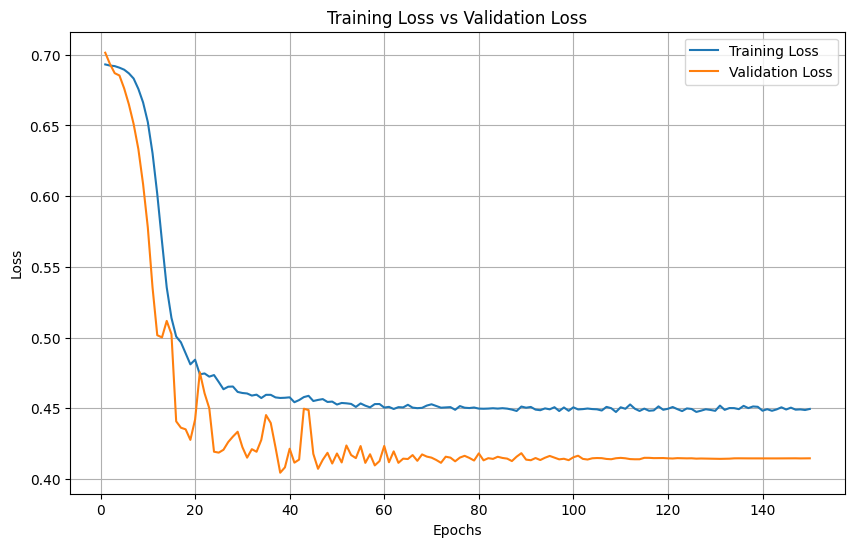

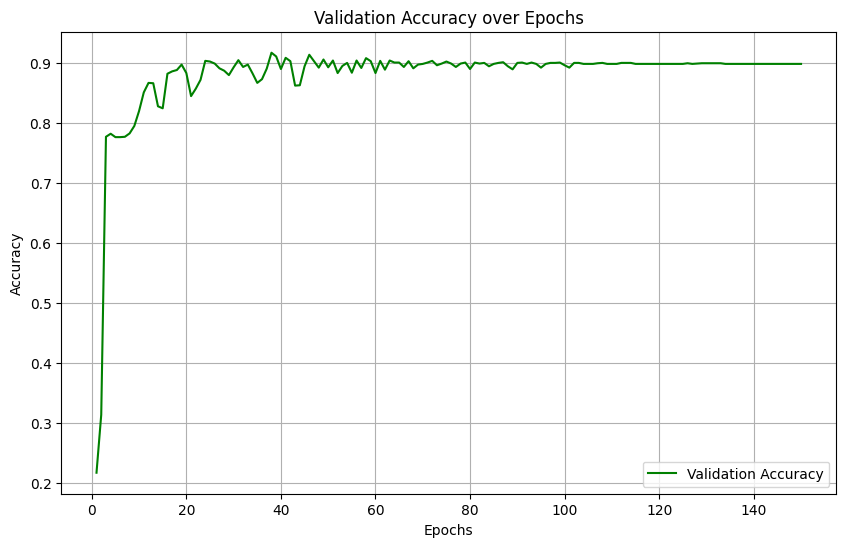

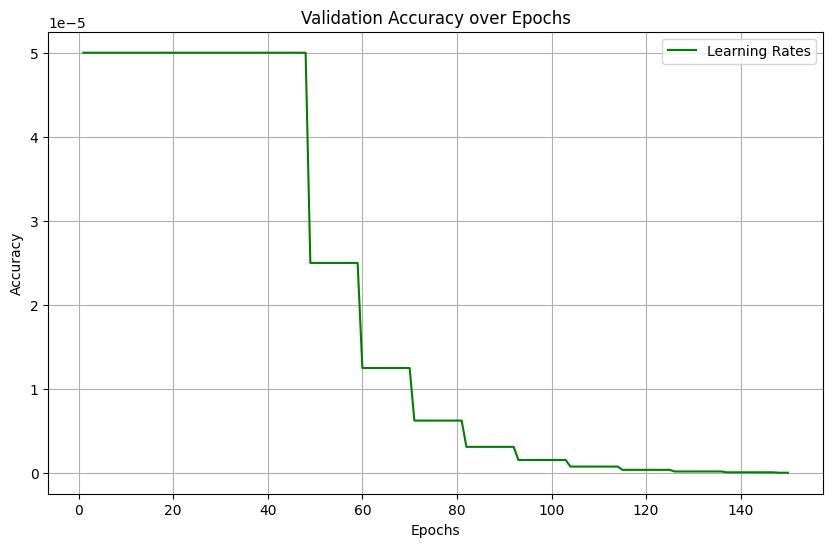

Model for bin 35 saved to 3DCholesterolModels-5A_exp1/model_bin_35.pth
1925 is length of subset grid
Training on bin 36
Bin 36, Epoch 1/150, Train Loss: 0.6930, Validation Loss: 0.6878, Validation Accuracy: 0.7825, Grad Norm: 0.0578, LR: 0.000050
Bin 36, Epoch 11/150, Train Loss: 0.6189, Validation Loss: 0.5542, Validation Accuracy: 0.8712, Grad Norm: 1.4424, LR: 0.000050
Bin 36, Epoch 21/150, Train Loss: 0.4939, Validation Loss: 0.4623, Validation Accuracy: 0.8644, Grad Norm: 1.4949, LR: 0.000050
Bin 36, Epoch 31/150, Train Loss: 0.4719, Validation Loss: 0.4696, Validation Accuracy: 0.8480, Grad Norm: 5.9025, LR: 0.000050
Bin 36, Epoch 41/150, Train Loss: 0.4651, Validation Loss: 0.4365, Validation Accuracy: 0.8785, Grad Norm: 5.4110, LR: 0.000050
Bin 36, Epoch 51/150, Train Loss: 0.4615, Validation Loss: 0.4106, Validation Accuracy: 0.9090, Grad Norm: 2.3999, LR: 0.000050
Bin 36, Epoch 61/150, Train Loss: 0.4578, Validation Loss: 0.4273, Validation Accuracy: 0.8836, Grad Norm: 0.2910

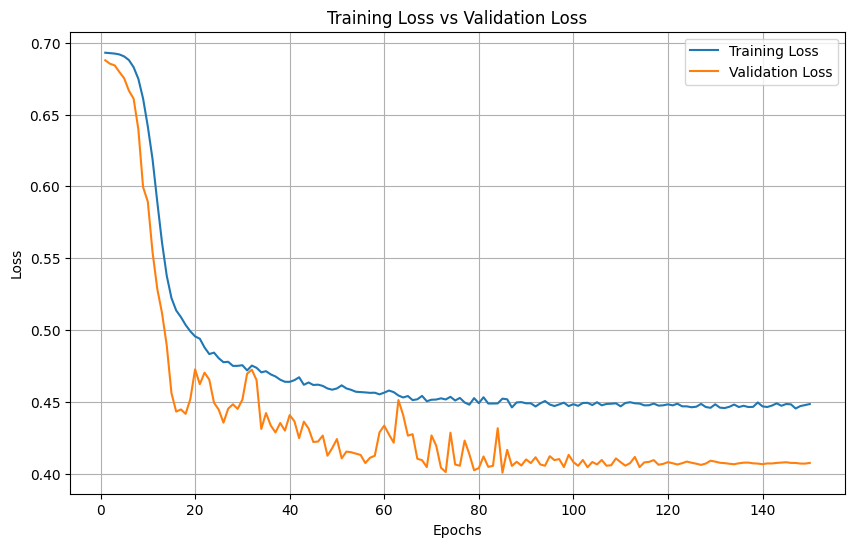

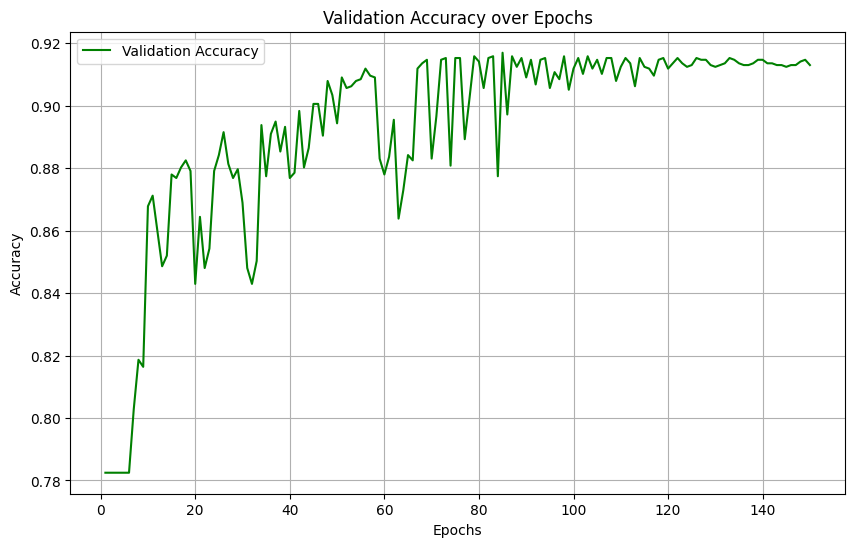

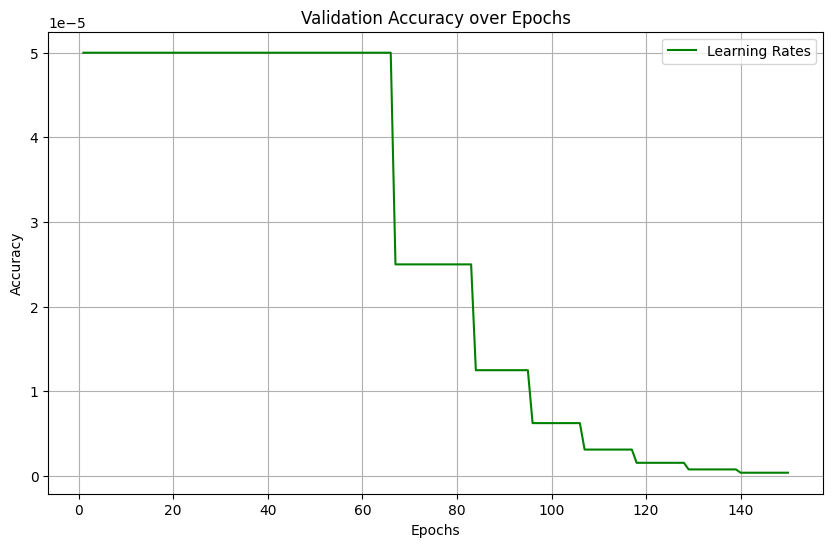

Model for bin 36 saved to 3DCholesterolModels-5A_exp1/model_bin_36.pth
1925 is length of subset grid
Training on bin 37
Bin 37, Epoch 1/150, Train Loss: 0.6931, Validation Loss: 0.6968, Validation Accuracy: 0.2175, Grad Norm: 0.0525, LR: 0.000050
Bin 37, Epoch 11/150, Train Loss: 0.6307, Validation Loss: 0.6263, Validation Accuracy: 0.7802, Grad Norm: 2.9937, LR: 0.000050
Bin 37, Epoch 21/150, Train Loss: 0.4822, Validation Loss: 0.4766, Validation Accuracy: 0.8441, Grad Norm: 4.0569, LR: 0.000050
Bin 37, Epoch 31/150, Train Loss: 0.4608, Validation Loss: 0.4267, Validation Accuracy: 0.8977, Grad Norm: 0.4095, LR: 0.000050
Bin 37, Epoch 41/150, Train Loss: 0.4533, Validation Loss: 0.4409, Validation Accuracy: 0.8751, Grad Norm: 3.5802, LR: 0.000050
Bin 37, Epoch 51/150, Train Loss: 0.4495, Validation Loss: 0.4263, Validation Accuracy: 0.8842, Grad Norm: 4.2244, LR: 0.000050
Bin 37, Epoch 61/150, Train Loss: 0.4660, Validation Loss: 0.4217, Validation Accuracy: 0.8927, Grad Norm: 6.1632

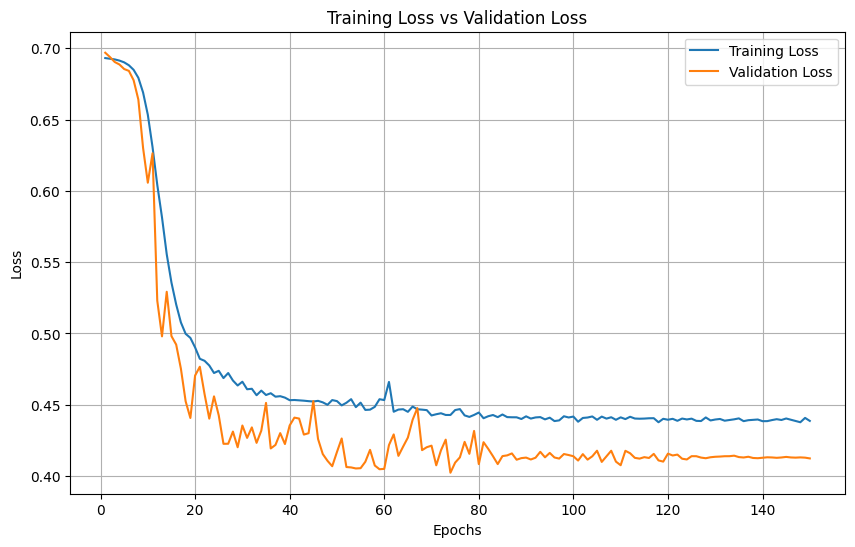

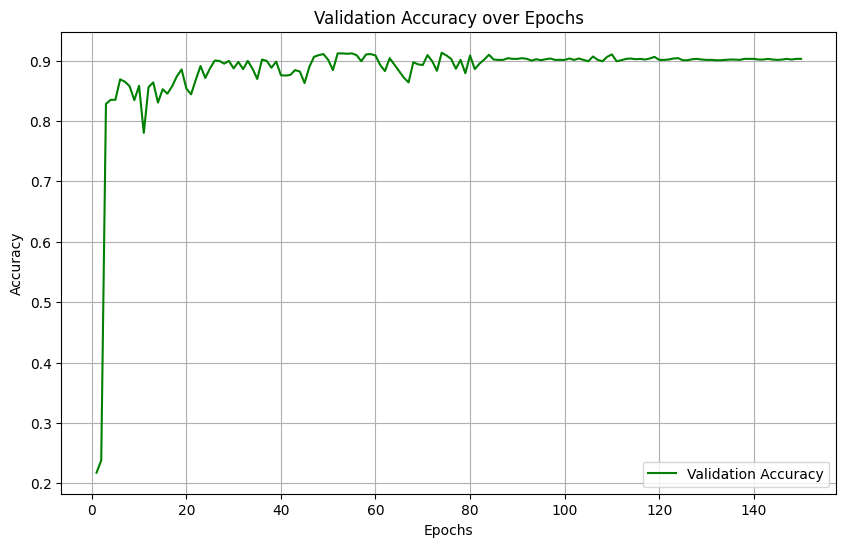

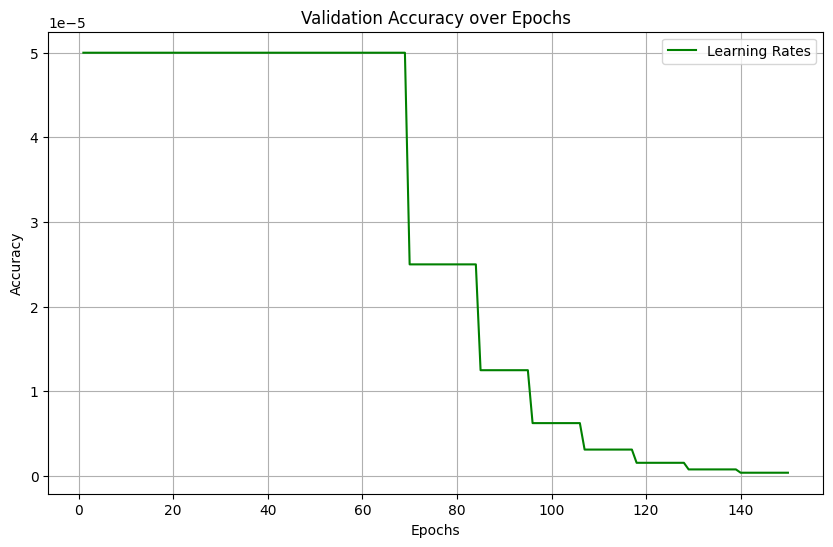

Model for bin 37 saved to 3DCholesterolModels-5A_exp1/model_bin_37.pth
1925 is length of subset grid
Training on bin 38
Bin 38, Epoch 1/150, Train Loss: 0.6933, Validation Loss: 0.7020, Validation Accuracy: 0.2175, Grad Norm: 0.1557, LR: 0.000050
Bin 38, Epoch 11/150, Train Loss: 0.6264, Validation Loss: 0.5800, Validation Accuracy: 0.8548, Grad Norm: 2.3589, LR: 0.000050
Bin 38, Epoch 21/150, Train Loss: 0.4833, Validation Loss: 0.4355, Validation Accuracy: 0.8915, Grad Norm: 6.0974, LR: 0.000050
Bin 38, Epoch 31/150, Train Loss: 0.4647, Validation Loss: 0.4160, Validation Accuracy: 0.9045, Grad Norm: 2.0809, LR: 0.000050
Bin 38, Epoch 41/150, Train Loss: 0.4580, Validation Loss: 0.4089, Validation Accuracy: 0.9107, Grad Norm: 0.6528, LR: 0.000050
Bin 38, Epoch 51/150, Train Loss: 0.4564, Validation Loss: 0.4066, Validation Accuracy: 0.9119, Grad Norm: 6.0981, LR: 0.000050
Bin 38, Epoch 61/150, Train Loss: 0.4522, Validation Loss: 0.4176, Validation Accuracy: 0.8972, Grad Norm: 5.8076

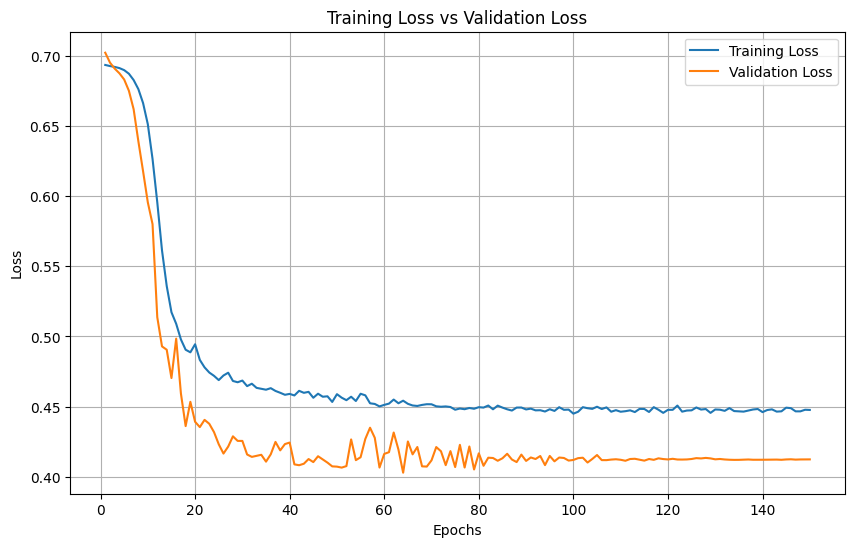

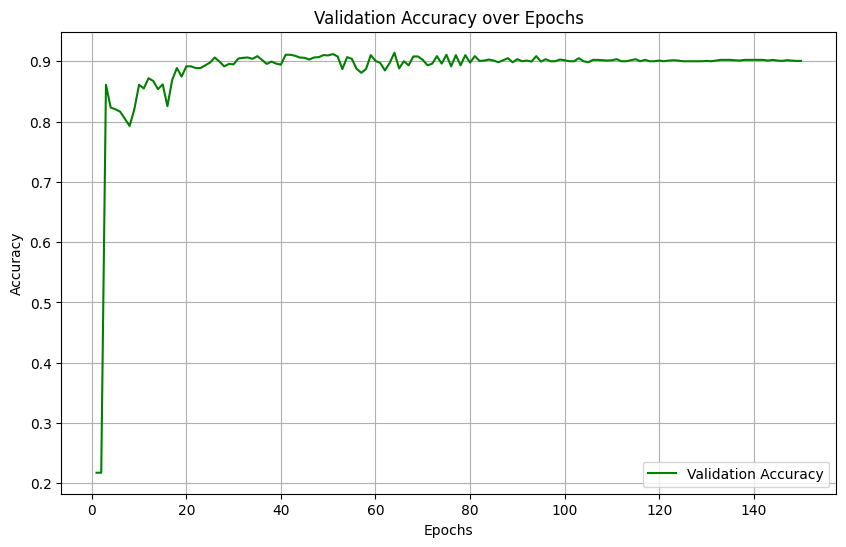

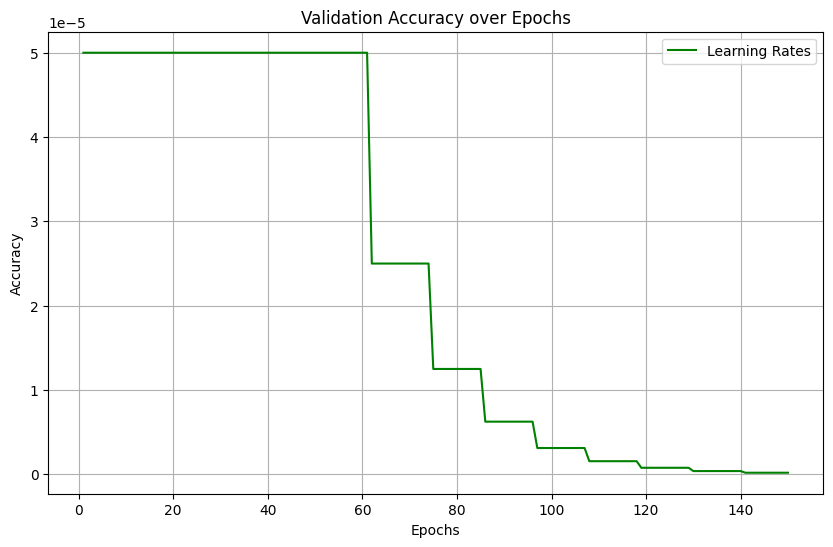

Model for bin 38 saved to 3DCholesterolModels-5A_exp1/model_bin_38.pth
1925 is length of subset grid
Training on bin 39
Bin 39, Epoch 1/150, Train Loss: 0.6930, Validation Loss: 0.6876, Validation Accuracy: 0.7825, Grad Norm: 0.0280, LR: 0.000050
Bin 39, Epoch 11/150, Train Loss: 0.5766, Validation Loss: 0.5841, Validation Accuracy: 0.7689, Grad Norm: 3.4206, LR: 0.000050
Bin 39, Epoch 21/150, Train Loss: 0.4641, Validation Loss: 0.4214, Validation Accuracy: 0.9034, Grad Norm: 3.6697, LR: 0.000050
Bin 39, Epoch 31/150, Train Loss: 0.4548, Validation Loss: 0.4479, Validation Accuracy: 0.8633, Grad Norm: 4.7178, LR: 0.000050
Bin 39, Epoch 41/150, Train Loss: 0.4481, Validation Loss: 0.4177, Validation Accuracy: 0.9040, Grad Norm: 2.0576, LR: 0.000050
Bin 39, Epoch 51/150, Train Loss: 0.4463, Validation Loss: 0.4196, Validation Accuracy: 0.8966, Grad Norm: 1.5241, LR: 0.000025
Bin 39, Epoch 61/150, Train Loss: 0.4445, Validation Loss: 0.4106, Validation Accuracy: 0.9079, Grad Norm: 1.3728

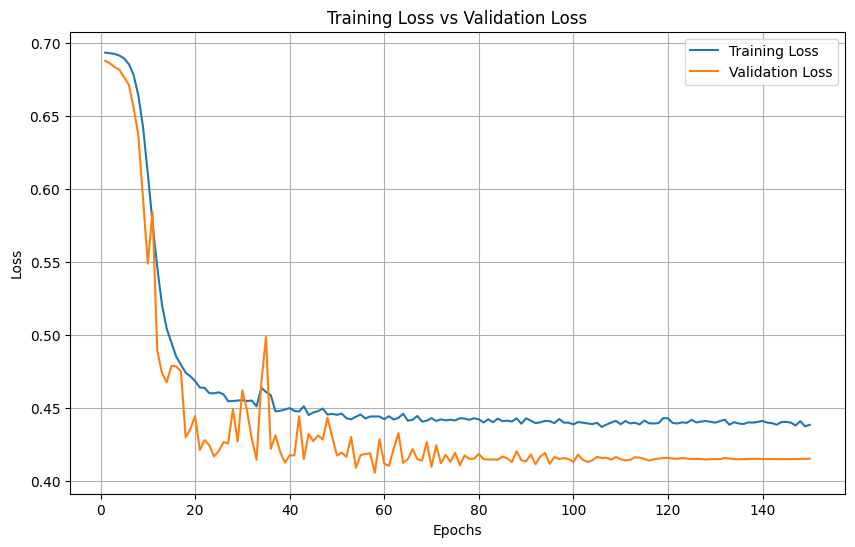

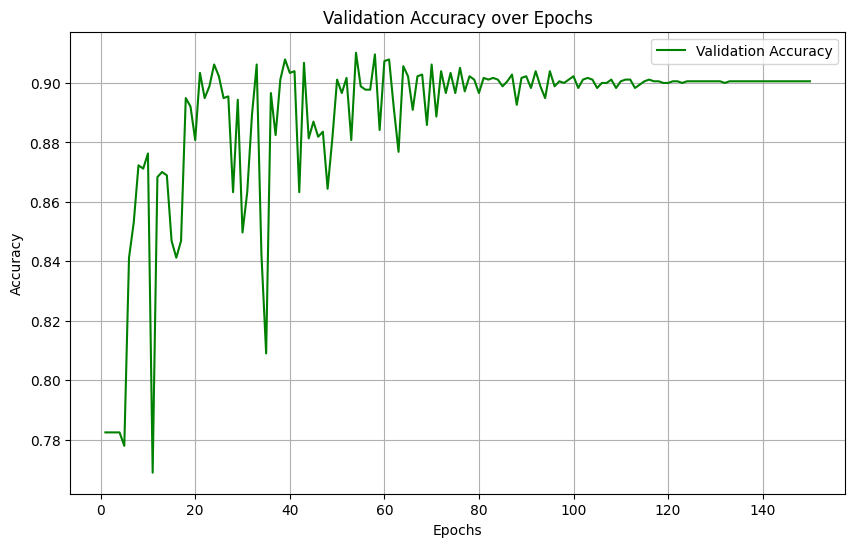

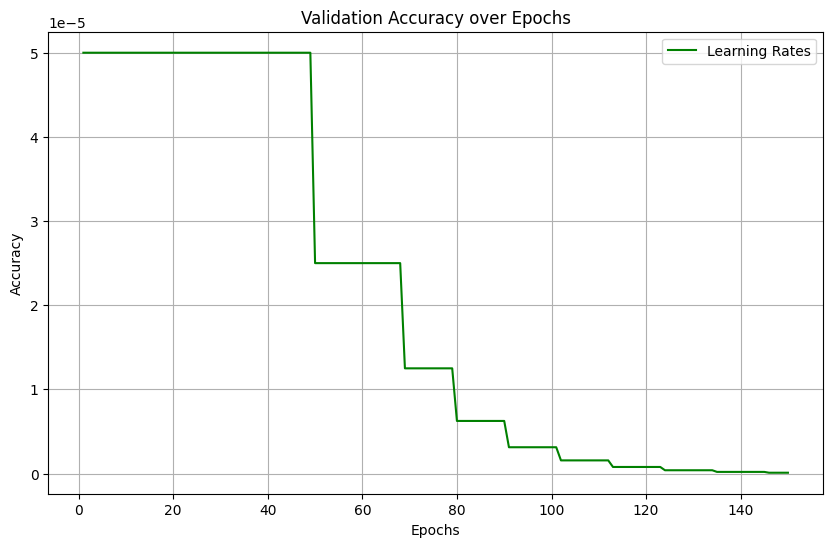

Model for bin 39 saved to 3DCholesterolModels-5A_exp1/model_bin_39.pth
1925 is length of subset grid
Training on bin 40
Bin 40, Epoch 1/150, Train Loss: 0.6930, Validation Loss: 0.6913, Validation Accuracy: 0.7825, Grad Norm: 0.0345, LR: 0.000050
Bin 40, Epoch 11/150, Train Loss: 0.6112, Validation Loss: 0.5285, Validation Accuracy: 0.8678, Grad Norm: 4.8869, LR: 0.000050
Bin 40, Epoch 21/150, Train Loss: 0.4745, Validation Loss: 0.4289, Validation Accuracy: 0.8944, Grad Norm: 0.7125, LR: 0.000050
Bin 40, Epoch 31/150, Train Loss: 0.4611, Validation Loss: 0.4339, Validation Accuracy: 0.8831, Grad Norm: 2.4358, LR: 0.000050
Bin 40, Epoch 41/150, Train Loss: 0.4587, Validation Loss: 0.4583, Validation Accuracy: 0.8497, Grad Norm: 5.2460, LR: 0.000050
Bin 40, Epoch 51/150, Train Loss: 0.4524, Validation Loss: 0.4387, Validation Accuracy: 0.8740, Grad Norm: 3.5447, LR: 0.000025
Bin 40, Epoch 61/150, Train Loss: 0.4515, Validation Loss: 0.4445, Validation Accuracy: 0.8684, Grad Norm: 6.7292

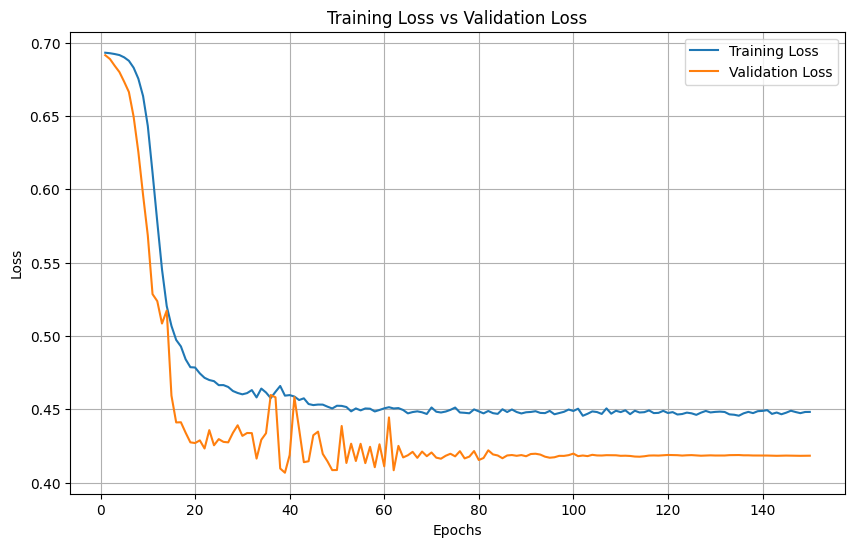

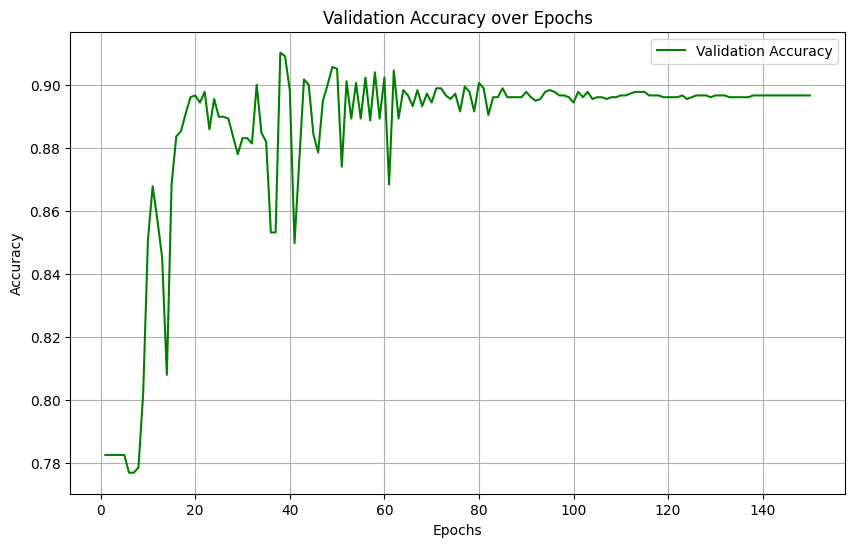

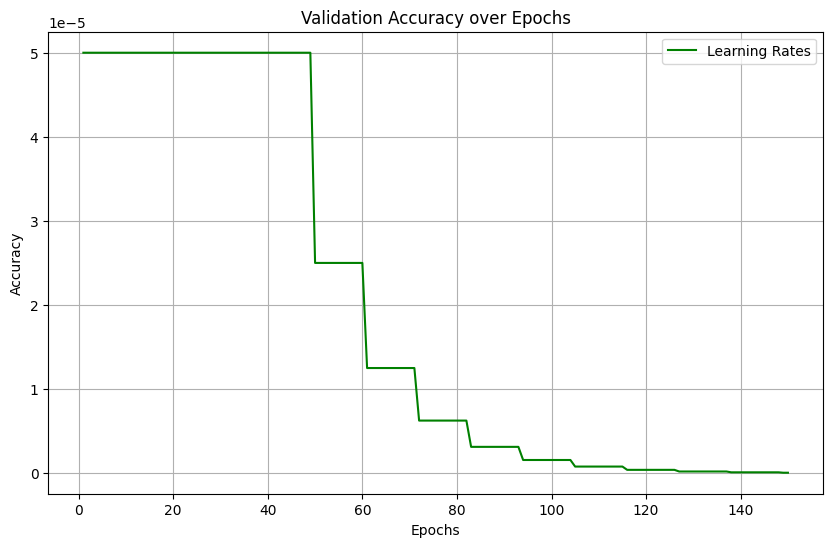

Model for bin 40 saved to 3DCholesterolModels-5A_exp1/model_bin_40.pth
1925 is length of subset grid
Training on bin 41
Bin 41, Epoch 1/150, Train Loss: 0.6931, Validation Loss: 0.6964, Validation Accuracy: 0.2175, Grad Norm: 0.0852, LR: 0.000050
Bin 41, Epoch 11/150, Train Loss: 0.6164, Validation Loss: 0.5323, Validation Accuracy: 0.8644, Grad Norm: 3.5802, LR: 0.000050
Bin 41, Epoch 21/150, Train Loss: 0.4750, Validation Loss: 0.4463, Validation Accuracy: 0.8853, Grad Norm: 5.2335, LR: 0.000050
Bin 41, Epoch 31/150, Train Loss: 0.4582, Validation Loss: 0.4416, Validation Accuracy: 0.8746, Grad Norm: 2.9437, LR: 0.000050
Bin 41, Epoch 41/150, Train Loss: 0.4504, Validation Loss: 0.4088, Validation Accuracy: 0.9090, Grad Norm: 3.8702, LR: 0.000050
Bin 41, Epoch 51/150, Train Loss: 0.4473, Validation Loss: 0.3998, Validation Accuracy: 0.9175, Grad Norm: 0.6844, LR: 0.000050
Bin 41, Epoch 61/150, Train Loss: 0.4438, Validation Loss: 0.4177, Validation Accuracy: 0.8955, Grad Norm: 2.6894

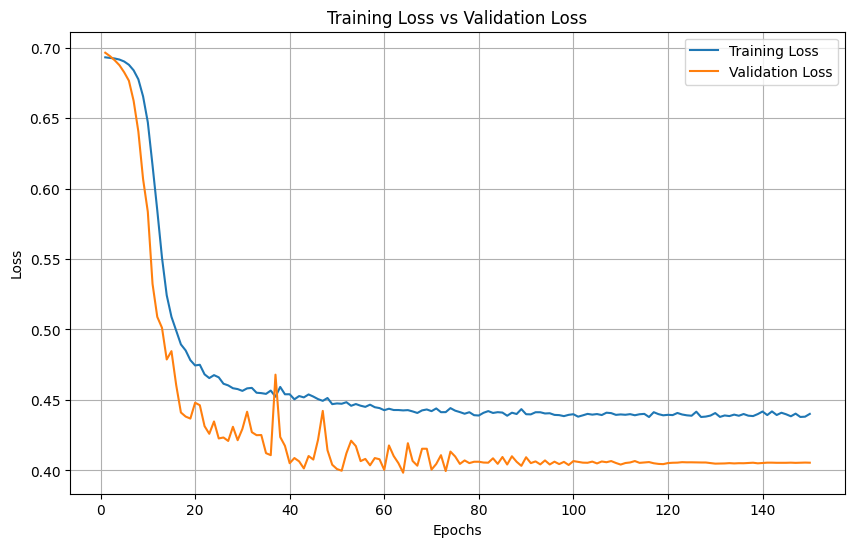

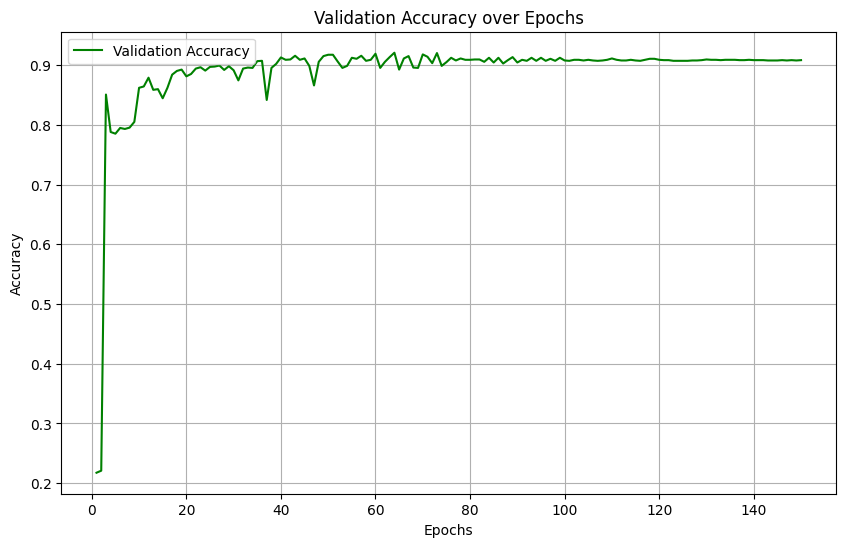

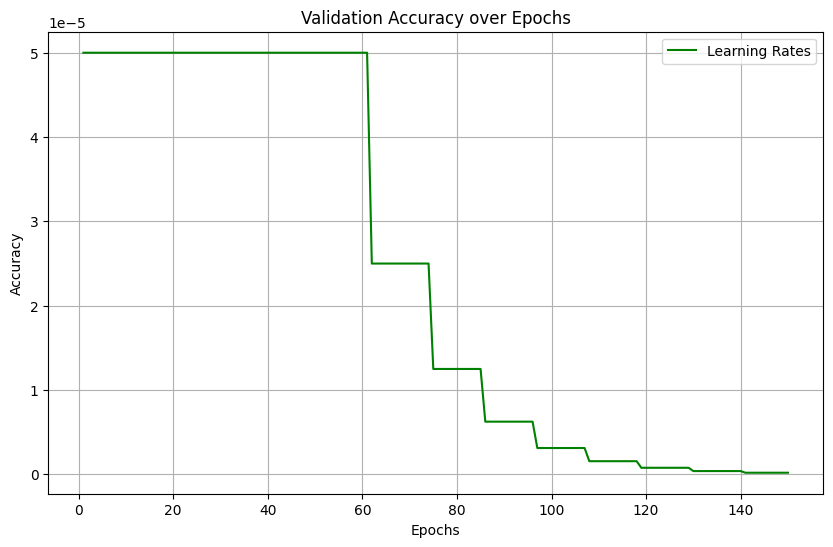

Model for bin 41 saved to 3DCholesterolModels-5A_exp1/model_bin_41.pth
1925 is length of subset grid
Training on bin 42
Bin 42, Epoch 1/150, Train Loss: 0.6929, Validation Loss: 0.6886, Validation Accuracy: 0.7825, Grad Norm: 0.0222, LR: 0.000050
Bin 42, Epoch 11/150, Train Loss: 0.5845, Validation Loss: 0.4997, Validation Accuracy: 0.8706, Grad Norm: 1.8517, LR: 0.000050
Bin 42, Epoch 21/150, Train Loss: 0.4695, Validation Loss: 0.4355, Validation Accuracy: 0.8904, Grad Norm: 1.1530, LR: 0.000050
Bin 42, Epoch 31/150, Train Loss: 0.4577, Validation Loss: 0.4456, Validation Accuracy: 0.8706, Grad Norm: 0.3679, LR: 0.000050
Bin 42, Epoch 41/150, Train Loss: 0.4551, Validation Loss: 0.4109, Validation Accuracy: 0.9090, Grad Norm: 0.9535, LR: 0.000050
Bin 42, Epoch 51/150, Train Loss: 0.4538, Validation Loss: 0.4223, Validation Accuracy: 0.8910, Grad Norm: 2.4317, LR: 0.000050
Bin 42, Epoch 61/150, Train Loss: 0.4498, Validation Loss: 0.4213, Validation Accuracy: 0.8910, Grad Norm: 6.2161

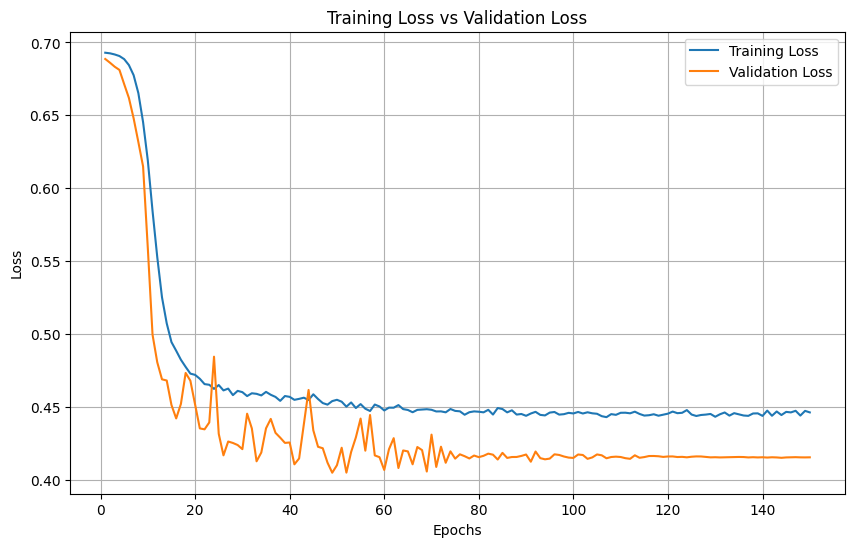

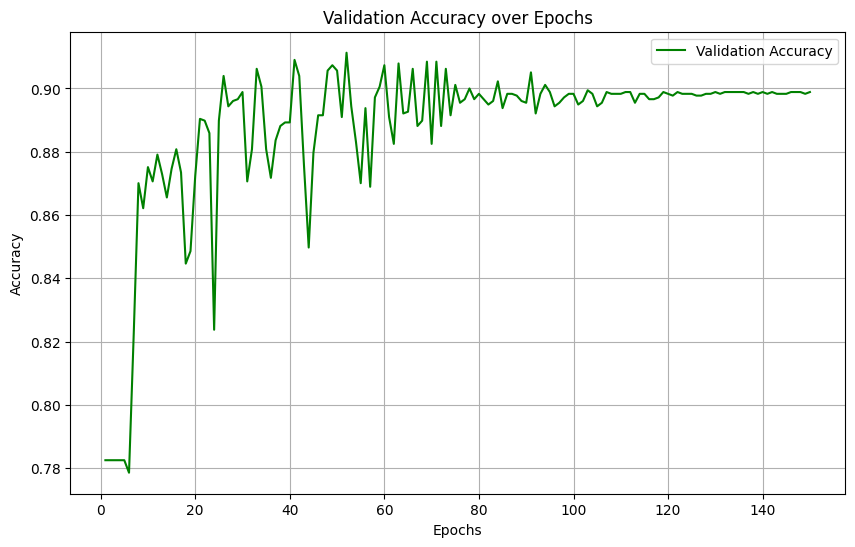

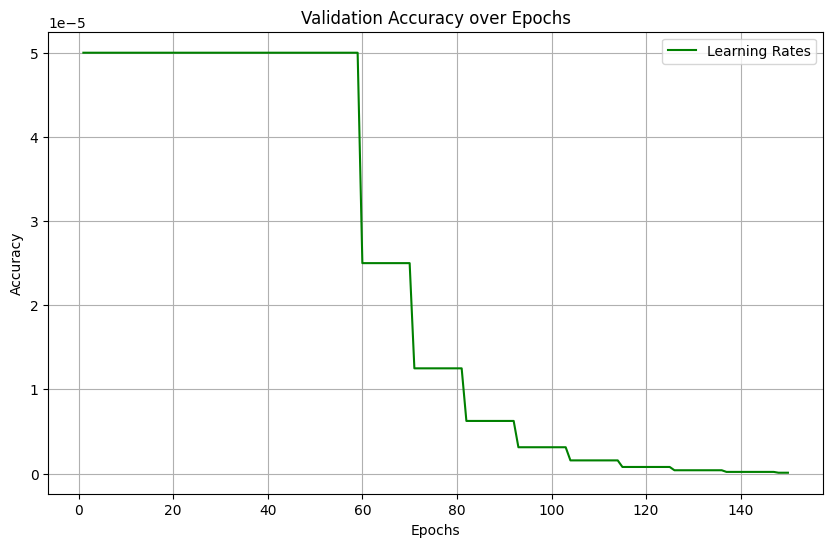

Model for bin 42 saved to 3DCholesterolModels-5A_exp1/model_bin_42.pth
1925 is length of subset grid
Training on bin 43
Bin 43, Epoch 1/150, Train Loss: 0.6934, Validation Loss: 0.6742, Validation Accuracy: 0.7825, Grad Norm: 0.0497, LR: 0.000050
Bin 43, Epoch 11/150, Train Loss: 0.5784, Validation Loss: 0.5312, Validation Accuracy: 0.8520, Grad Norm: 0.9098, LR: 0.000050
Bin 43, Epoch 21/150, Train Loss: 0.4692, Validation Loss: 0.4292, Validation Accuracy: 0.8932, Grad Norm: 4.4076, LR: 0.000050
Bin 43, Epoch 31/150, Train Loss: 0.4581, Validation Loss: 0.4211, Validation Accuracy: 0.8966, Grad Norm: 0.6929, LR: 0.000050
Bin 43, Epoch 41/150, Train Loss: 0.4596, Validation Loss: 0.4140, Validation Accuracy: 0.9017, Grad Norm: 5.4546, LR: 0.000050
Bin 43, Epoch 51/150, Train Loss: 0.4512, Validation Loss: 0.4300, Validation Accuracy: 0.8842, Grad Norm: 3.3590, LR: 0.000050
Bin 43, Epoch 61/150, Train Loss: 0.4497, Validation Loss: 0.4285, Validation Accuracy: 0.8847, Grad Norm: 2.9330

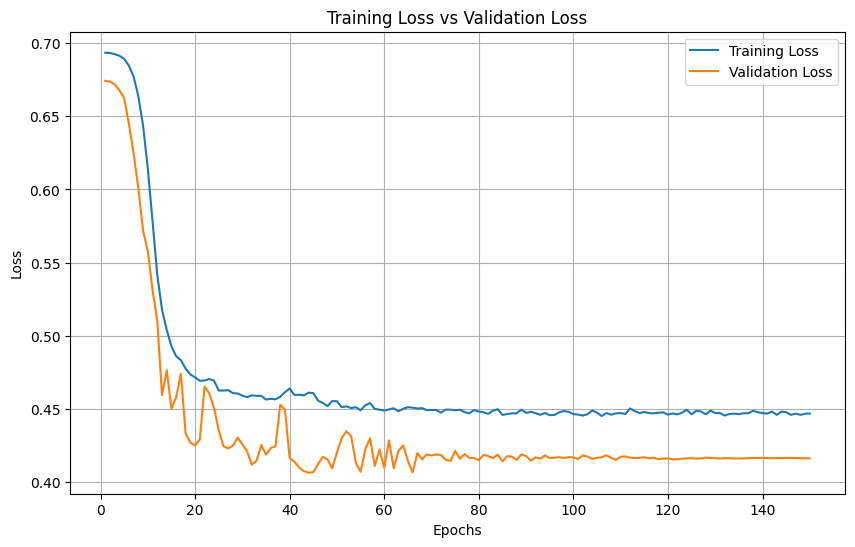

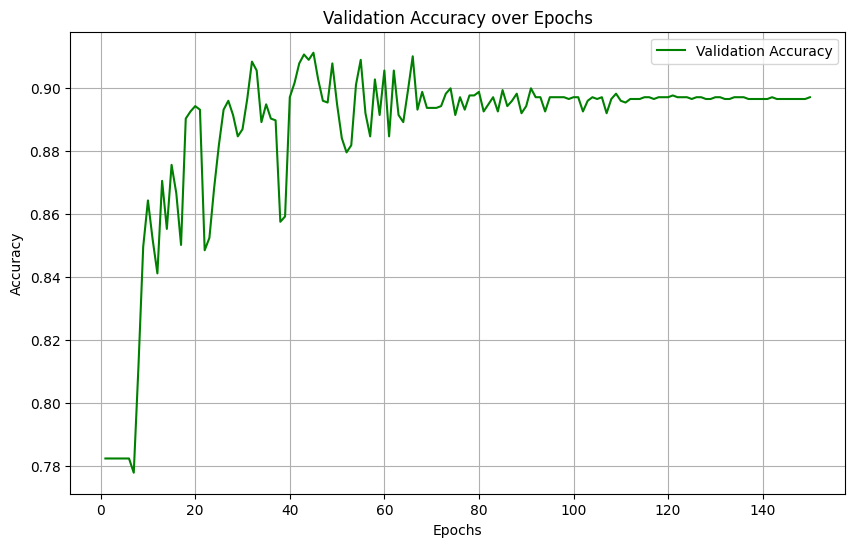

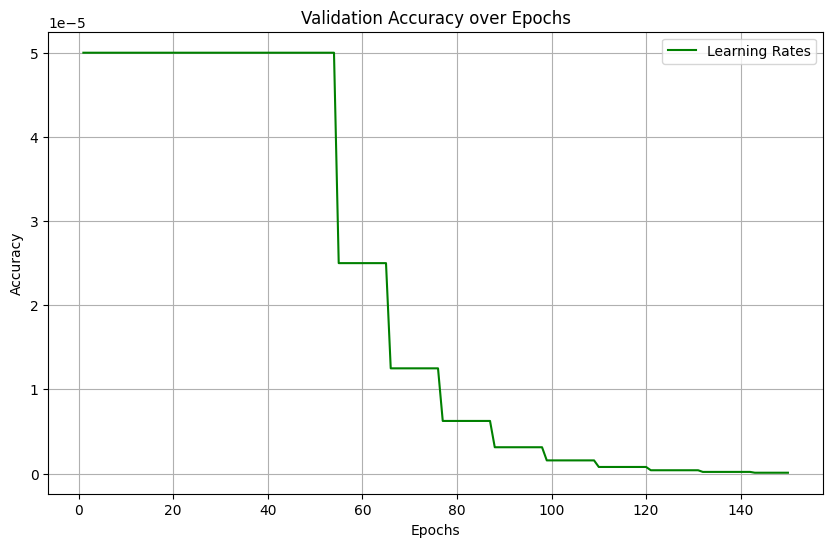

Model for bin 43 saved to 3DCholesterolModels-5A_exp1/model_bin_43.pth
1925 is length of subset grid
Training on bin 44
Bin 44, Epoch 1/150, Train Loss: 0.6931, Validation Loss: 0.6859, Validation Accuracy: 0.7825, Grad Norm: 0.0972, LR: 0.000050
Bin 44, Epoch 11/150, Train Loss: 0.6329, Validation Loss: 0.5936, Validation Accuracy: 0.8401, Grad Norm: 3.2050, LR: 0.000050
Bin 44, Epoch 21/150, Train Loss: 0.4868, Validation Loss: 0.4360, Validation Accuracy: 0.8876, Grad Norm: 1.5614, LR: 0.000050
Bin 44, Epoch 31/150, Train Loss: 0.4693, Validation Loss: 0.4304, Validation Accuracy: 0.8836, Grad Norm: 6.2398, LR: 0.000050
Bin 44, Epoch 41/150, Train Loss: 0.4612, Validation Loss: 0.4210, Validation Accuracy: 0.8932, Grad Norm: 5.8159, LR: 0.000050
Bin 44, Epoch 51/150, Train Loss: 0.4611, Validation Loss: 0.4499, Validation Accuracy: 0.8599, Grad Norm: 6.2749, LR: 0.000050
Bin 44, Epoch 61/150, Train Loss: 0.4516, Validation Loss: 0.4309, Validation Accuracy: 0.8831, Grad Norm: 0.7448

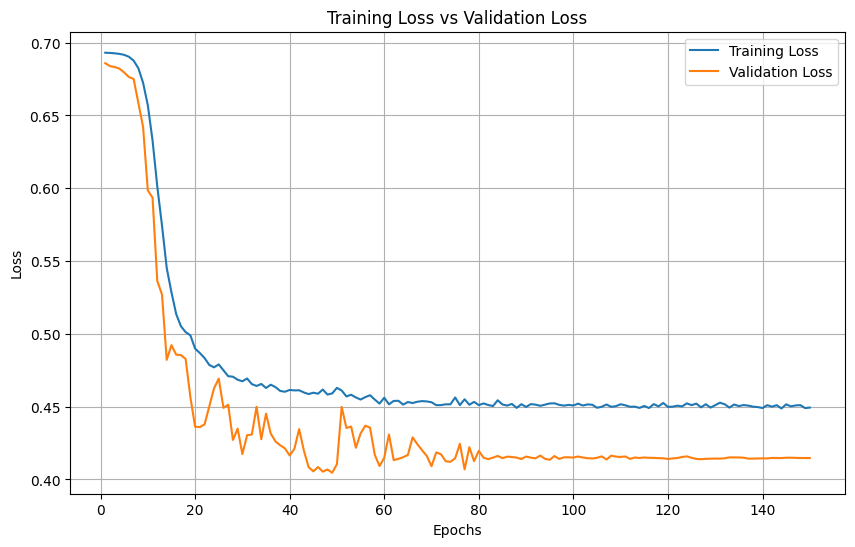

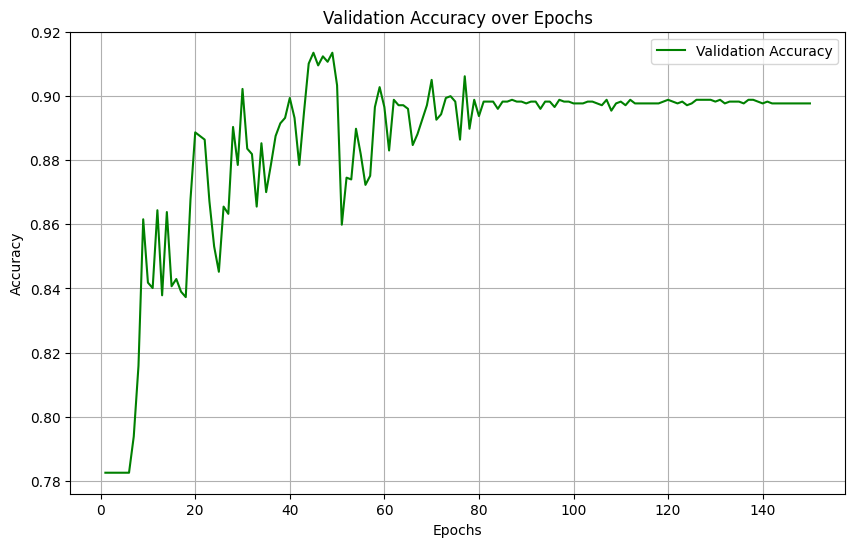

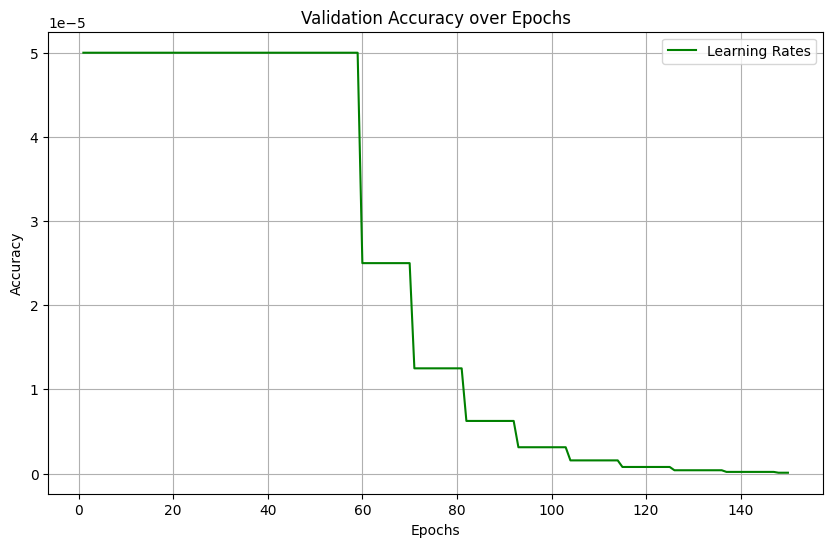

Model for bin 44 saved to 3DCholesterolModels-5A_exp1/model_bin_44.pth
1925 is length of subset grid
Training on bin 45
Bin 45, Epoch 1/150, Train Loss: 0.6931, Validation Loss: 0.6954, Validation Accuracy: 0.2175, Grad Norm: 0.0252, LR: 0.000050
Bin 45, Epoch 11/150, Train Loss: 0.6114, Validation Loss: 0.5790, Validation Accuracy: 0.8271, Grad Norm: 2.7634, LR: 0.000050
Bin 45, Epoch 21/150, Train Loss: 0.4747, Validation Loss: 0.4441, Validation Accuracy: 0.8780, Grad Norm: 0.8841, LR: 0.000050
Bin 45, Epoch 31/150, Train Loss: 0.4612, Validation Loss: 0.4136, Validation Accuracy: 0.9062, Grad Norm: 0.7931, LR: 0.000050
Bin 45, Epoch 41/150, Train Loss: 0.4620, Validation Loss: 0.4076, Validation Accuracy: 0.9124, Grad Norm: 6.2786, LR: 0.000025
Bin 45, Epoch 51/150, Train Loss: 0.4562, Validation Loss: 0.4157, Validation Accuracy: 0.9000, Grad Norm: 3.4944, LR: 0.000025
Bin 45, Epoch 61/150, Train Loss: 0.4537, Validation Loss: 0.4116, Validation Accuracy: 0.9034, Grad Norm: 1.4964

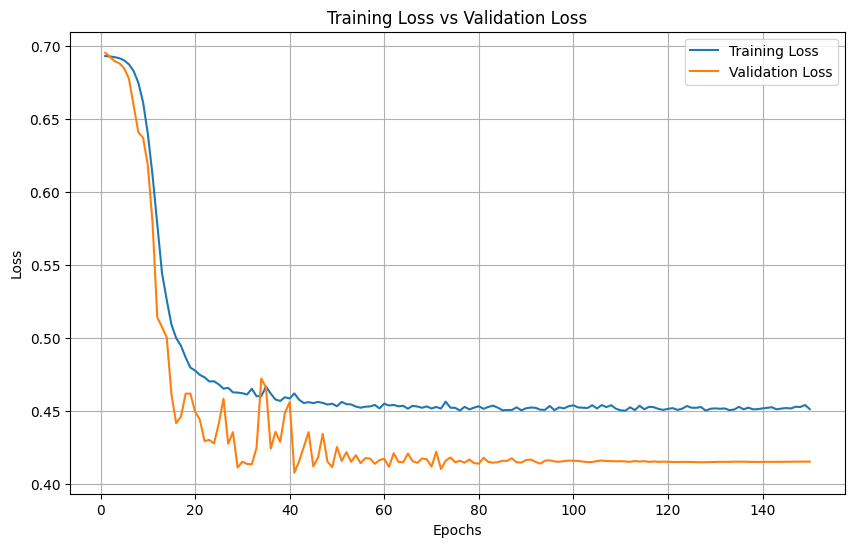

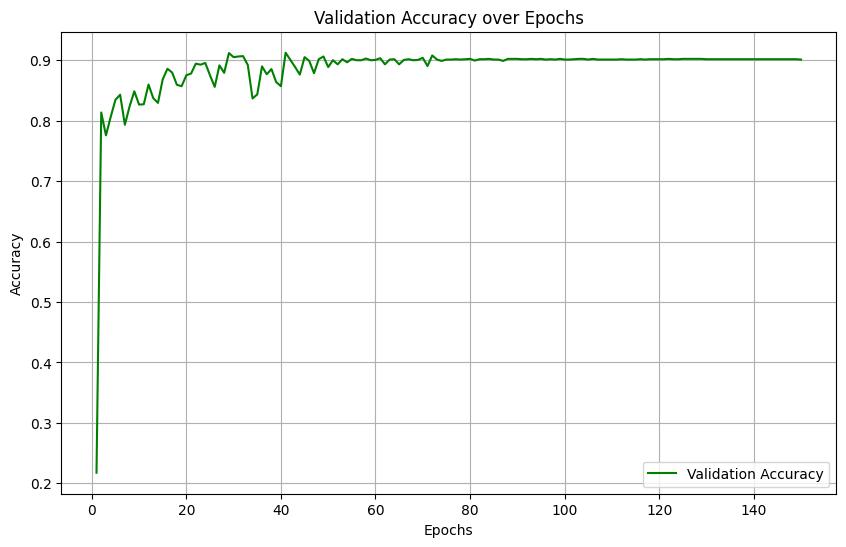

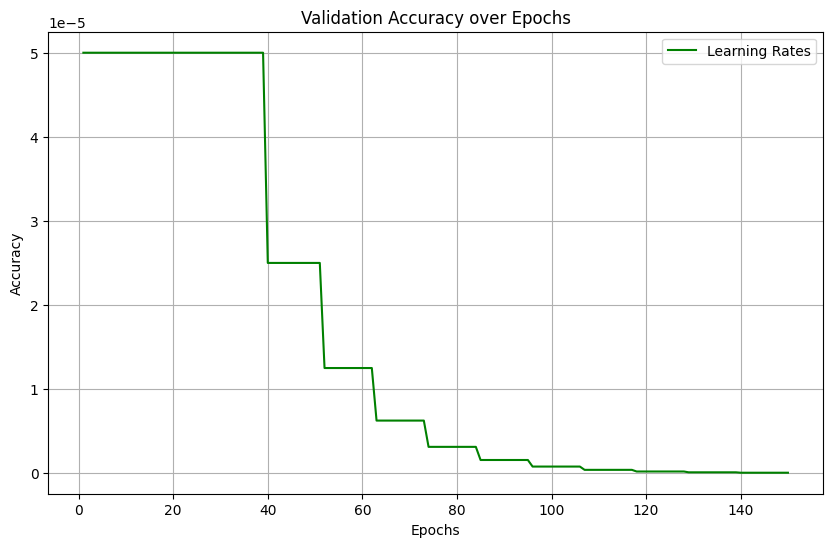

Model for bin 45 saved to 3DCholesterolModels-5A_exp1/model_bin_45.pth
1925 is length of subset grid
Training on bin 46
Bin 46, Epoch 1/150, Train Loss: 0.6930, Validation Loss: 0.6943, Validation Accuracy: 0.2175, Grad Norm: 0.0330, LR: 0.000050
Bin 46, Epoch 11/150, Train Loss: 0.5898, Validation Loss: 0.5095, Validation Accuracy: 0.8718, Grad Norm: 1.5380, LR: 0.000050
Bin 46, Epoch 21/150, Train Loss: 0.4760, Validation Loss: 0.4277, Validation Accuracy: 0.8955, Grad Norm: 1.4101, LR: 0.000050
Bin 46, Epoch 31/150, Train Loss: 0.4647, Validation Loss: 0.4195, Validation Accuracy: 0.8989, Grad Norm: 4.0569, LR: 0.000050
Bin 46, Epoch 41/150, Train Loss: 0.4560, Validation Loss: 0.4303, Validation Accuracy: 0.8785, Grad Norm: 4.2656, LR: 0.000050
Bin 46, Epoch 51/150, Train Loss: 0.4518, Validation Loss: 0.4387, Validation Accuracy: 0.8734, Grad Norm: 2.9677, LR: 0.000050
Bin 46, Epoch 61/150, Train Loss: 0.4499, Validation Loss: 0.4138, Validation Accuracy: 0.9011, Grad Norm: 3.3106

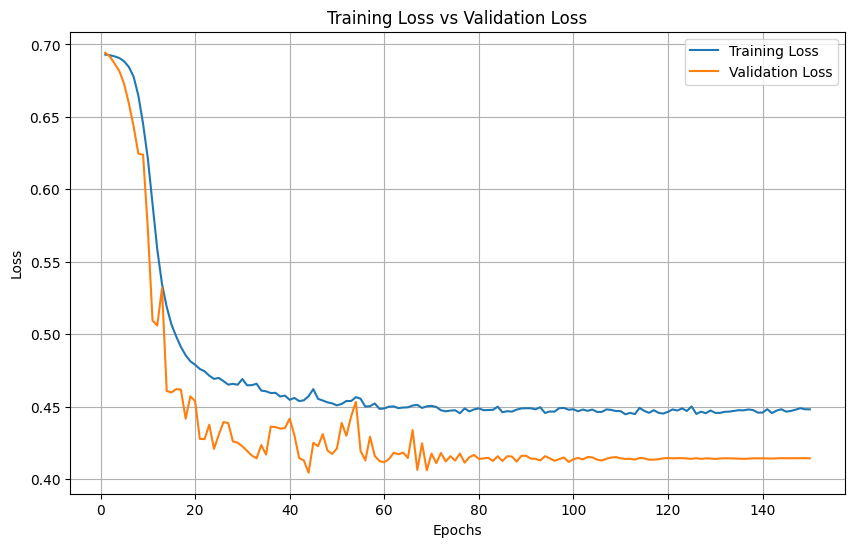

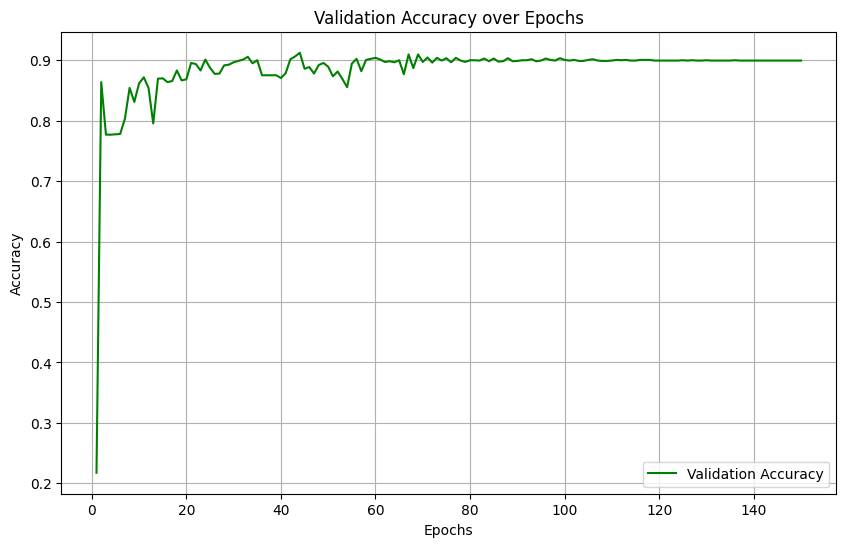

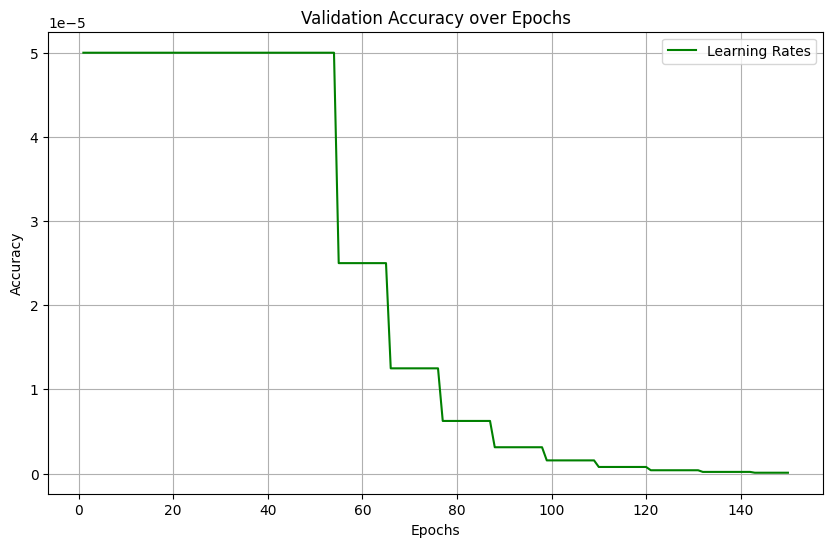

Model for bin 46 saved to 3DCholesterolModels-5A_exp1/model_bin_46.pth
1925 is length of subset grid
Training on bin 47
Bin 47, Epoch 1/150, Train Loss: 0.6930, Validation Loss: 0.6894, Validation Accuracy: 0.7825, Grad Norm: 0.0430, LR: 0.000050
Bin 47, Epoch 11/150, Train Loss: 0.6127, Validation Loss: 0.5611, Validation Accuracy: 0.8650, Grad Norm: 5.5597, LR: 0.000050
Bin 47, Epoch 21/150, Train Loss: 0.4665, Validation Loss: 0.4335, Validation Accuracy: 0.8898, Grad Norm: 4.1554, LR: 0.000050
Bin 47, Epoch 31/150, Train Loss: 0.4604, Validation Loss: 0.4255, Validation Accuracy: 0.8904, Grad Norm: 3.5810, LR: 0.000050
Bin 47, Epoch 41/150, Train Loss: 0.4475, Validation Loss: 0.4155, Validation Accuracy: 0.8989, Grad Norm: 2.1937, LR: 0.000050
Bin 47, Epoch 51/150, Train Loss: 0.4441, Validation Loss: 0.4231, Validation Accuracy: 0.8921, Grad Norm: 0.3662, LR: 0.000050
Bin 47, Epoch 61/150, Train Loss: 0.4436, Validation Loss: 0.4142, Validation Accuracy: 0.9023, Grad Norm: 0.5844

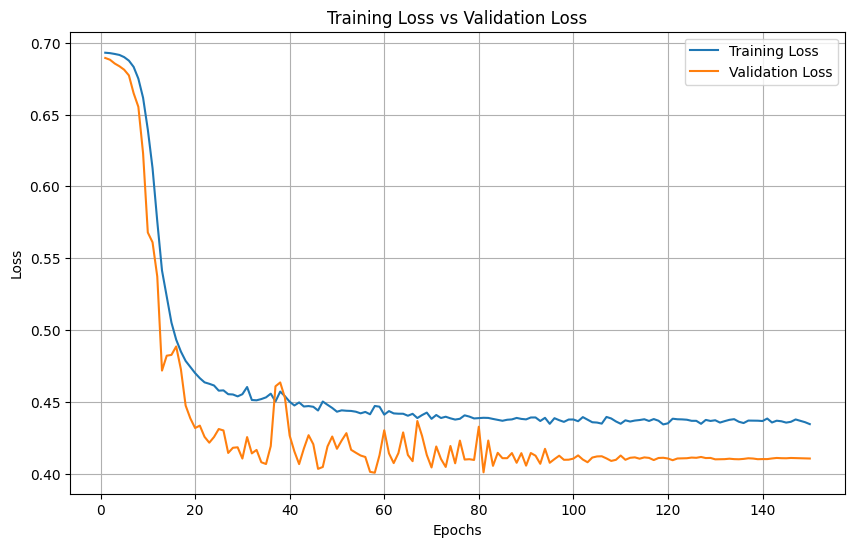

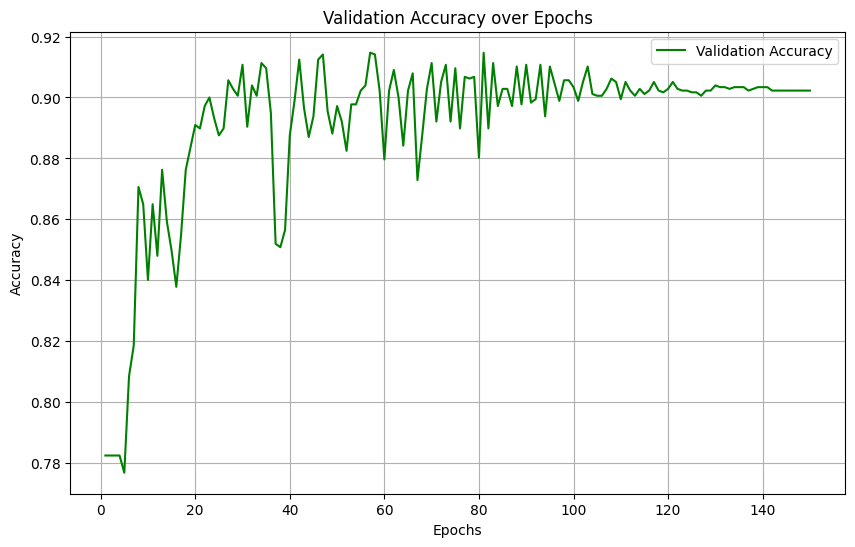

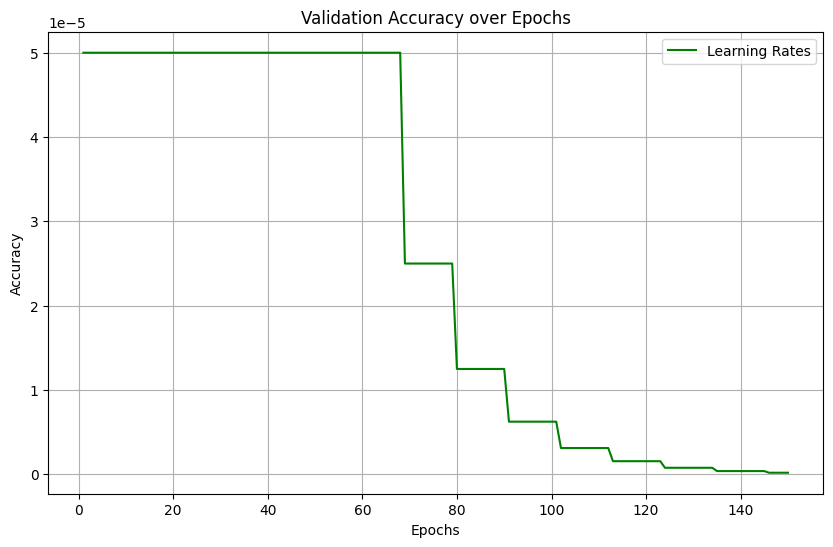

Model for bin 47 saved to 3DCholesterolModels-5A_exp1/model_bin_47.pth
1925 is length of subset grid
Training on bin 48
Bin 48, Epoch 1/150, Train Loss: 0.6930, Validation Loss: 0.6874, Validation Accuracy: 0.7825, Grad Norm: 0.0680, LR: 0.000050
Bin 48, Epoch 11/150, Train Loss: 0.6093, Validation Loss: 0.5607, Validation Accuracy: 0.8492, Grad Norm: 2.9741, LR: 0.000050
Bin 48, Epoch 21/150, Train Loss: 0.4751, Validation Loss: 0.4275, Validation Accuracy: 0.8938, Grad Norm: 4.7933, LR: 0.000050
Bin 48, Epoch 31/150, Train Loss: 0.4633, Validation Loss: 0.4230, Validation Accuracy: 0.8960, Grad Norm: 0.6076, LR: 0.000050
Bin 48, Epoch 41/150, Train Loss: 0.4570, Validation Loss: 0.4227, Validation Accuracy: 0.8910, Grad Norm: 3.4140, LR: 0.000050
Bin 48, Epoch 51/150, Train Loss: 0.4535, Validation Loss: 0.4159, Validation Accuracy: 0.8994, Grad Norm: 3.2332, LR: 0.000050
Bin 48, Epoch 61/150, Train Loss: 0.4560, Validation Loss: 0.4444, Validation Accuracy: 0.8610, Grad Norm: 6.3915

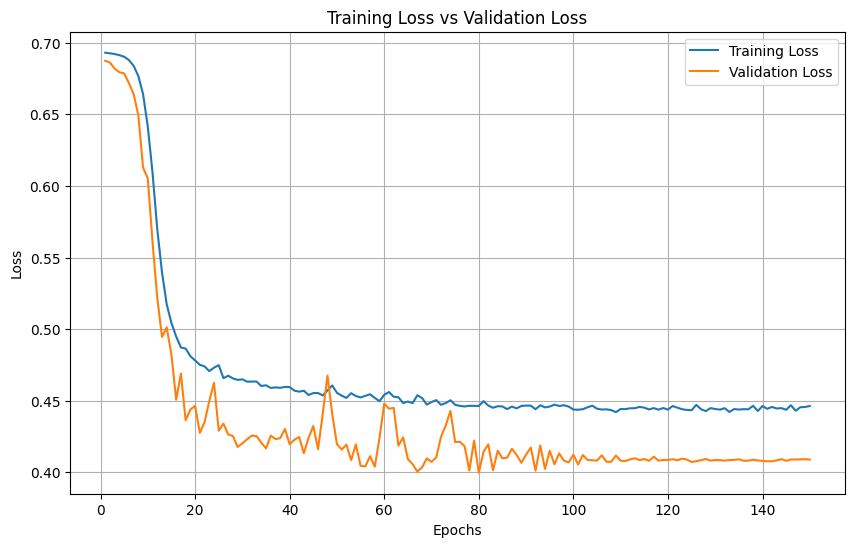

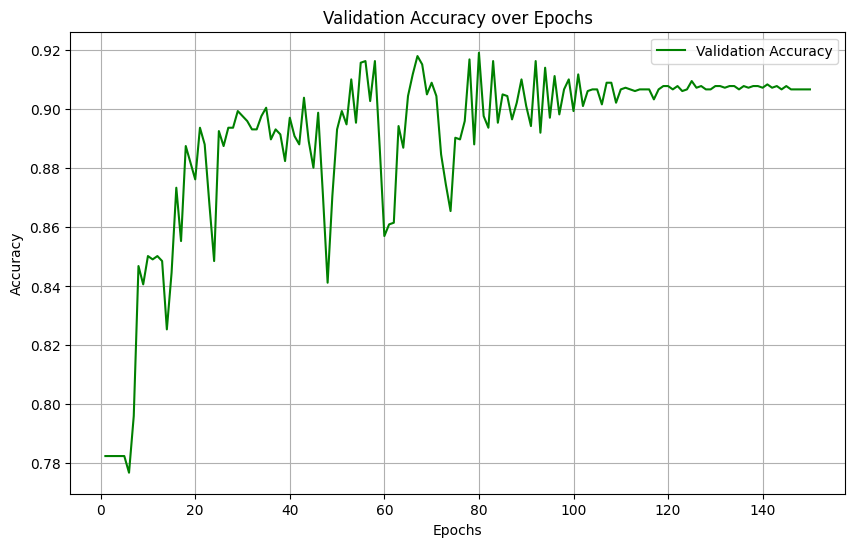

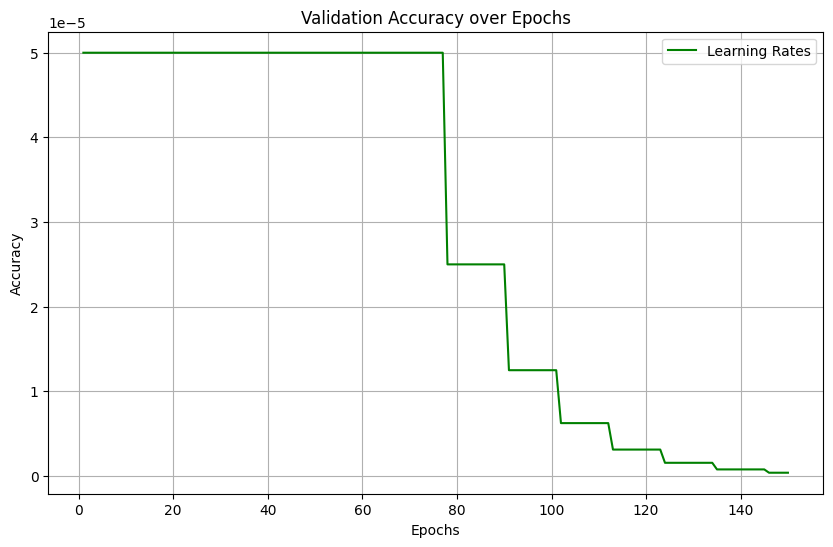

Model for bin 48 saved to 3DCholesterolModels-5A_exp1/model_bin_48.pth
1925 is length of subset grid
Training on bin 49
Bin 49, Epoch 1/150, Train Loss: 0.6930, Validation Loss: 0.6875, Validation Accuracy: 0.7825, Grad Norm: 0.0856, LR: 0.000050
Bin 49, Epoch 11/150, Train Loss: 0.6103, Validation Loss: 0.5836, Validation Accuracy: 0.8124, Grad Norm: 1.0828, LR: 0.000050
Bin 49, Epoch 21/150, Train Loss: 0.4822, Validation Loss: 0.4566, Validation Accuracy: 0.8734, Grad Norm: 3.4875, LR: 0.000050
Bin 49, Epoch 31/150, Train Loss: 0.4671, Validation Loss: 0.4612, Validation Accuracy: 0.8525, Grad Norm: 3.7949, LR: 0.000050
Bin 49, Epoch 41/150, Train Loss: 0.4543, Validation Loss: 0.4315, Validation Accuracy: 0.8831, Grad Norm: 2.5275, LR: 0.000050
Bin 49, Epoch 51/150, Train Loss: 0.4519, Validation Loss: 0.4165, Validation Accuracy: 0.9006, Grad Norm: 6.2350, LR: 0.000050
Bin 49, Epoch 61/150, Train Loss: 0.4519, Validation Loss: 0.4546, Validation Accuracy: 0.8514, Grad Norm: 2.5931

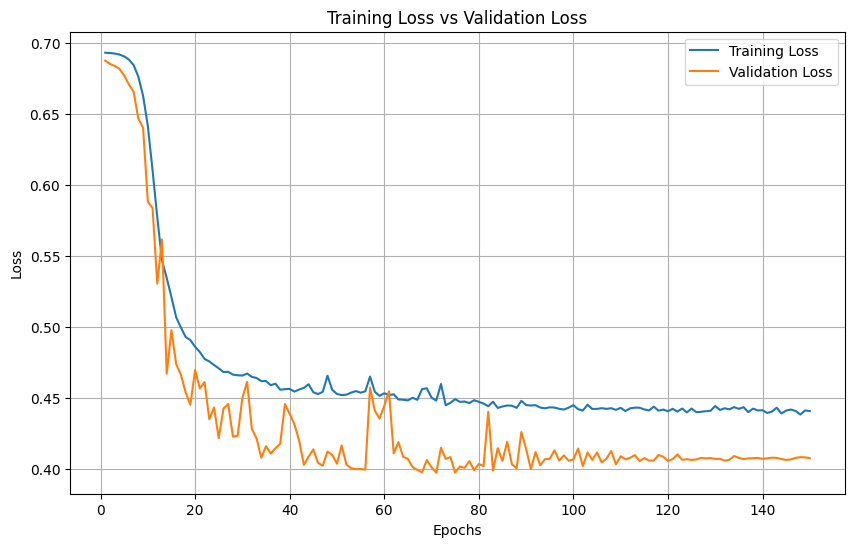

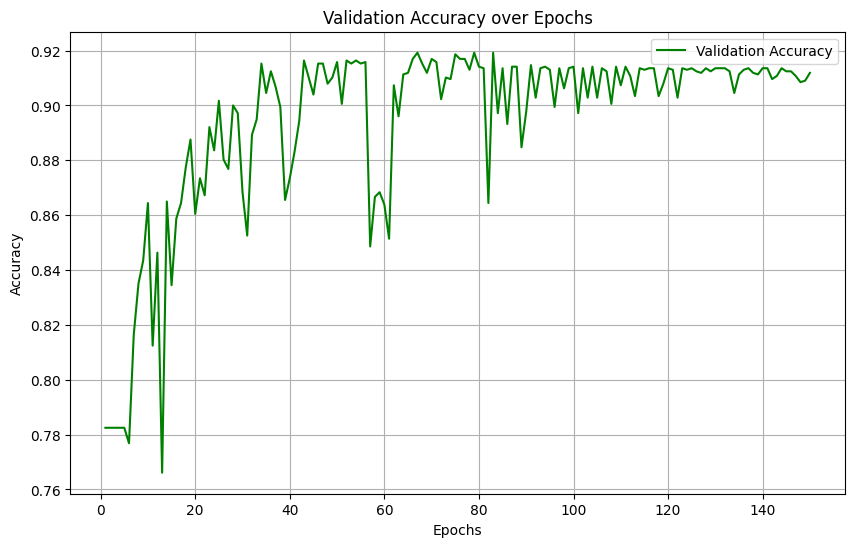

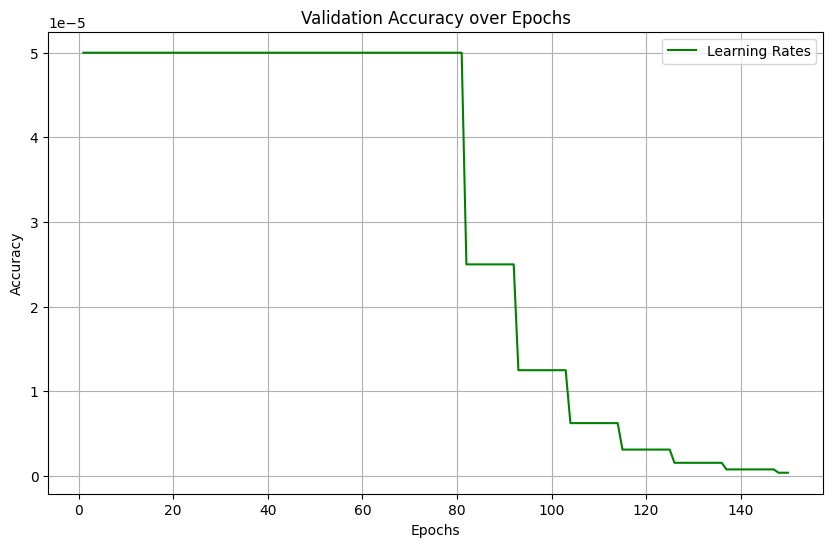

Model for bin 49 saved to 3DCholesterolModels-5A_exp1/model_bin_49.pth
1925 is length of subset grid
Training on bin 50
Bin 50, Epoch 1/150, Train Loss: 0.6930, Validation Loss: 0.6948, Validation Accuracy: 0.2175, Grad Norm: 0.0438, LR: 0.000050
Bin 50, Epoch 11/150, Train Loss: 0.5732, Validation Loss: 0.5227, Validation Accuracy: 0.8514, Grad Norm: 0.8676, LR: 0.000050
Bin 50, Epoch 21/150, Train Loss: 0.4726, Validation Loss: 0.4359, Validation Accuracy: 0.8859, Grad Norm: 1.1876, LR: 0.000050
Bin 50, Epoch 31/150, Train Loss: 0.4609, Validation Loss: 0.4234, Validation Accuracy: 0.8938, Grad Norm: 4.8920, LR: 0.000050
Bin 50, Epoch 41/150, Train Loss: 0.4589, Validation Loss: 0.4535, Validation Accuracy: 0.8542, Grad Norm: 0.7213, LR: 0.000025
Bin 50, Epoch 51/150, Train Loss: 0.4548, Validation Loss: 0.4211, Validation Accuracy: 0.8927, Grad Norm: 2.8345, LR: 0.000025
Bin 50, Epoch 61/150, Train Loss: 0.4551, Validation Loss: 0.4243, Validation Accuracy: 0.8904, Grad Norm: 3.6112

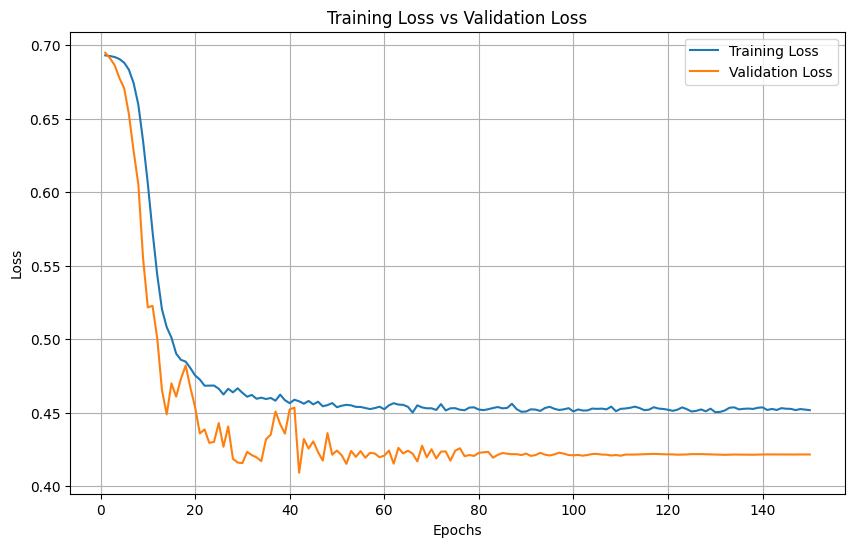

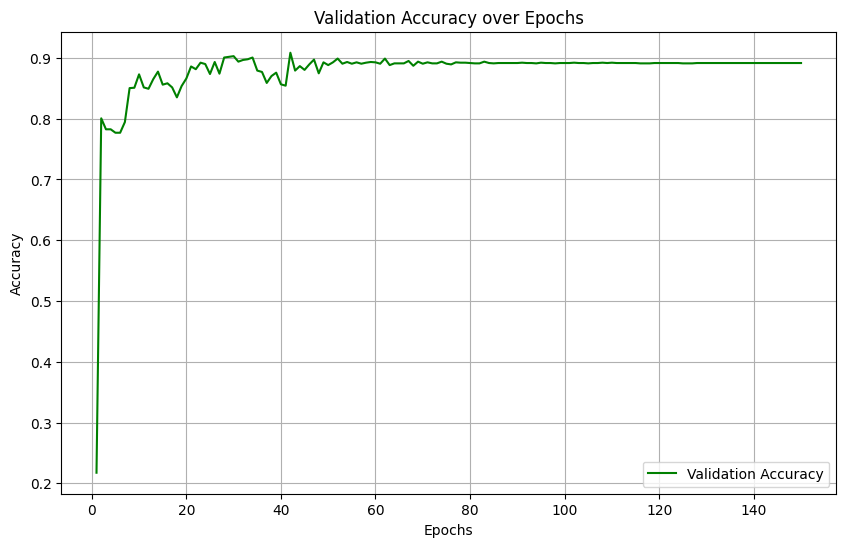

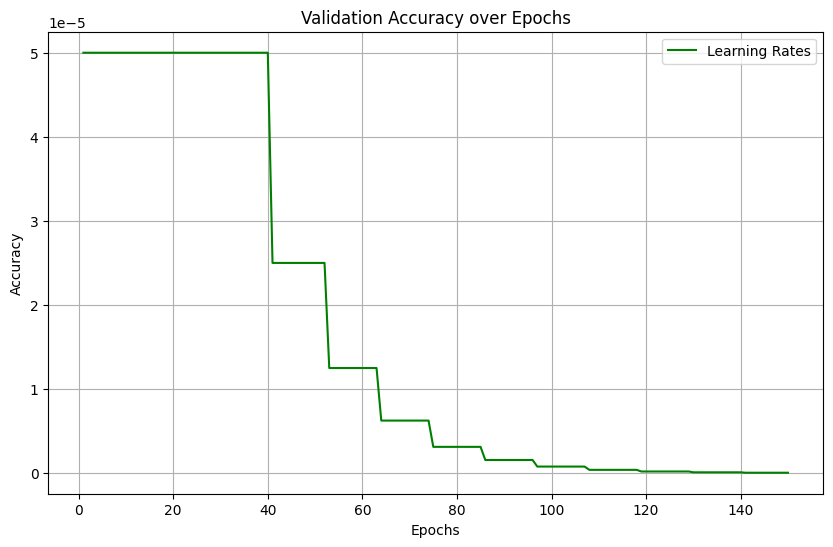

Model for bin 50 saved to 3DCholesterolModels-5A_exp1/model_bin_50.pth
Training complete.


In [6]:
import os

# Training loop
epochs = 150
batch_size = 512

validation_dataset = GridDataset(validation_grids)
validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)

for i in range(0, 50):
    k = i + 1
    file_data = {}
    subset_grid = glob.glob(f'../../../Data/SplitData/Cholesterol/cholesterol-grid-5A_exp1/k_subsets/subset_{k}/*.npy')  # Adjust path as needed
    for file in subset_grid:
        # Load the numpy array and convert it to a PyTorch tensor
        grid = np.load(file)
        grid_tensor = torch.tensor(grid, dtype=torch.float32).permute(3, 0, 1, 2)  # Fix input format
        file_data[file] = {'label': 0, 'grid_tensor': grid_tensor} # 0 means unlabeled
    subset_grid = file_data
    print(len(subset_grid), "is length of subset grid")
    
    bin = {**positive_grids, **subset_grid} # merged
    
    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # specify to run on 3 gpu, run on scrum, convert to .py 
    
    # Initialize the model
    criterion = nn.CrossEntropyLoss()
    
    # Define paths for saving models
    save_dir = "3DCholesterolModels-5A_exp1"
    os.makedirs(save_dir, exist_ok=True)
    
    model = CNN3D().to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.00005, weight_decay=1e-4) # maybe try momentum 0.9
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10, threshold=1e-4)
    #scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.90)  # Reduce LR every 10 epochs
    #scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.90)
    #scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=5000, eta_min=1e-6)
    
    print(f"Training on bin {k}")
    dataset = GridDataset(bin)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    train_losses = []
    validation_losses = []
    validation_accuracies = []
    learning_rates = []
    
    for epoch in range(epochs):
        epoch_loss, grad_norm = train_model(model, dataloader, criterion, optimizer, device)
        validation_loss, validation_accuracy = validate_model(model, validation_dataloader, criterion, device)
        scheduler.step(validation_loss)
        current_lr = optimizer.param_groups[0]['lr'] 
        train_losses.append(epoch_loss)
        validation_losses.append(validation_loss)
        validation_accuracies.append(validation_accuracy)
        learning_rates.append(current_lr)
    
        if epoch % 10 == 0:
            print(
                f"Bin {k}, Epoch {epoch+1}/{epochs}, "
                f"Train Loss: {epoch_loss:.4f}, Validation Loss: {validation_loss:.4f}, "
                f"Validation Accuracy: {validation_accuracy:.4f}, Grad Norm: {grad_norm:.4f}, "
                f"LR: {current_lr:.6f}"
            )
            
    plot_graphs(train_losses, validation_losses, validation_accuracies, learning_rates)
    
    #Save the trained model
    model_path = os.path.join(save_dir, f"model_bin_{k}.pth")
    torch.save(model.state_dict(), model_path)
    print(f"Model for bin {k} saved to {model_path}")

print("Training complete.")

# 